In [3]:
import os
import pickle

import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from policy import config
from policy.dataset.ms2dataset import get_MS_loaders
from policy.checkpoints import CheckpointIO

model_dir = "/home/mrl/Documents/Projects/tskill/out/PegInsertion/021"

cfg_path = os.path.join(model_dir, "config.yaml")
cfg = config.load_config(cfg_path, None)

index_path = os.path.join(model_dir, "data_info.pickle")
with open(index_path, 'rb') as f:
    data_info = pickle.load(f)

# Dataset
cfg["data"]["pad_train"] = False
cfg["data"]["pad_val"] = False
cfg["data"]["augment"] = False
cfg["data"]["full_seq"] = False

# Load only the full episode version of the dataset
if "train_ep_indices" not in data_info.keys():
    train_idx, val_idx = data_info["train_indices"], data_info["val_indices"]
else:
    train_idx, val_idx = data_info["train_ep_indices"], data_info["val_ep_indices"]
train_dataset, val_dataset = get_MS_loaders(cfg, return_datasets=True, 
                                            indices=(train_idx, val_idx))
    

Found existing data info file
Using override indices
Loading action and state scaling from file


In [13]:
# Model
model = config.get_model(cfg, device="cpu")
checkpoint_io = CheckpointIO(model_dir, model=model)
load_dict = checkpoint_io.load("model_best.pt")
model.train()

train = True
if not train:
    dataset = val_dataset
    print("Using Validation Dataset")
    idxs = val_idx
else:
    dataset = train_dataset
    print("Using Training Dataset")
    idxs = train_idx


class AttentionHook:
    def __init__(self):
        self.attention_weights = None
        self.attention = None
        self.inputs = None

    def __call__(self, module, input, output):
        print(output[0].shape, output[1].shape)
        self.attention = output[0]
        self.attention_weights = output[1]
        self.inputs = input


def visualize_attention_weights(attention_weights, input_len, layer_name, layer_num, attn):
    avg_attention = attention_weights.mean(dim=0).abs().detach().cpu().numpy()
    print(avg_attention.shape)
    plt.figure(figsize=(20, 20))
    sns.heatmap(avg_attention, annot=False, cmap='YlGnBu')
    
    plt.xlabel('Input Sequence')
    plt.ylabel('Input Sequence')
    plt.title(f'{layer_name} Layer {layer_num} {attn} Attention Weight Visualization')
    
    plt.xticks(range(input_len), range(input_len), rotation=90)
    plt.yticks(range(input_len), range(input_len), rotation=0)
    
    plt.tight_layout()
    plt.show()

def visualize_attention(attention, input_len, layer_name, layer_num, attn):
    avg_attention = attention.mean(dim=-1).abs().squeeze().detach().cpu().numpy()
    print(avg_attention.shape)
    plt.figure(figsize=(20, 10))
    sns.barplot(avg_attention)
    
    plt.xlabel('Input Sequence')
    plt.ylabel('Attention')
    plt.title(f'{layer_name} Layer {layer_num} {attn} Attention Visualization')
    
    plt.xticks(range(input_len), range(input_len), rotation=90)
    
    plt.tight_layout()
    plt.show()

# Register hooks
dec_enc_hooks = []
dec_dec_hooks = []
enc_enc_hooks = []
enc_dec_hooks = []

for i, layer in enumerate(model.decoder.encoder.layers):
    hook = AttentionHook()
    hook.name = "SA"
    layer.self_attn.register_forward_hook(hook)
    dec_enc_hooks.append(hook)

for i, layer in enumerate(model.decoder.decoder.layers):
    hook1 = AttentionHook()
    hook1.name = "SA"
    hook2 = AttentionHook()
    hook2.name = "MHA"
    layer.self_attn.register_forward_hook(hook1)
    layer.multihead_attn.register_forward_hook(hook2)
    dec_dec_hooks.append(hook1)
    dec_dec_hooks.append(hook2)

for i, layer in enumerate(model.encoder.encoder.layers):
    hook = AttentionHook()
    hook.name = "SA"
    layer.self_attn.register_forward_hook(hook)
    enc_enc_hooks.append(hook)

for i, layer in enumerate(model.encoder.decoder.layers):
    hook1 = AttentionHook()
    hook1.name = "SA"
    hook2 = AttentionHook()
    hook2.name = "MHA"
    layer.self_attn.register_forward_hook(hook1)
    layer.multihead_attn.register_forward_hook(hook2)
    enc_dec_hooks.append(hook1)
    enc_dec_hooks.append(hook2)

freezing state encoder network!
/home/mrl/Documents/Projects/tskill/out/PegInsertion/021/model_best.pt
=> Loading checkpoint from local file...
load state dict: <All keys matched successfully>
Using Training Dataset


/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but

torch.Size([426, 1, 128]) torch.Size([1, 426, 426])
torch.Size([15, 1, 128]) torch.Size([1, 15, 15])
torch.Size([15, 1, 128]) torch.Size([1, 15, 426])
torch.Size([15, 1, 128]) torch.Size([1, 15, 15])
torch.Size([15, 1, 128]) torch.Size([1, 15, 426])
torch.Size([48, 1, 128]) torch.Size([1, 48, 48])
torch.Size([48, 1, 128]) torch.Size([1, 48, 48])
torch.Size([142, 1, 128]) torch.Size([1, 142, 142])
torch.Size([142, 1, 128]) torch.Size([1, 142, 48])
torch.Size([142, 1, 128]) torch.Size([1, 142, 142])
torch.Size([142, 1, 128]) torch.Size([1, 142, 48])
torch.Size([142, 1, 128]) torch.Size([1, 142, 142])
torch.Size([142, 1, 128]) torch.Size([1, 142, 48])
torch.Size([1, 142, 8])
(426, 426)


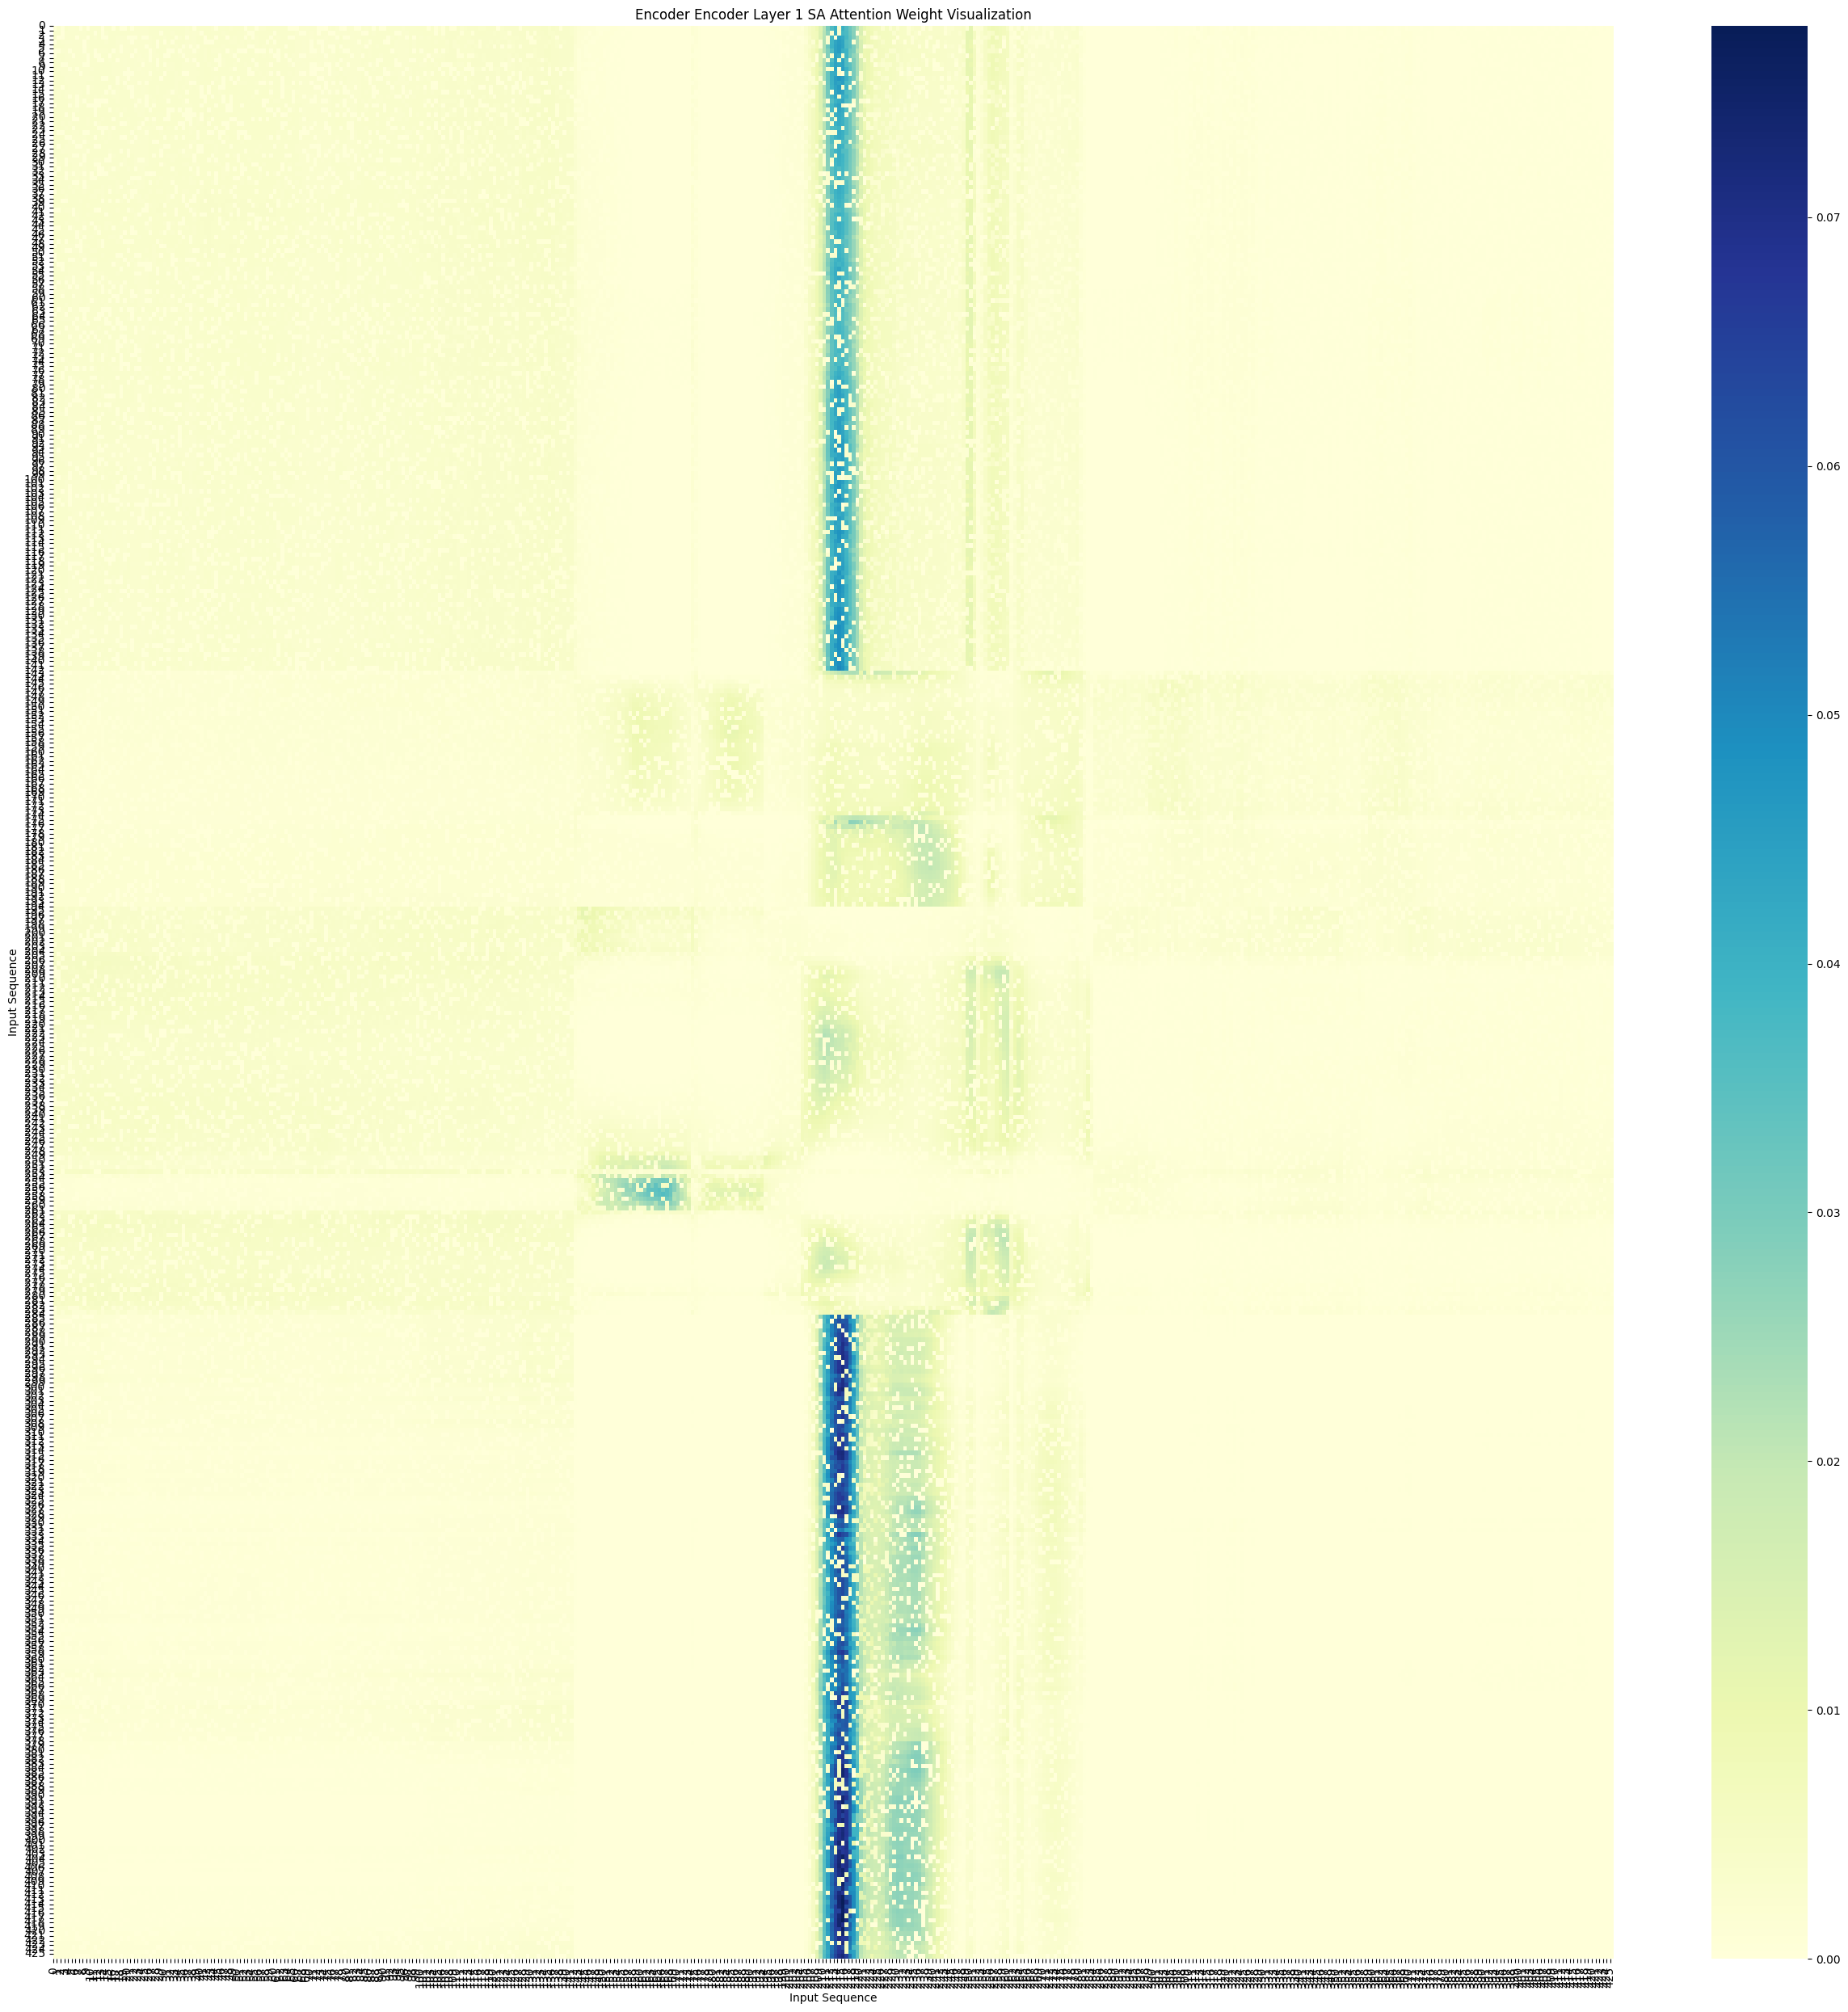

(426,)


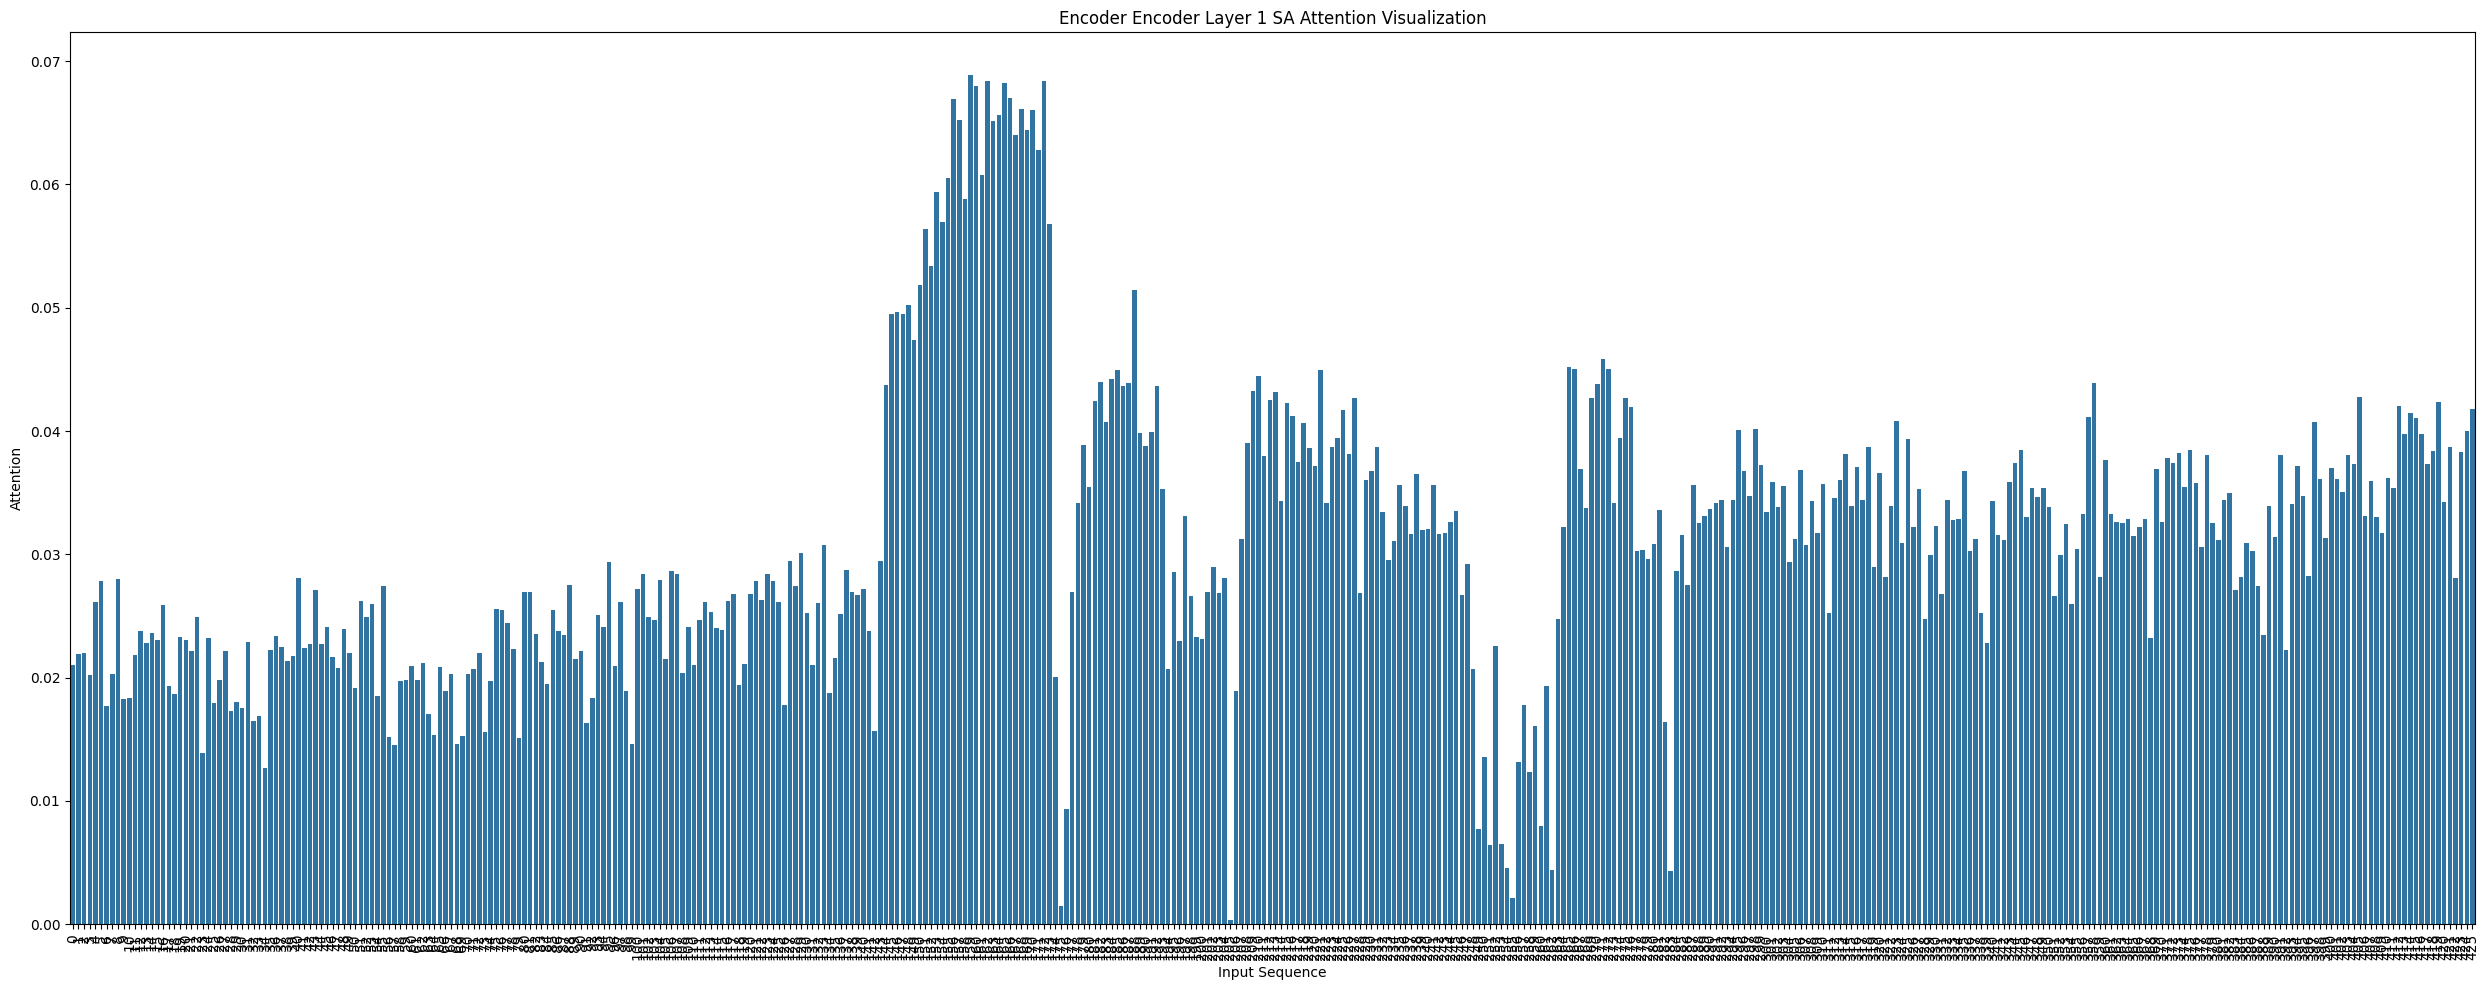

(15, 15)


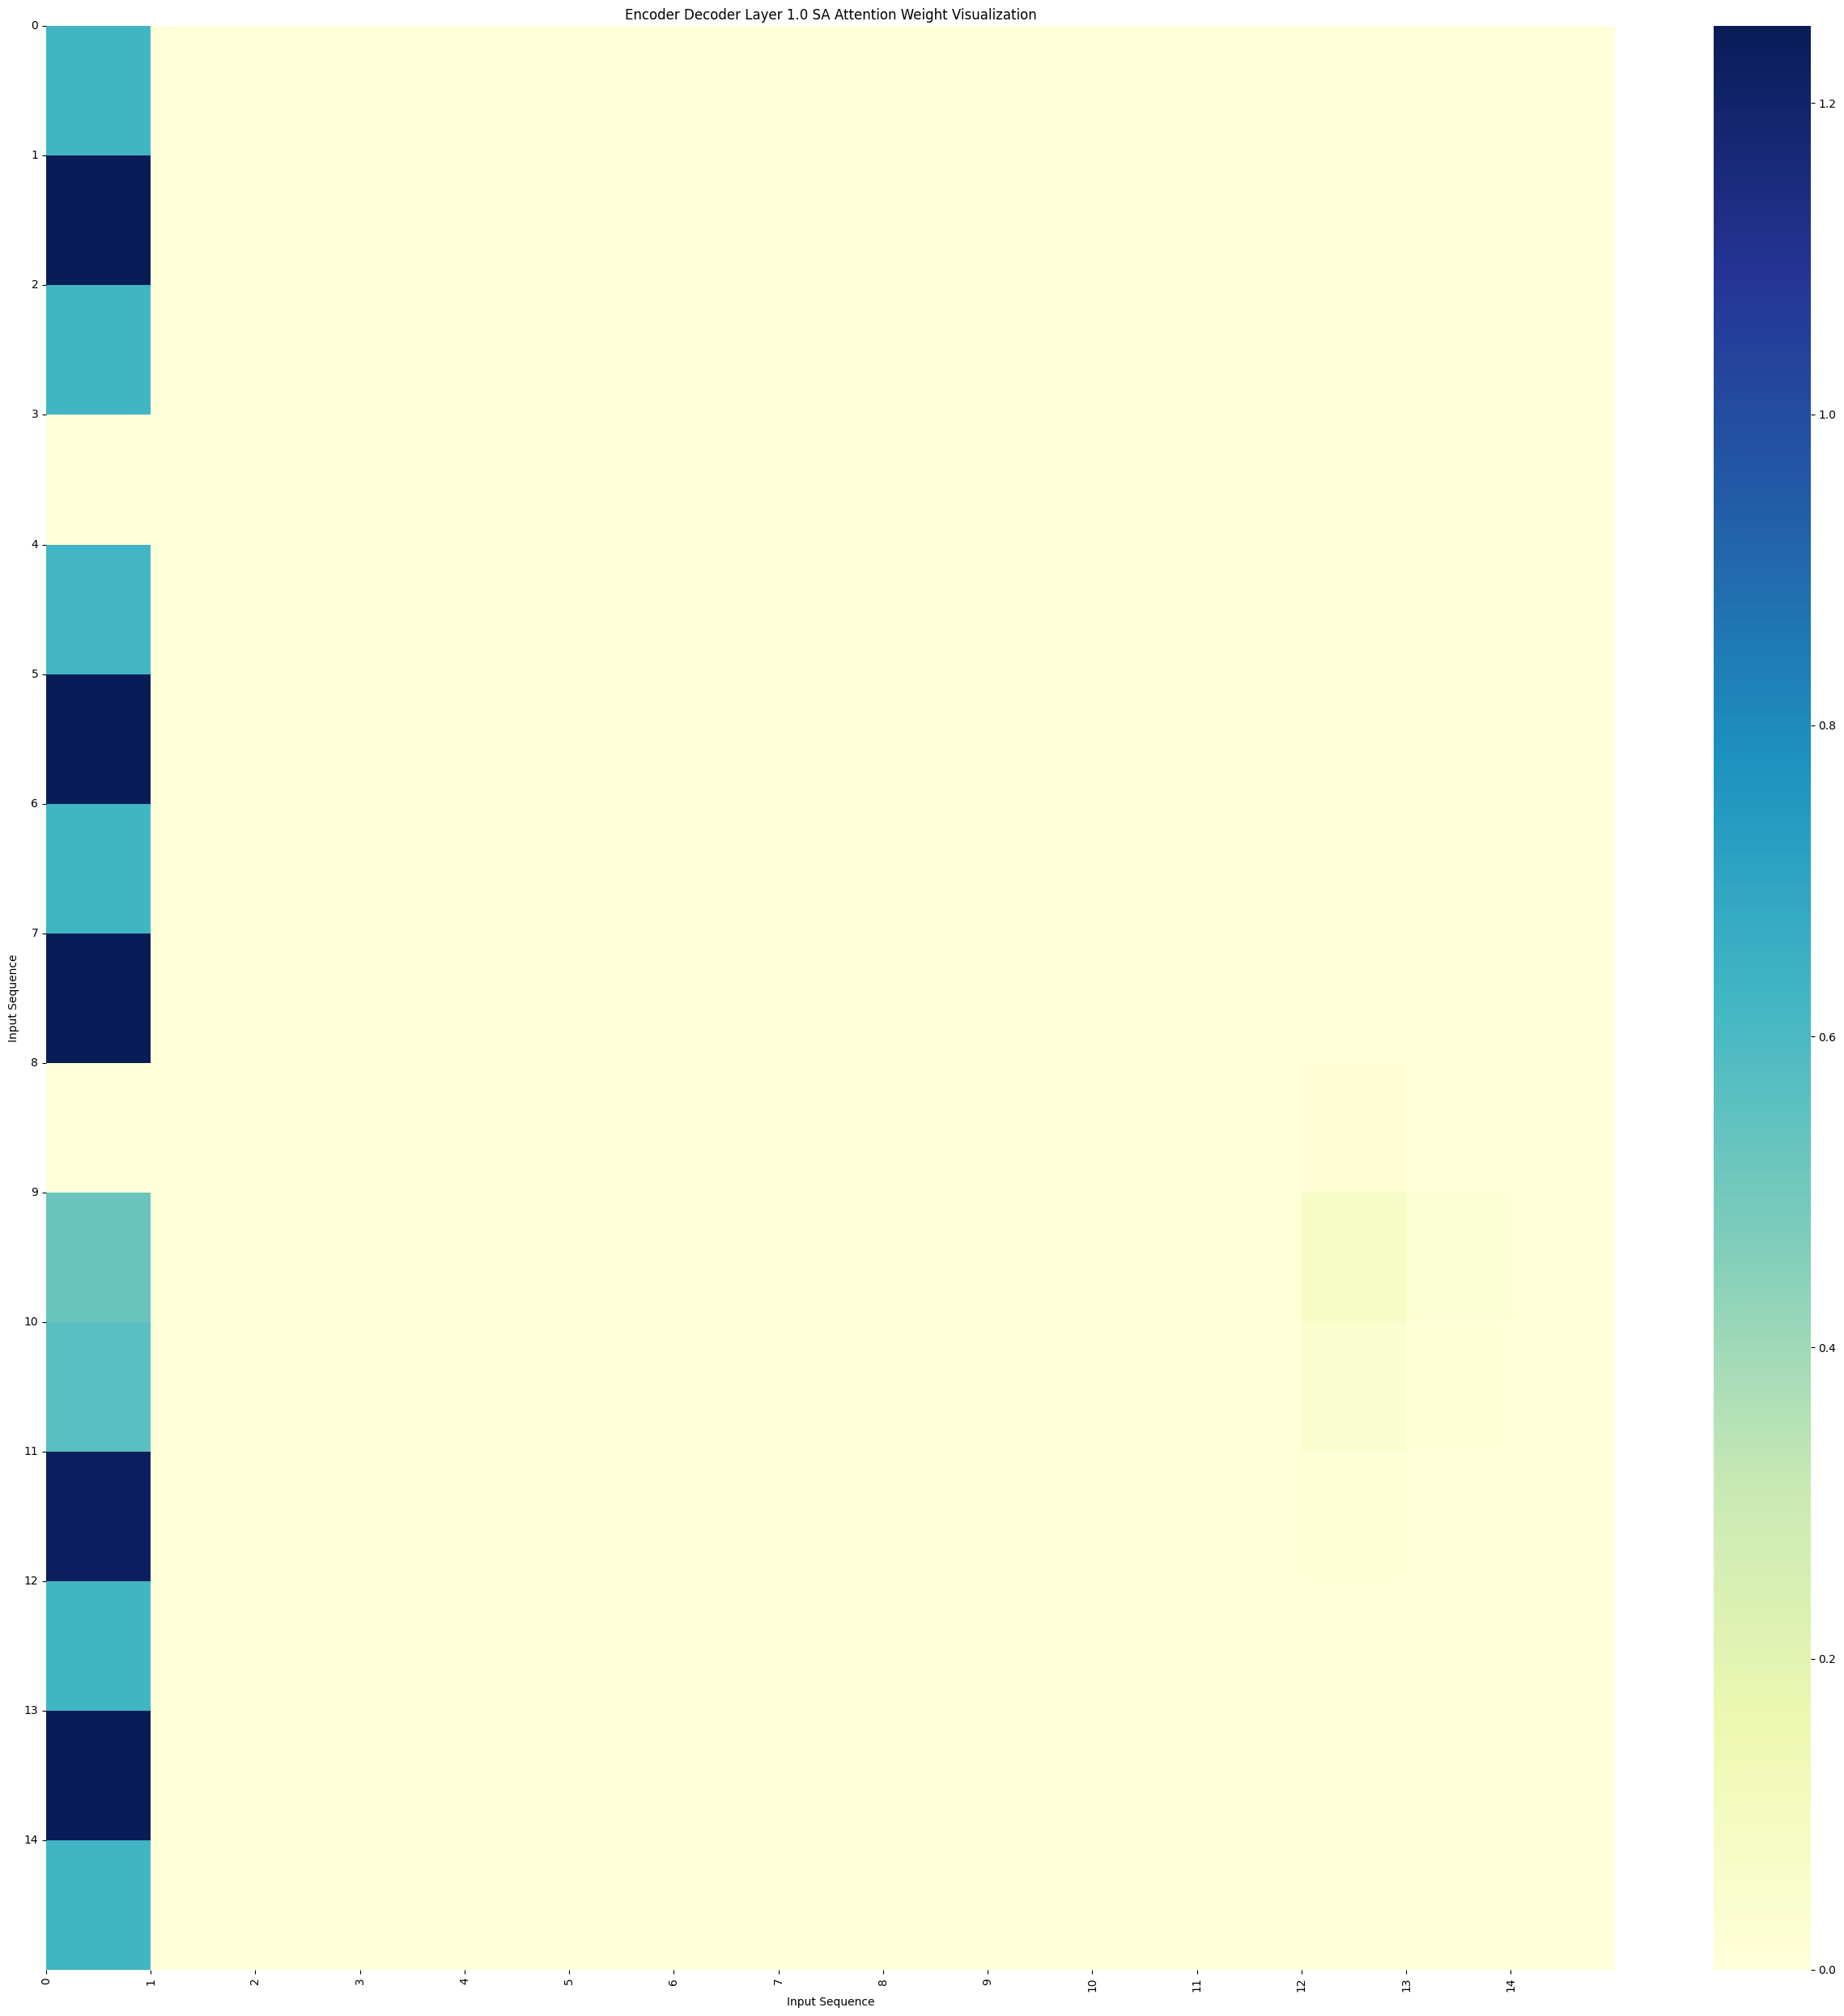

(15,)


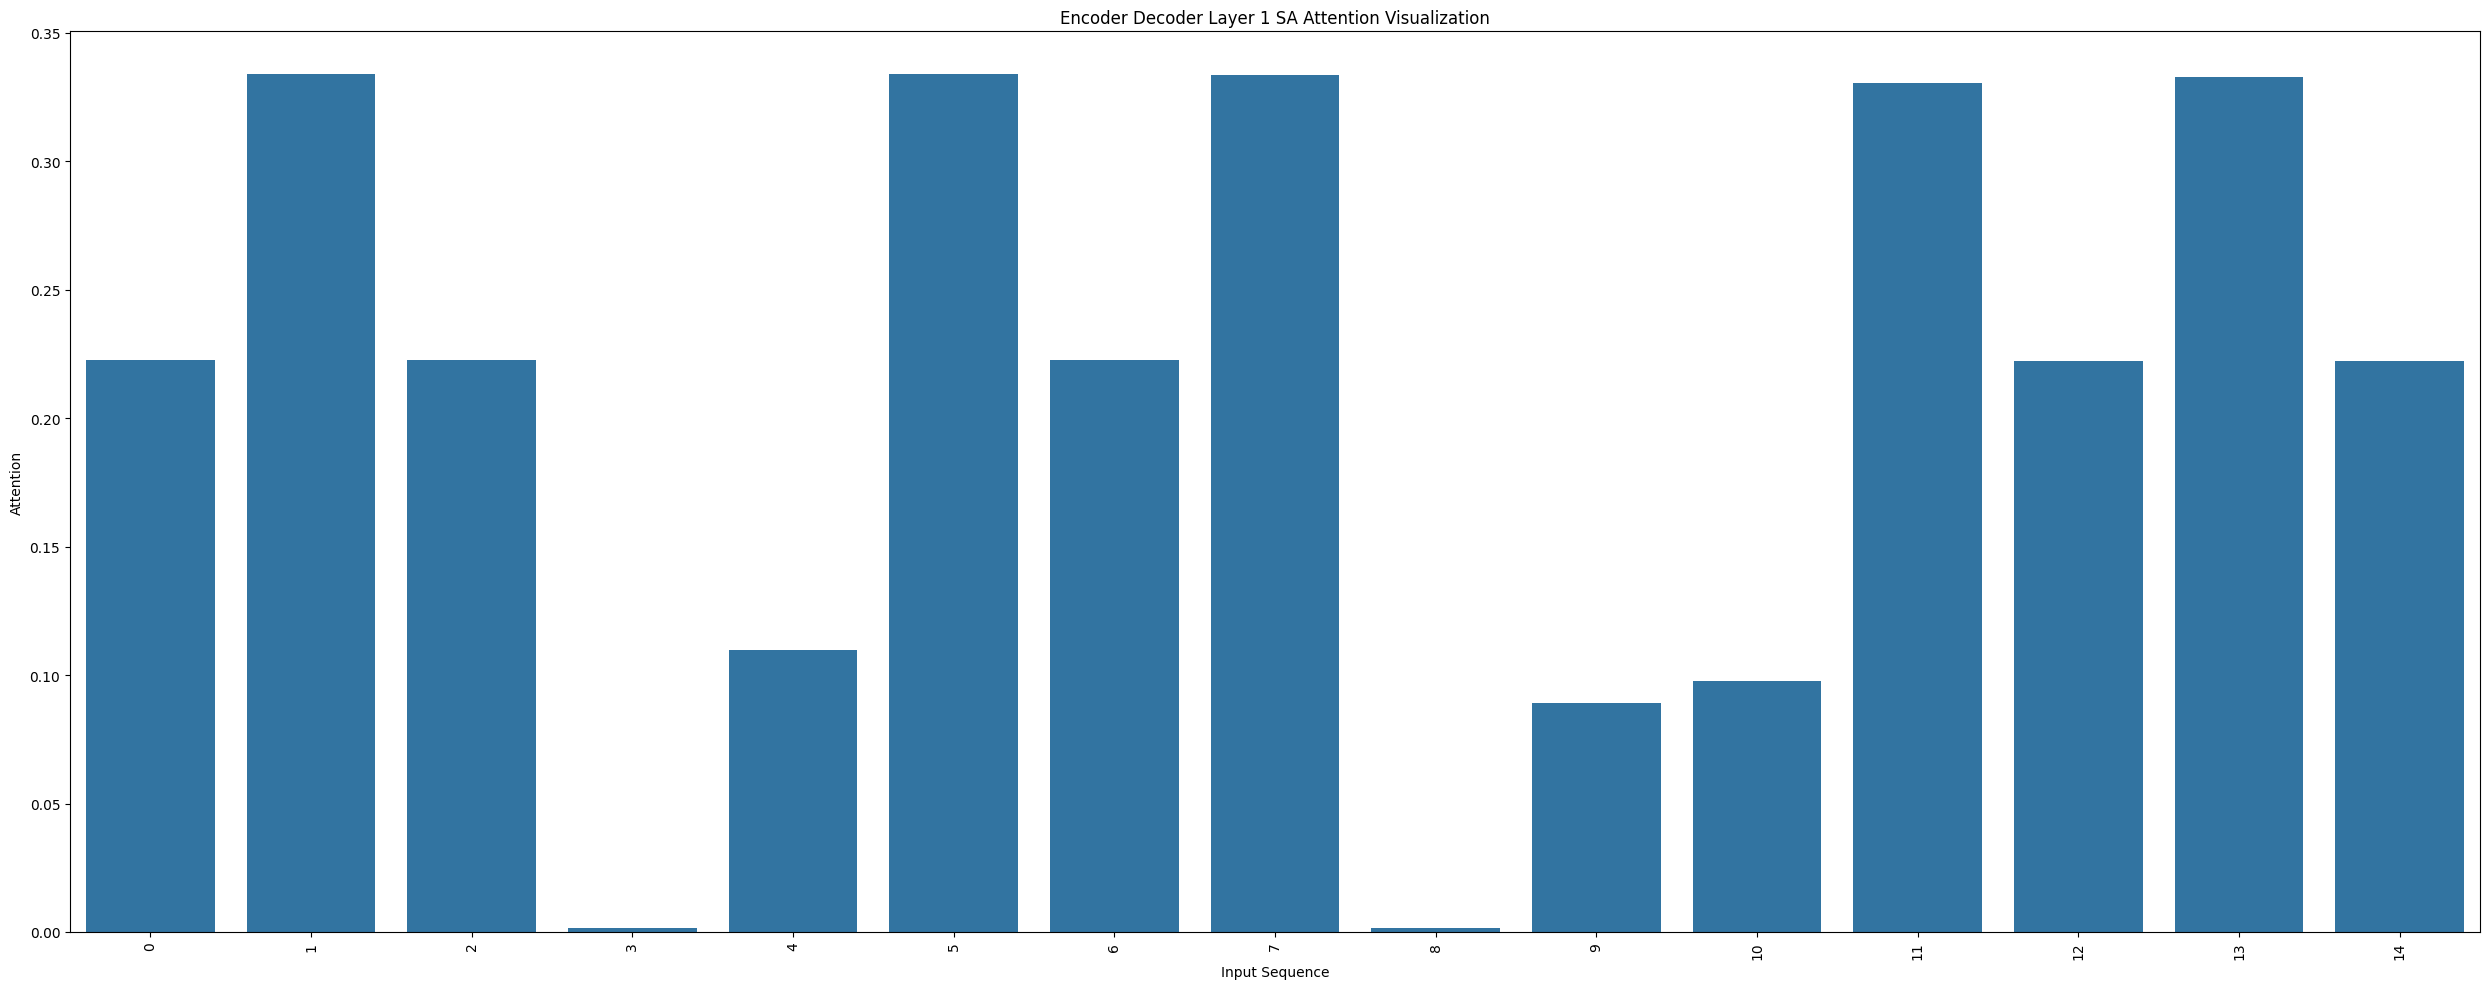

(15, 426)


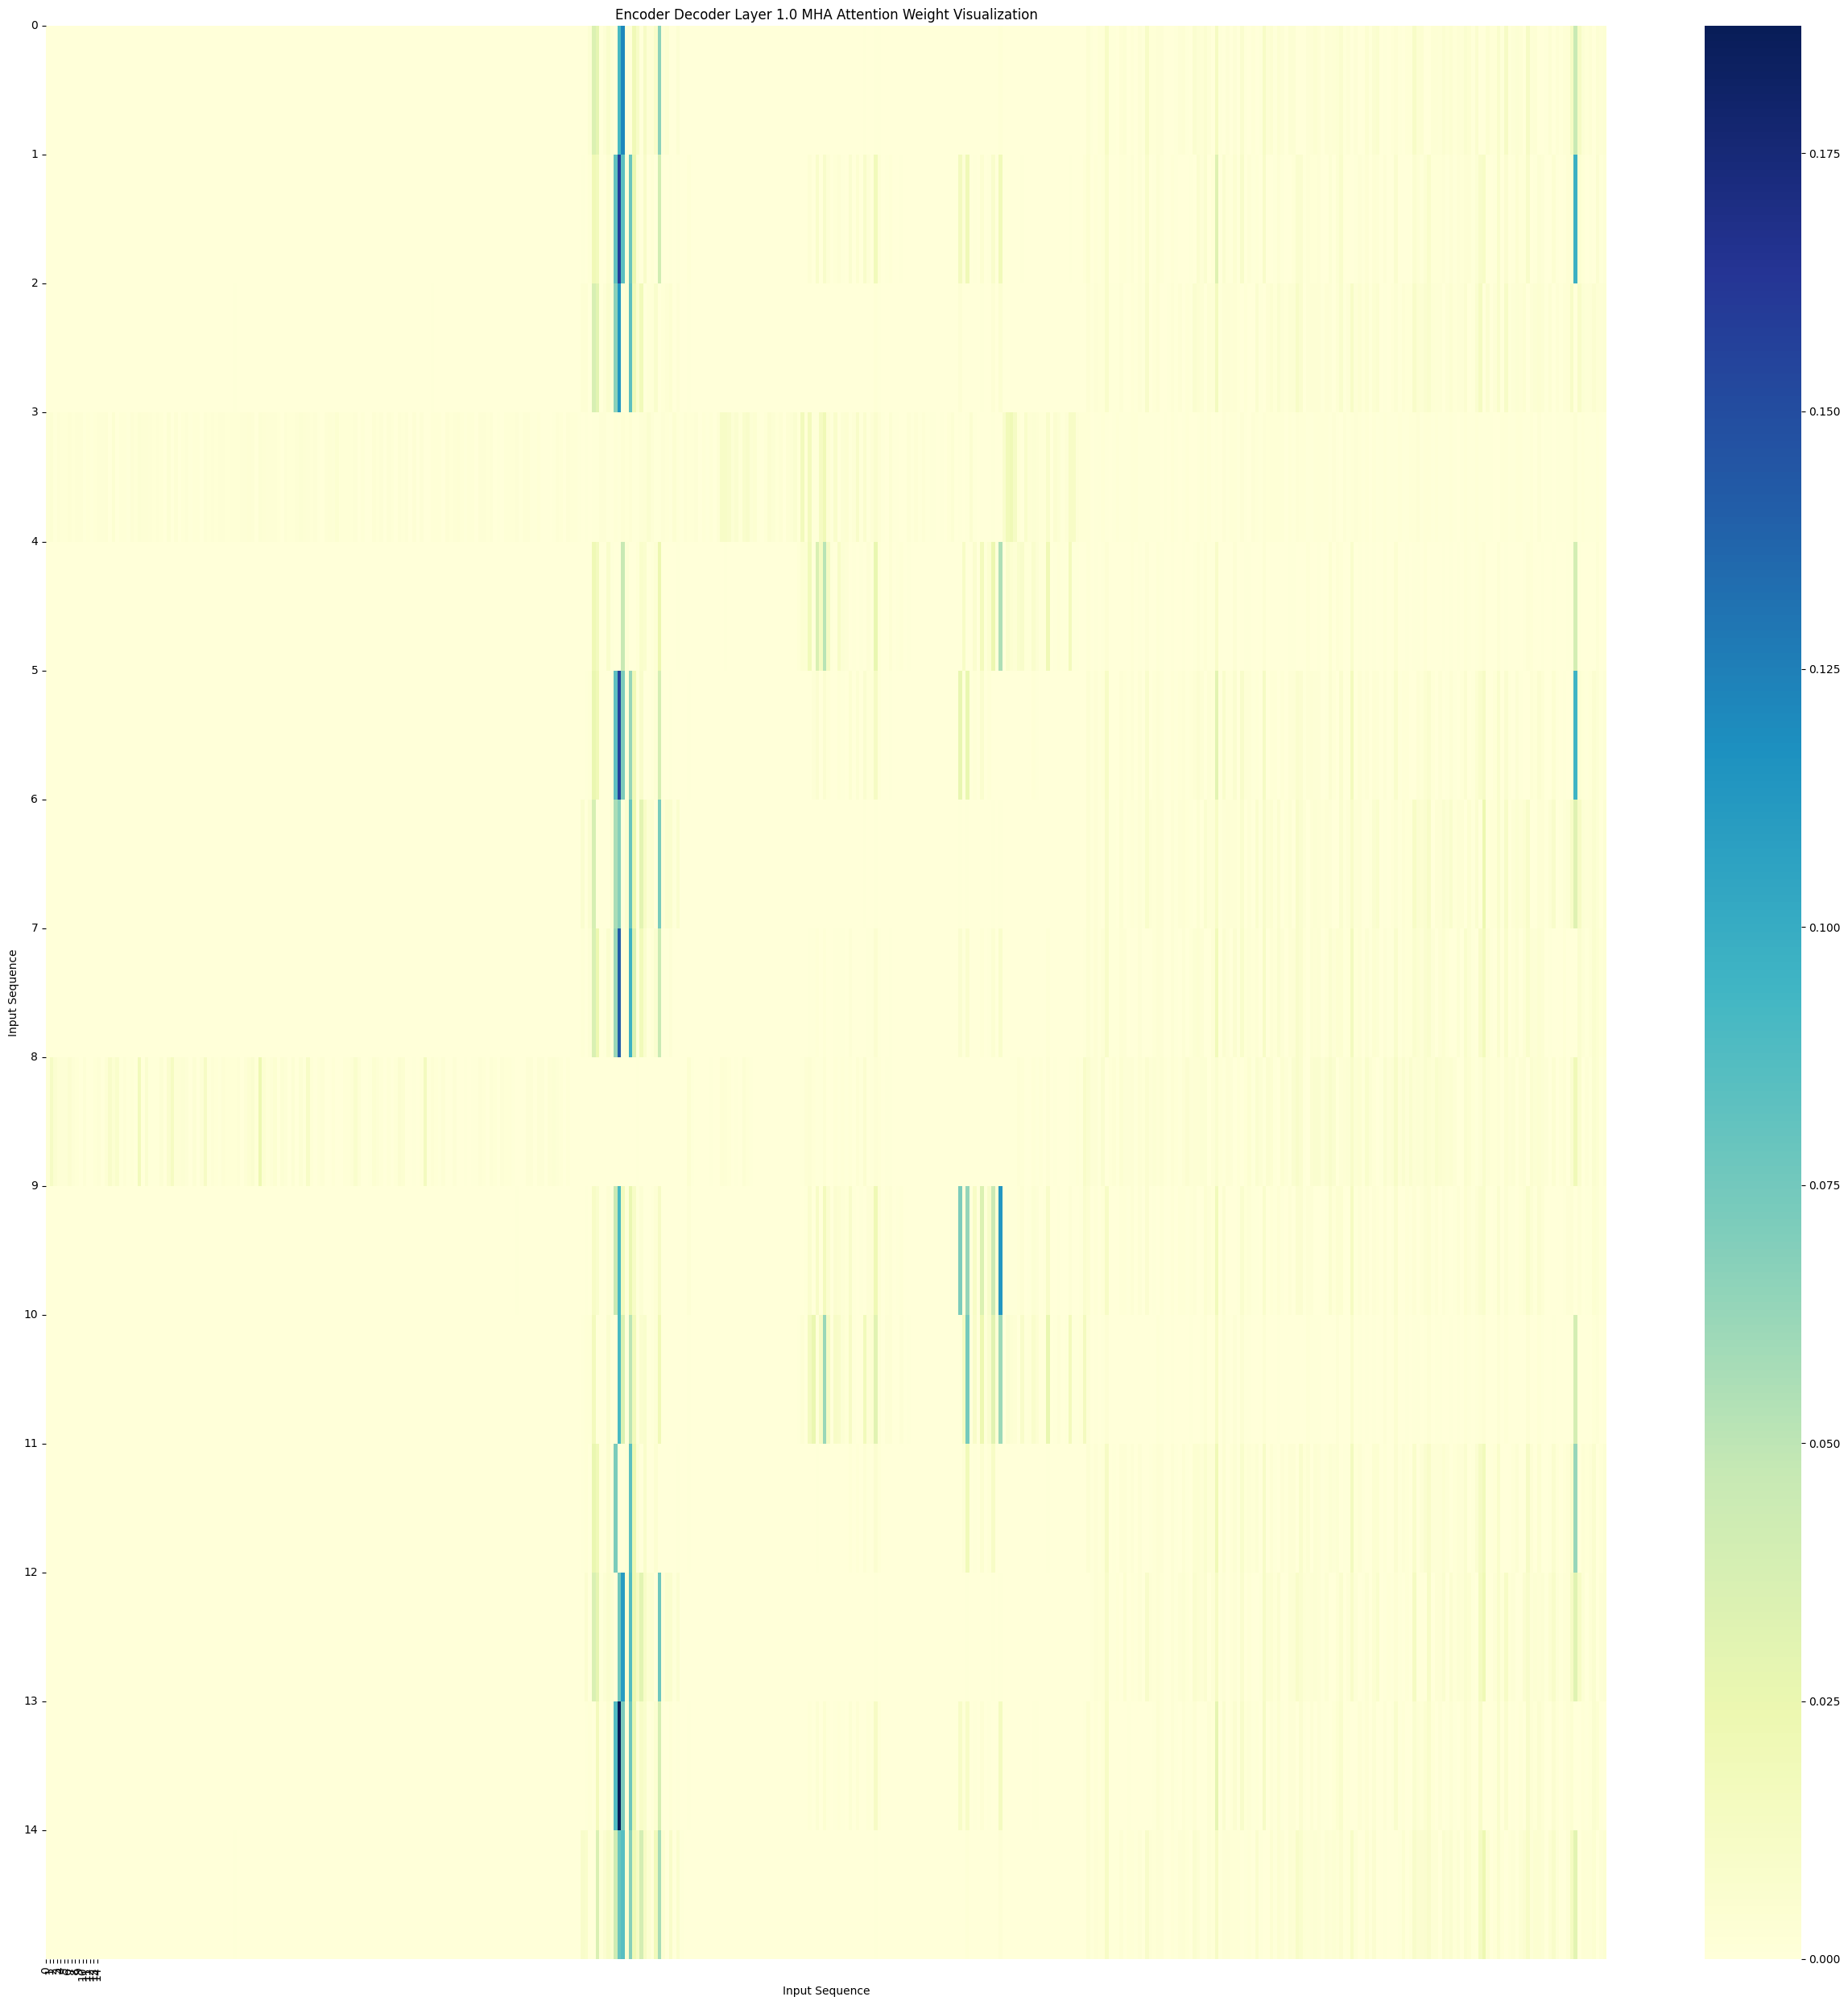

(15,)


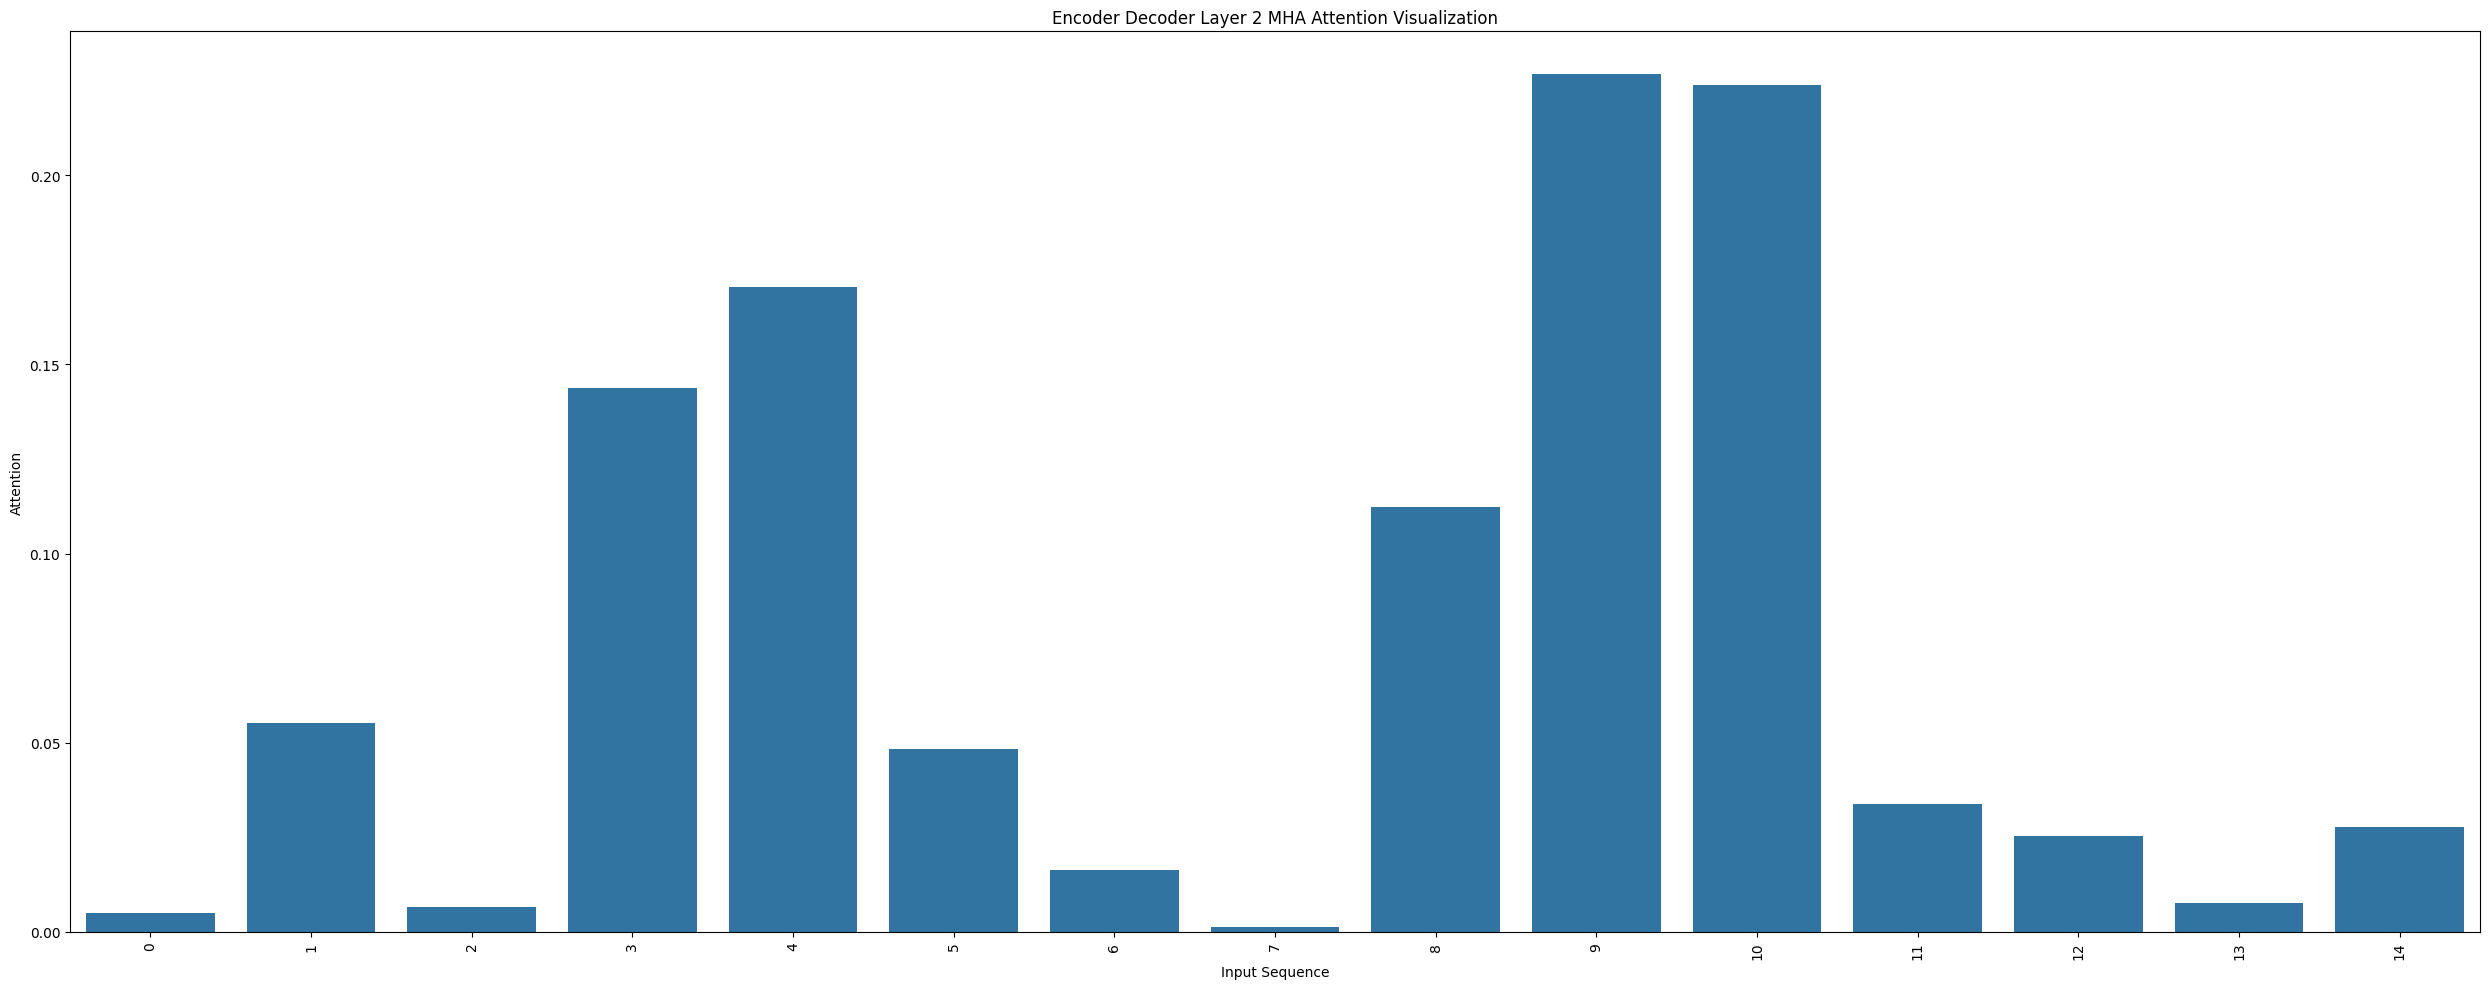

(15, 15)


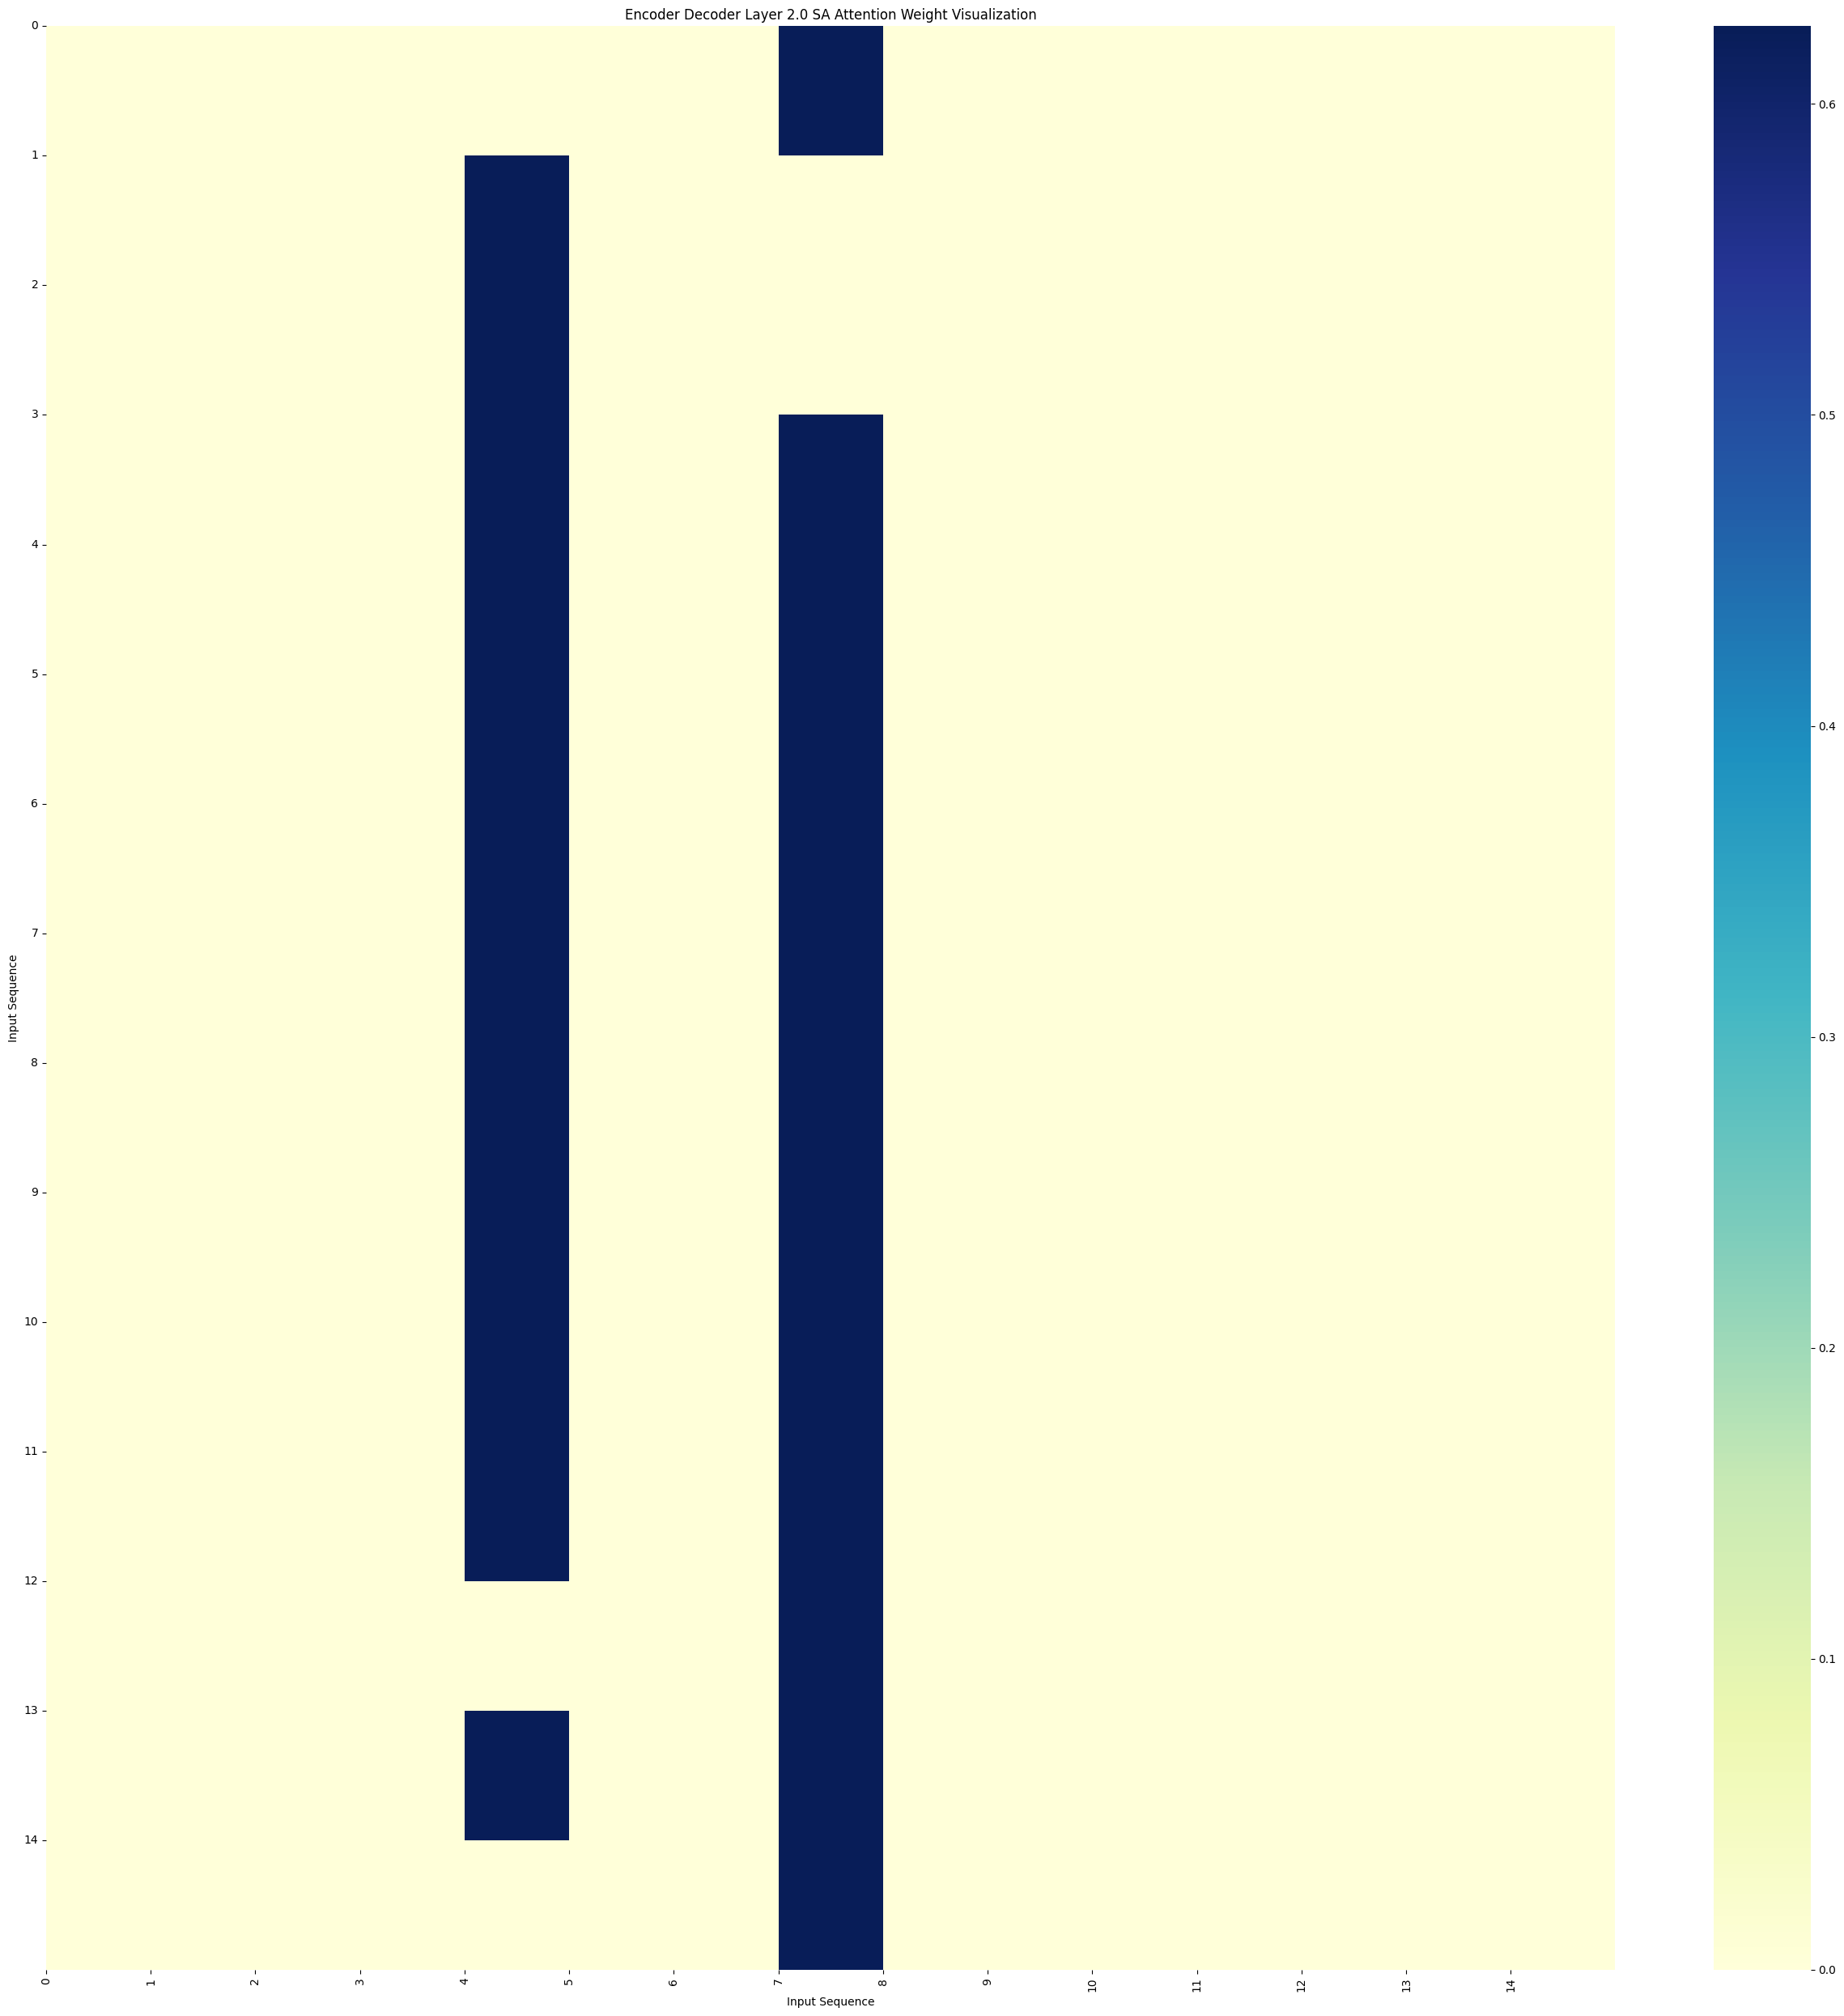

(15,)


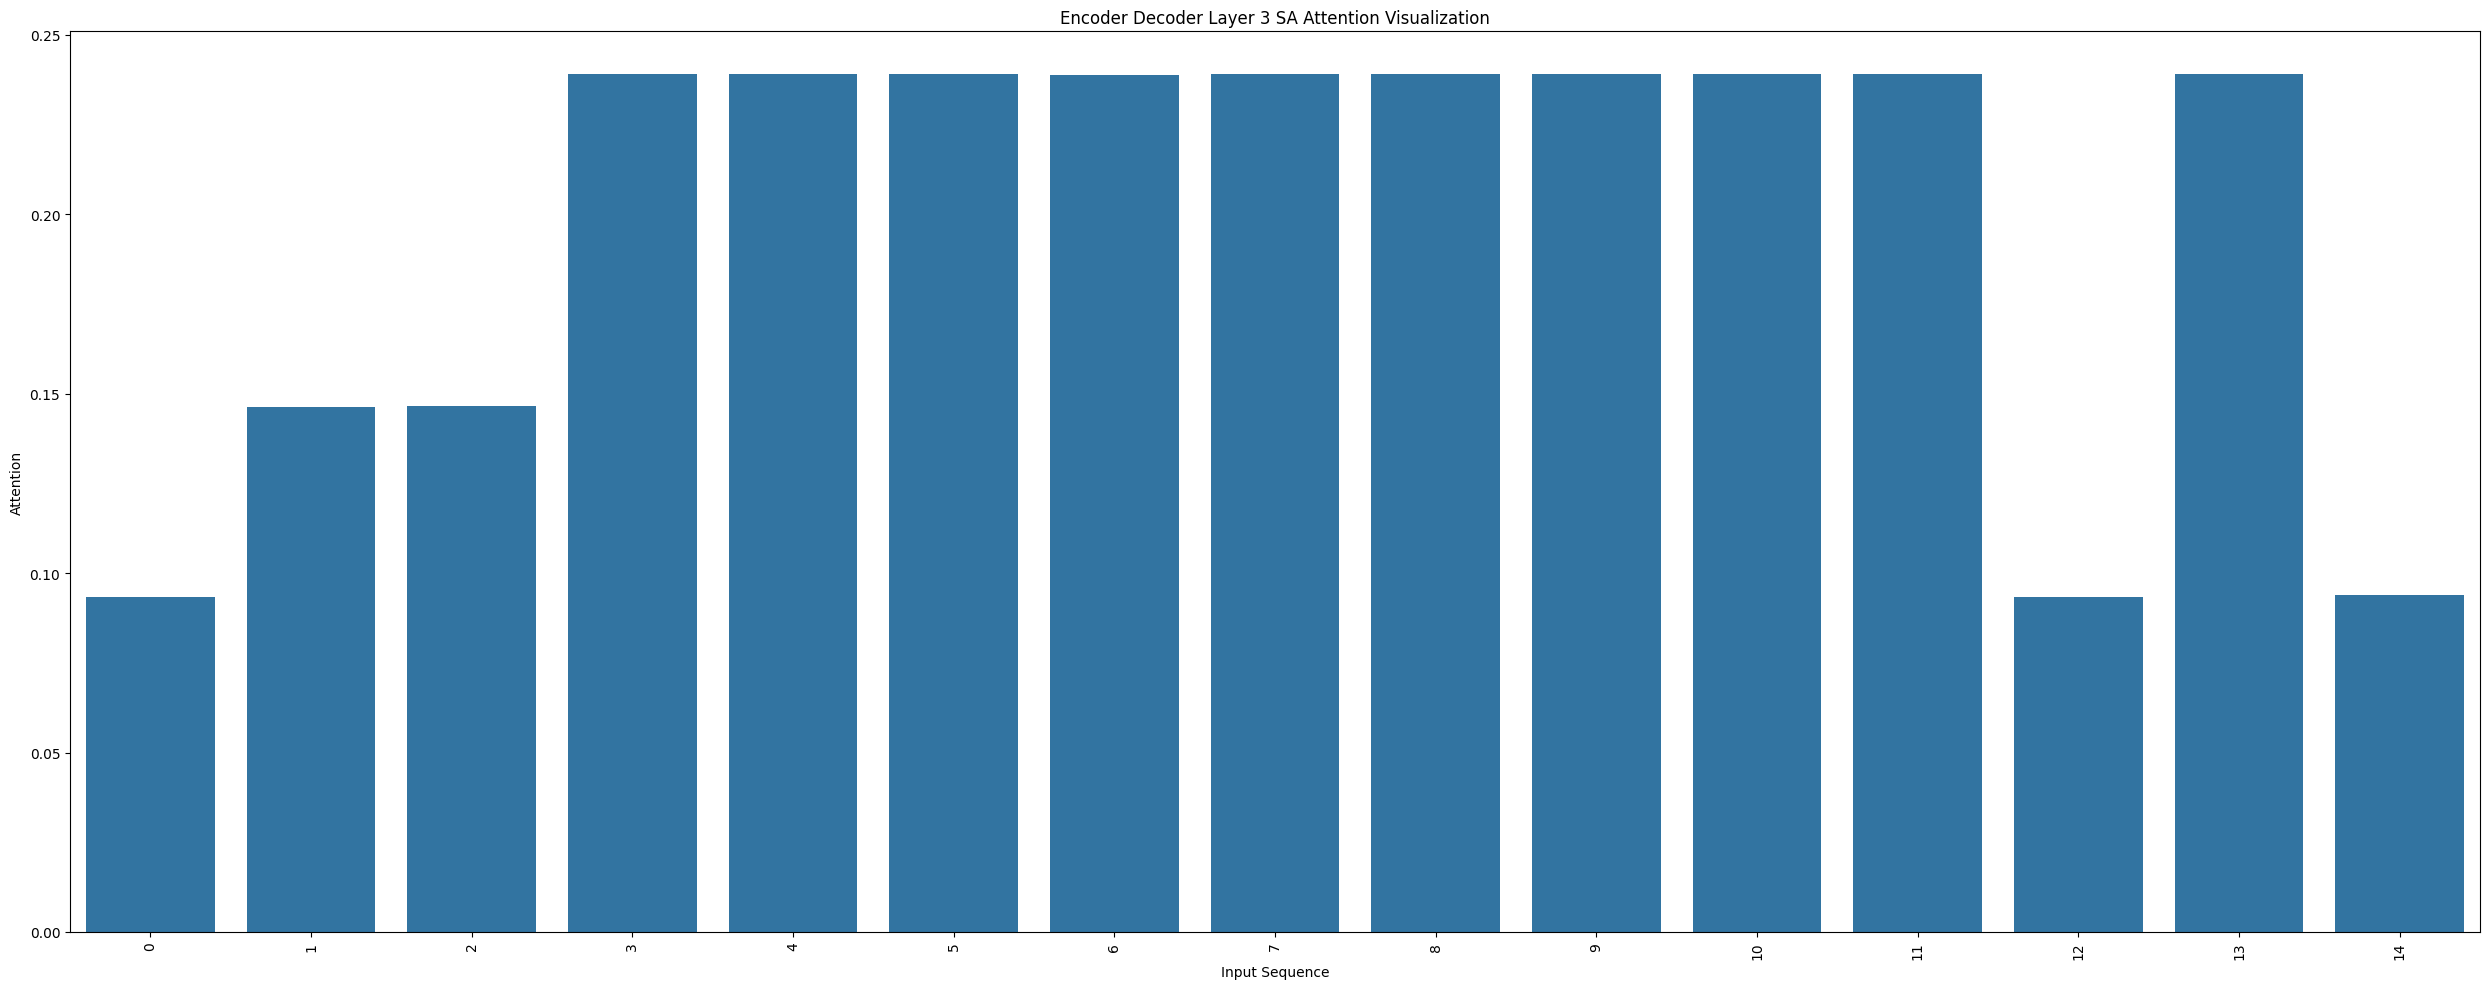

(15, 426)


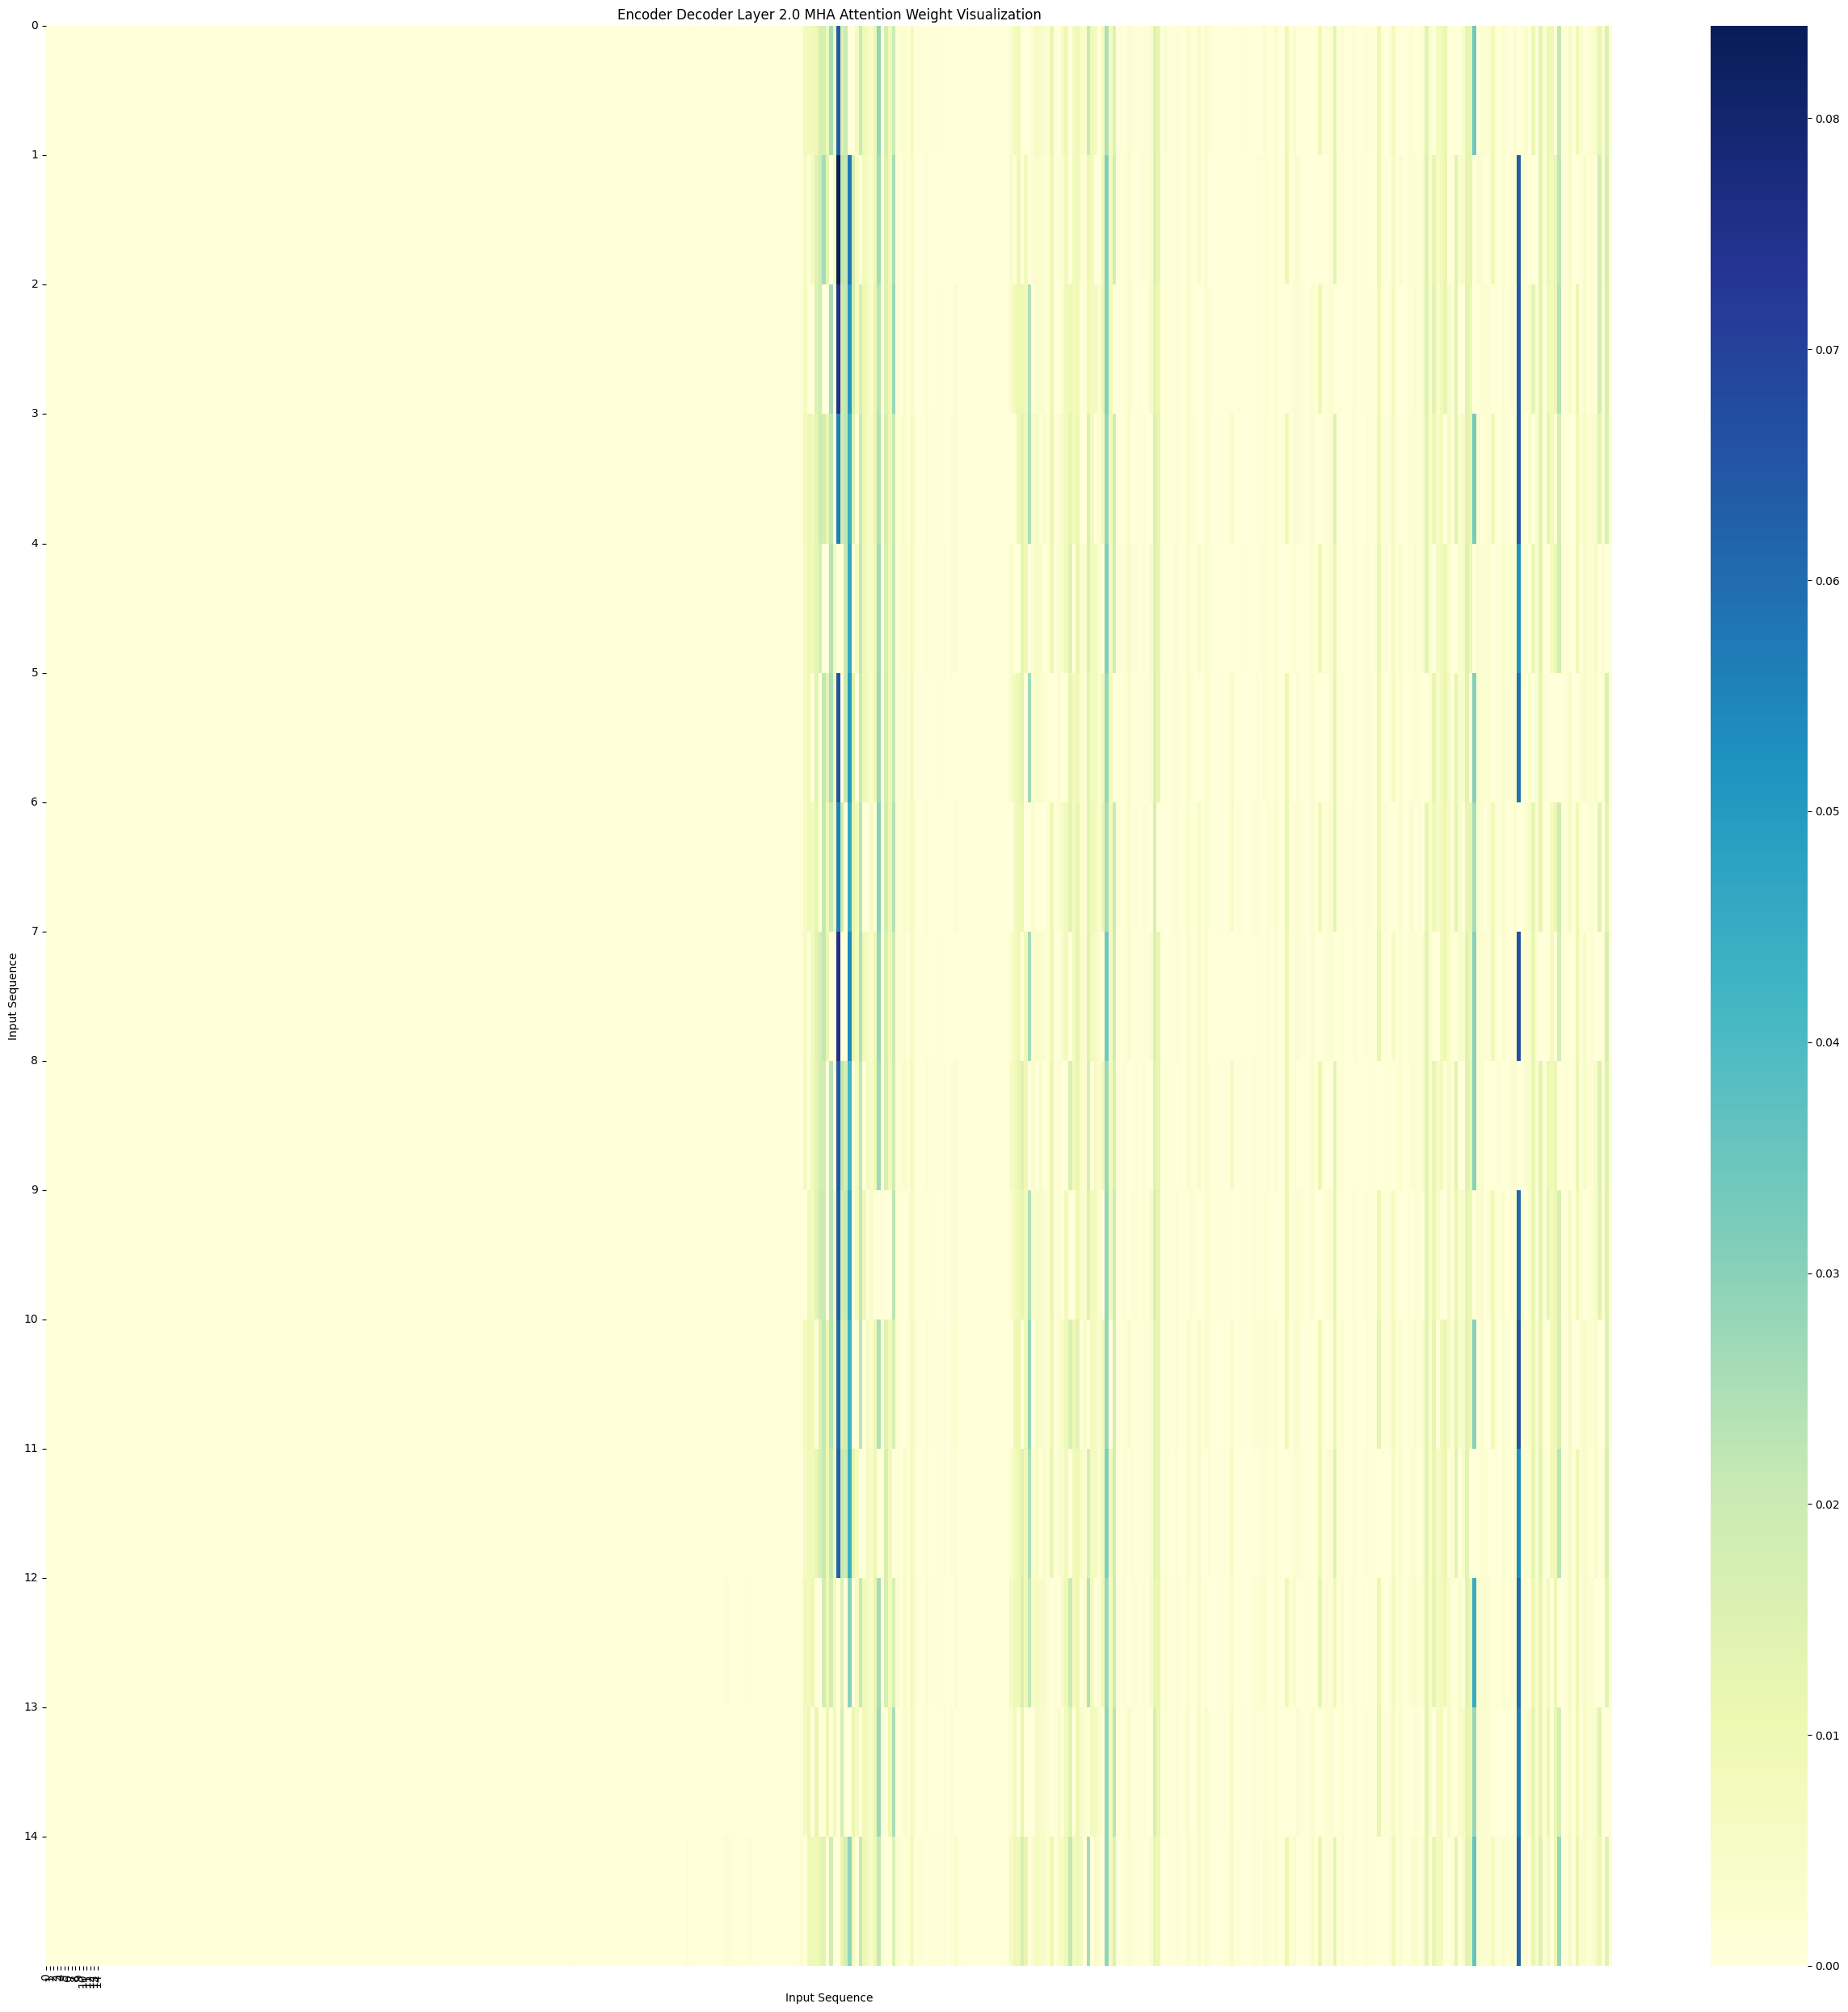

(15,)


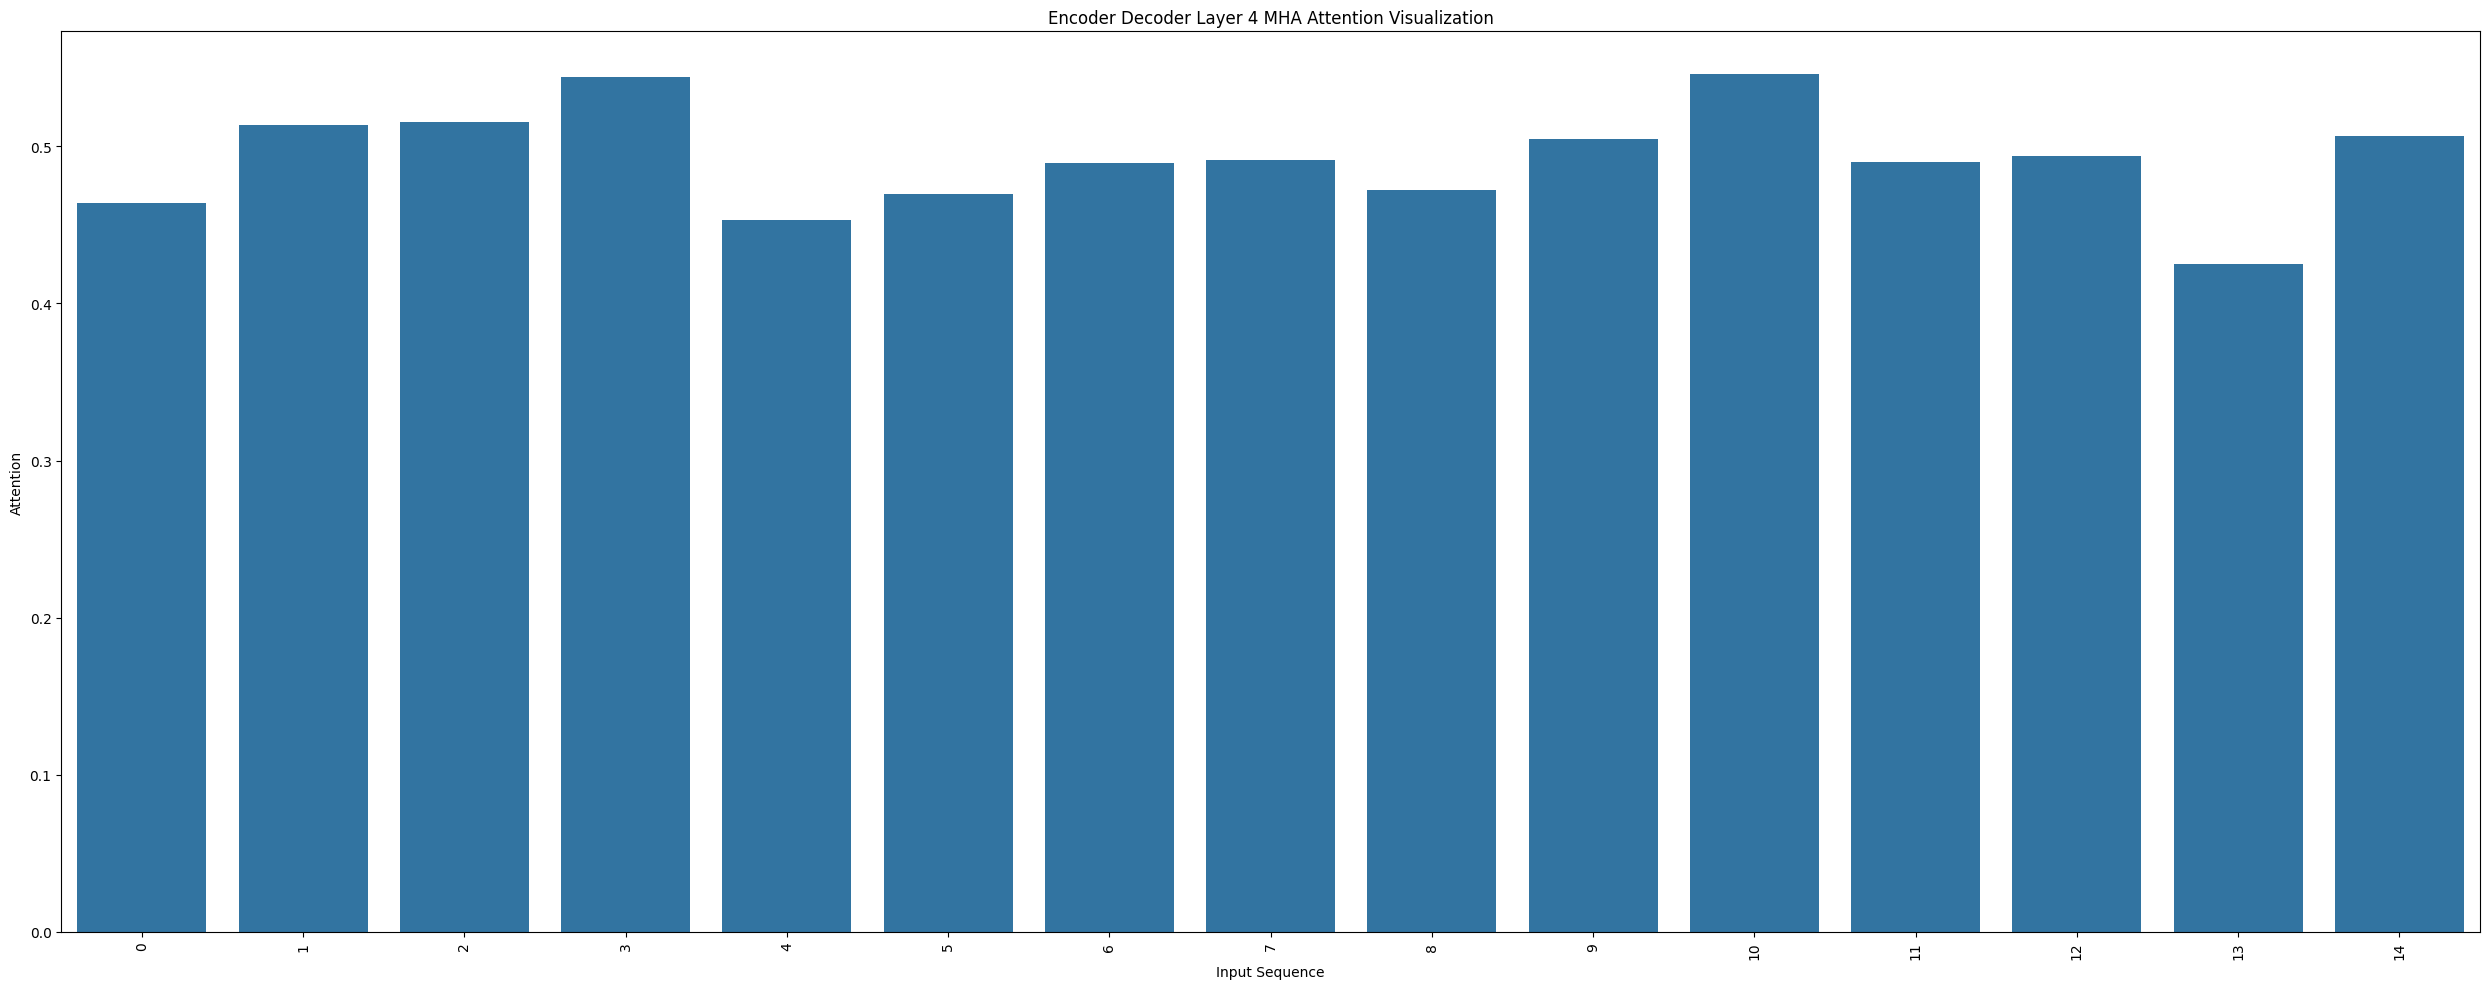

(48, 48)


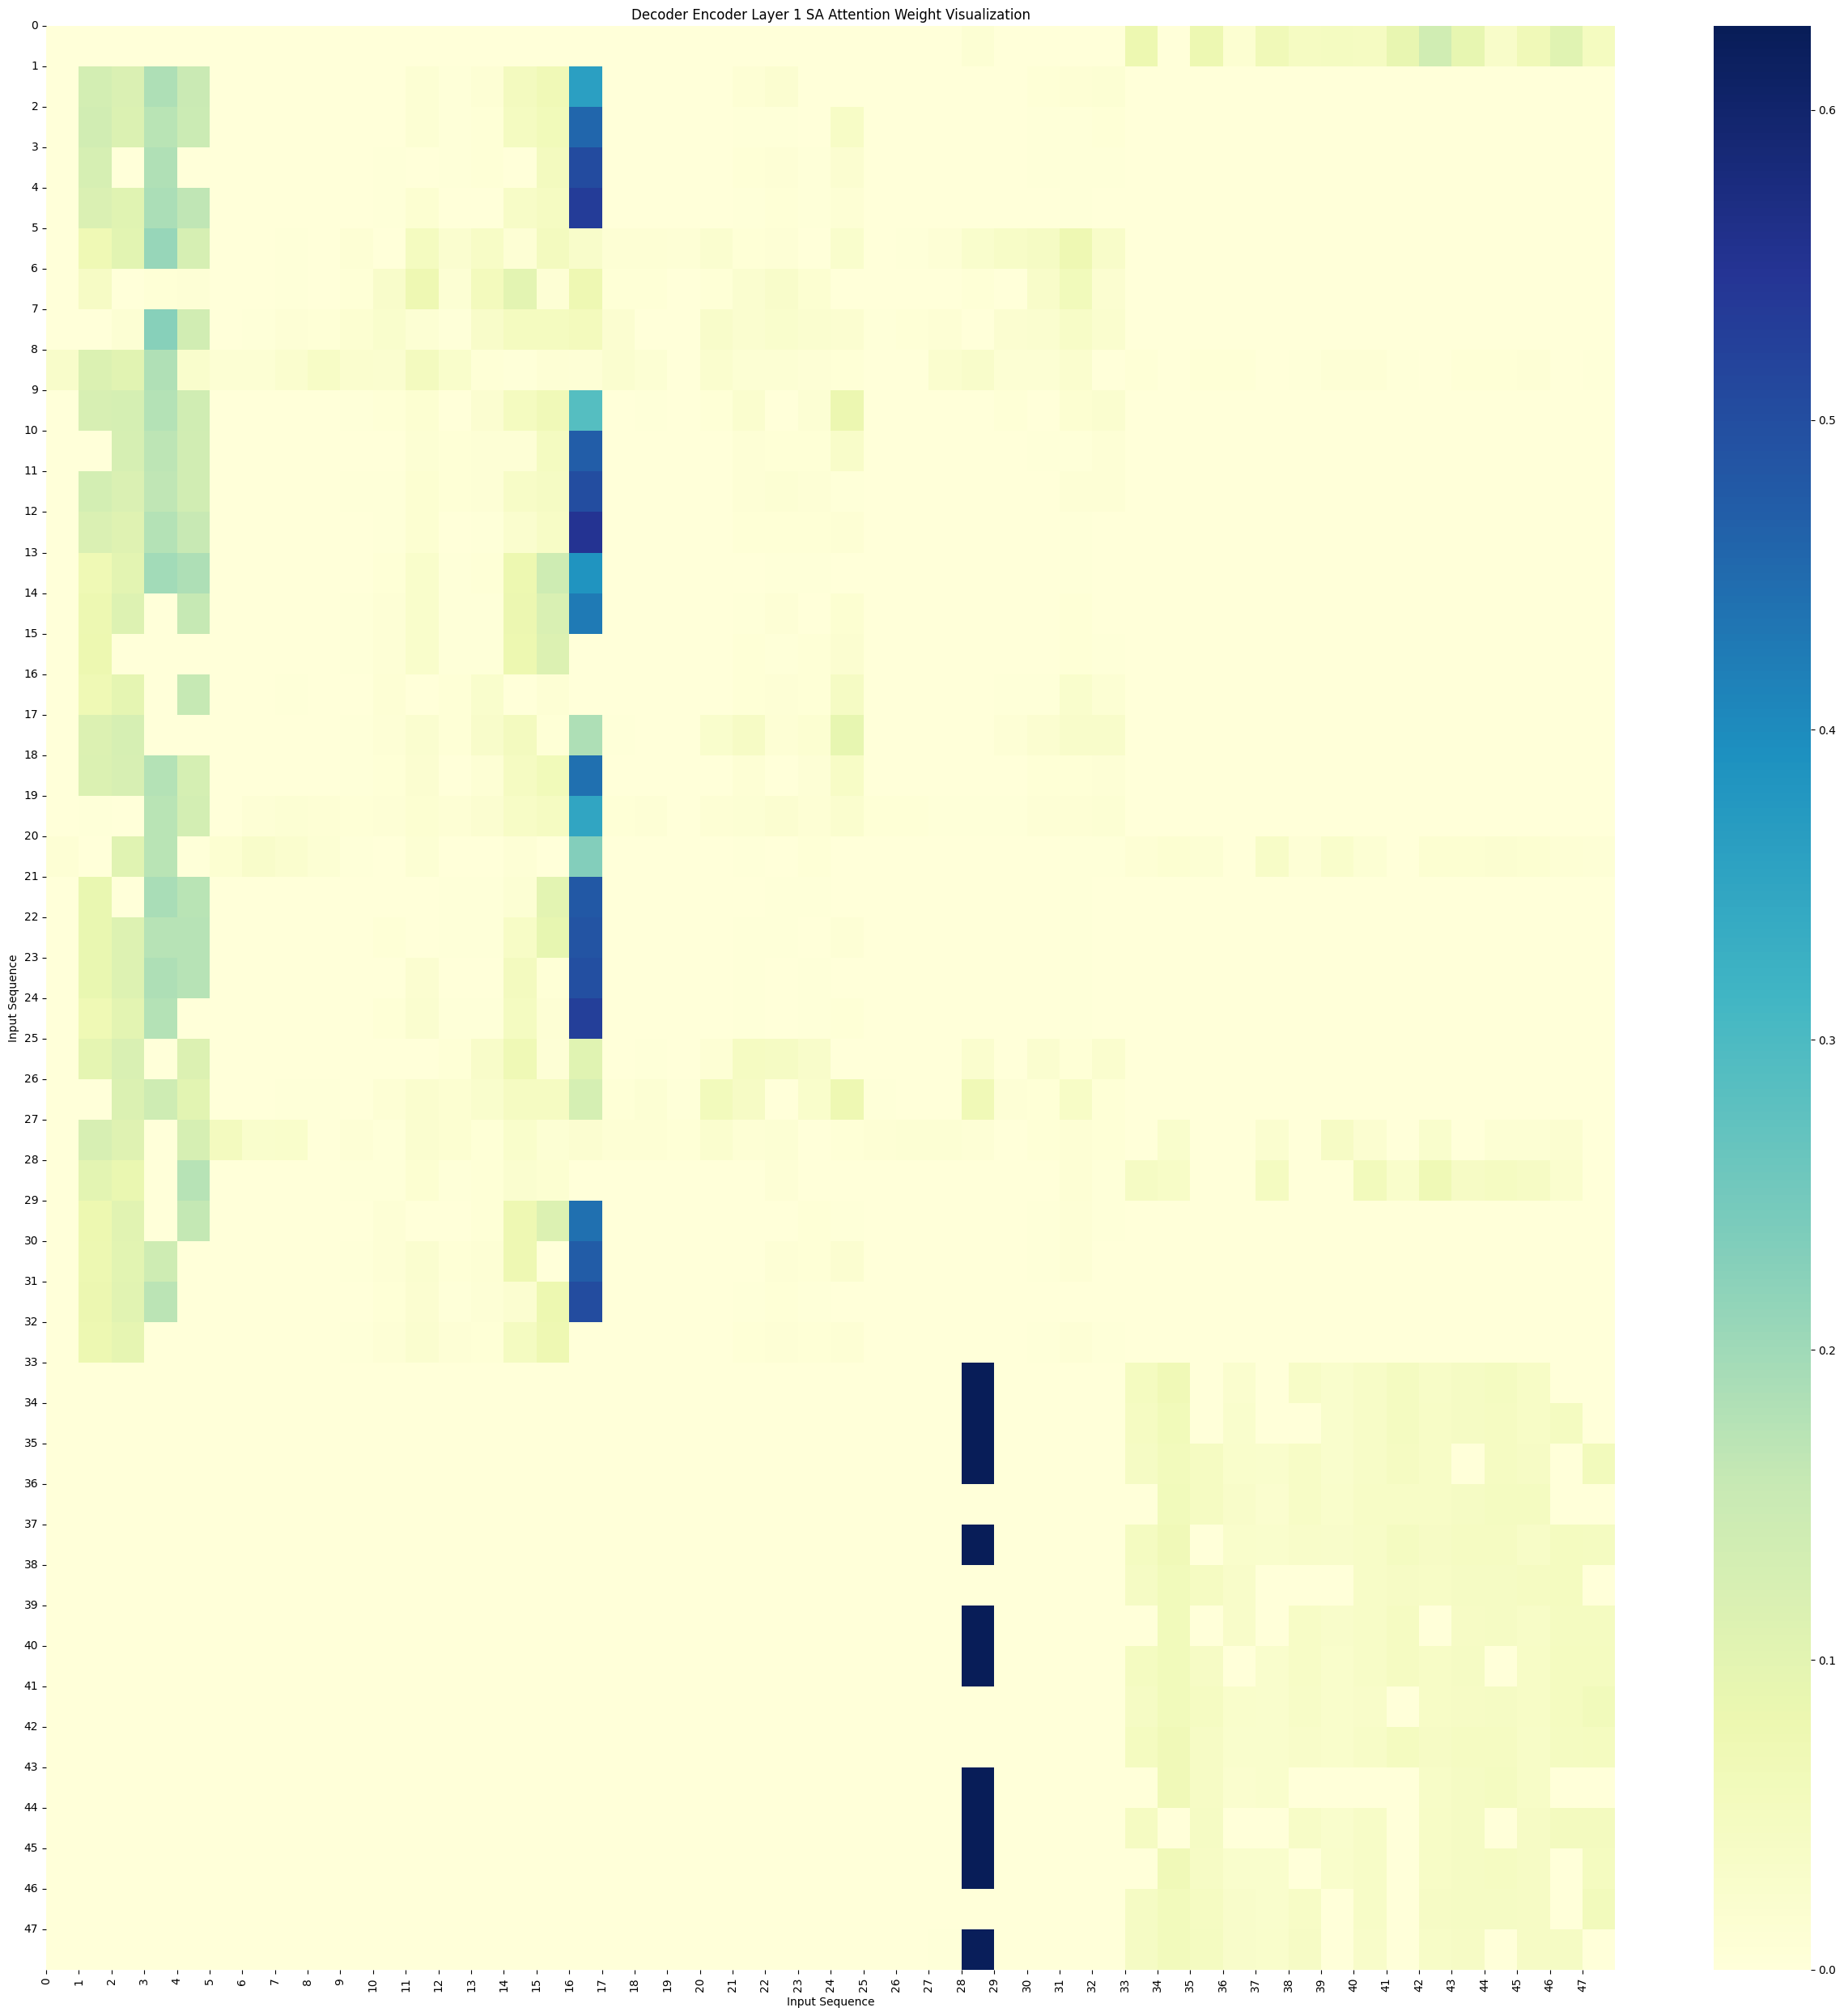

(48,)


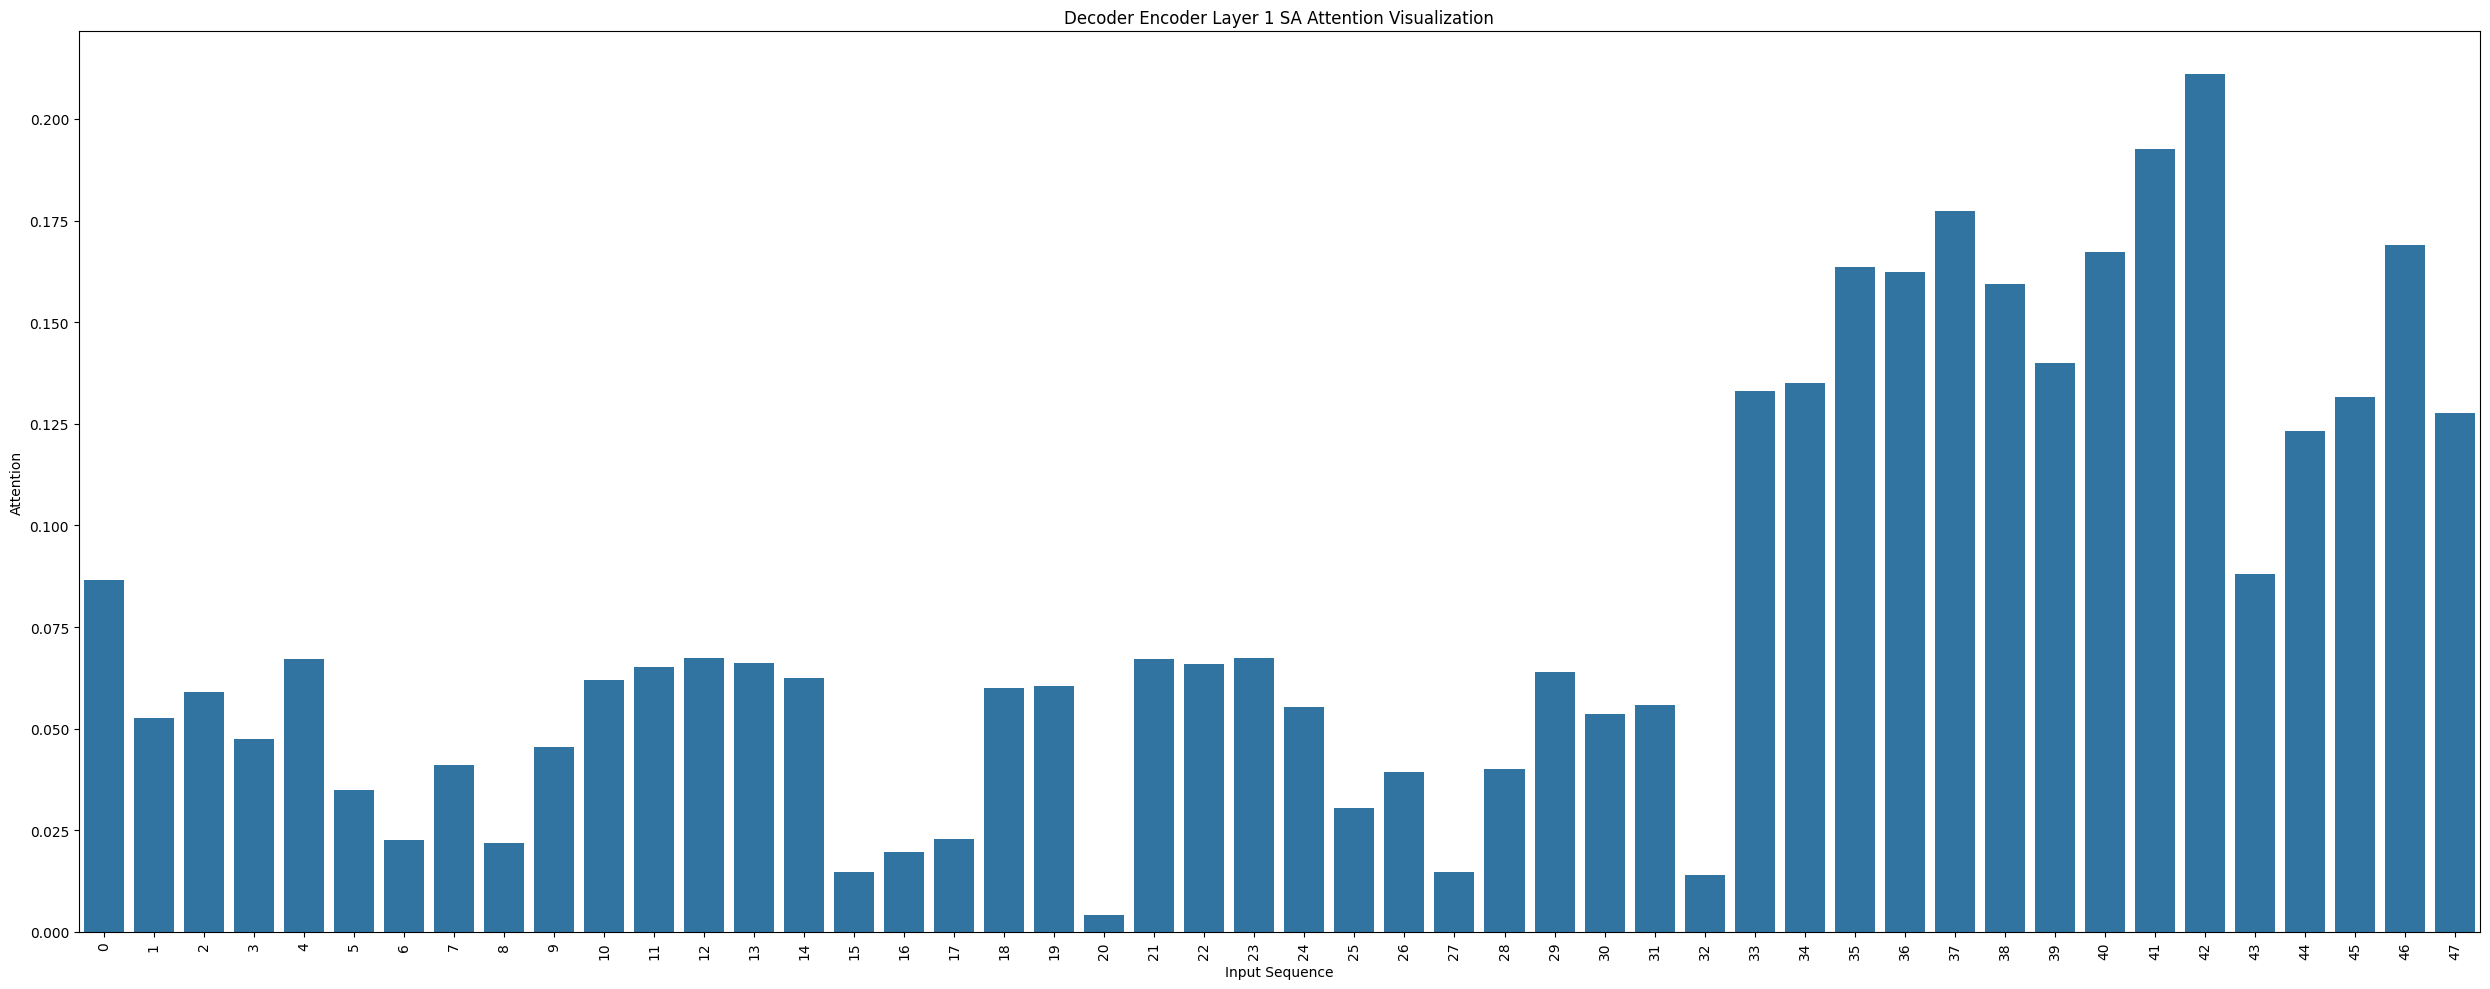

(48, 48)


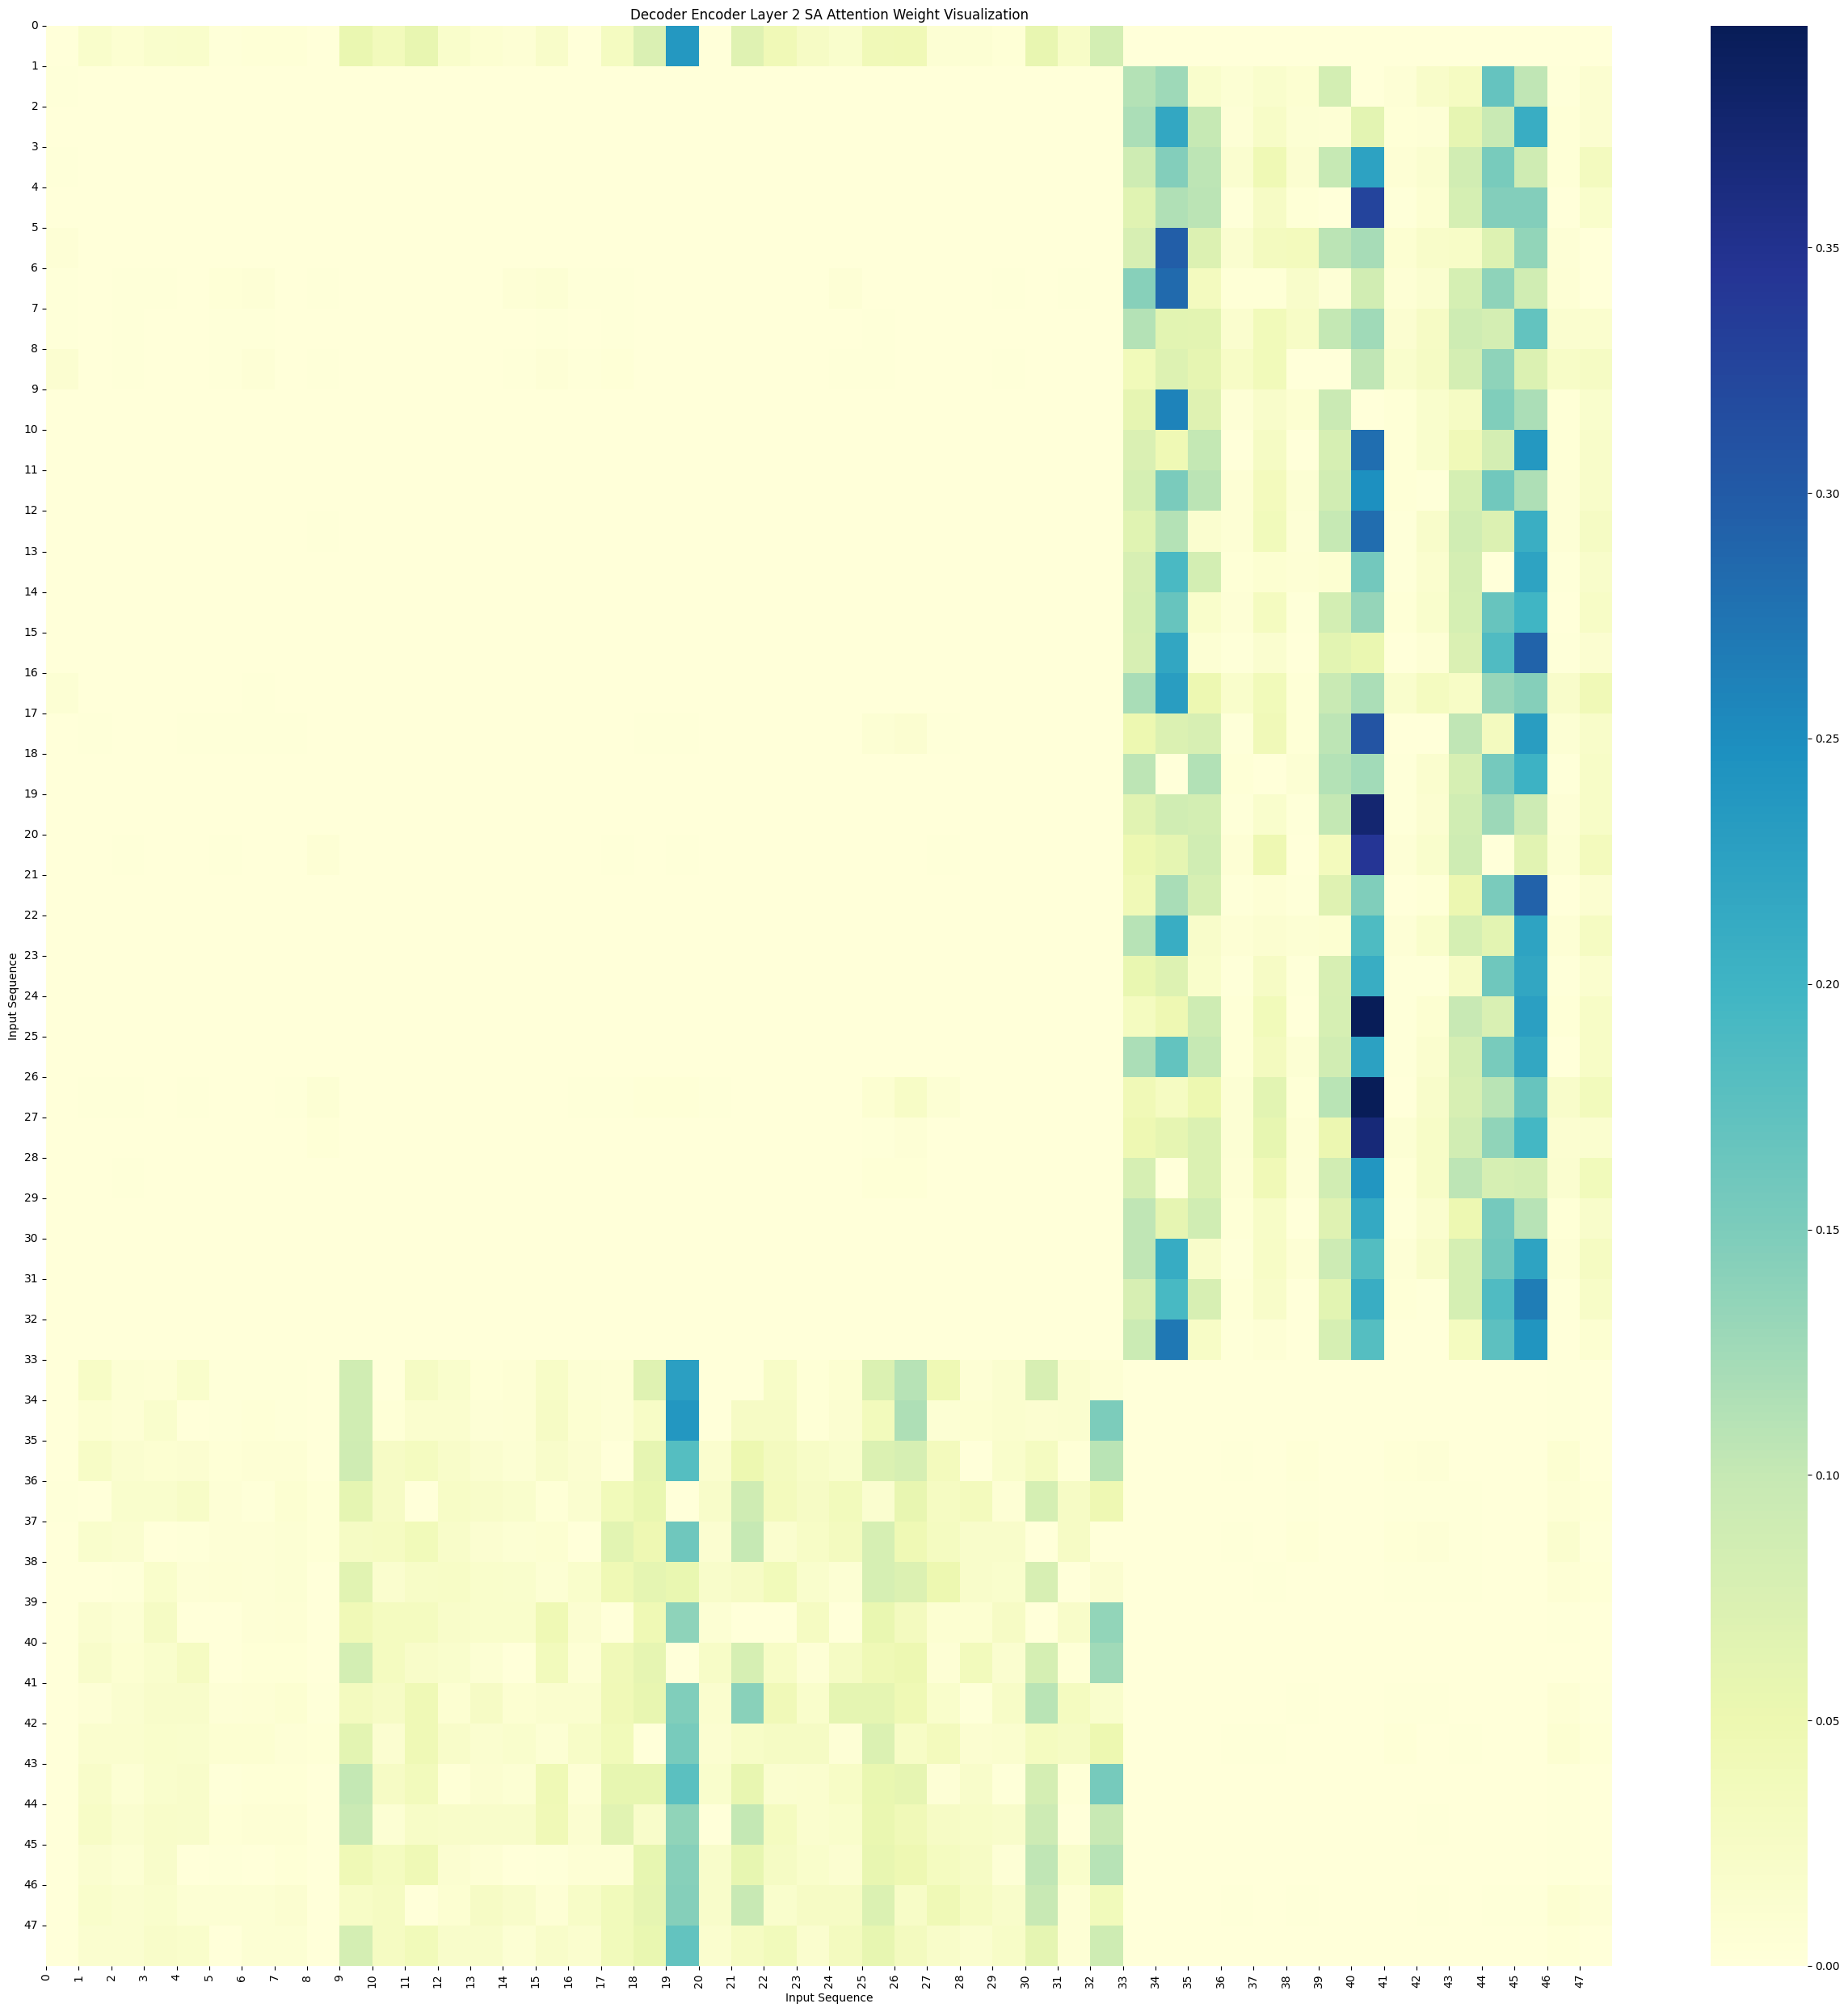

(48,)


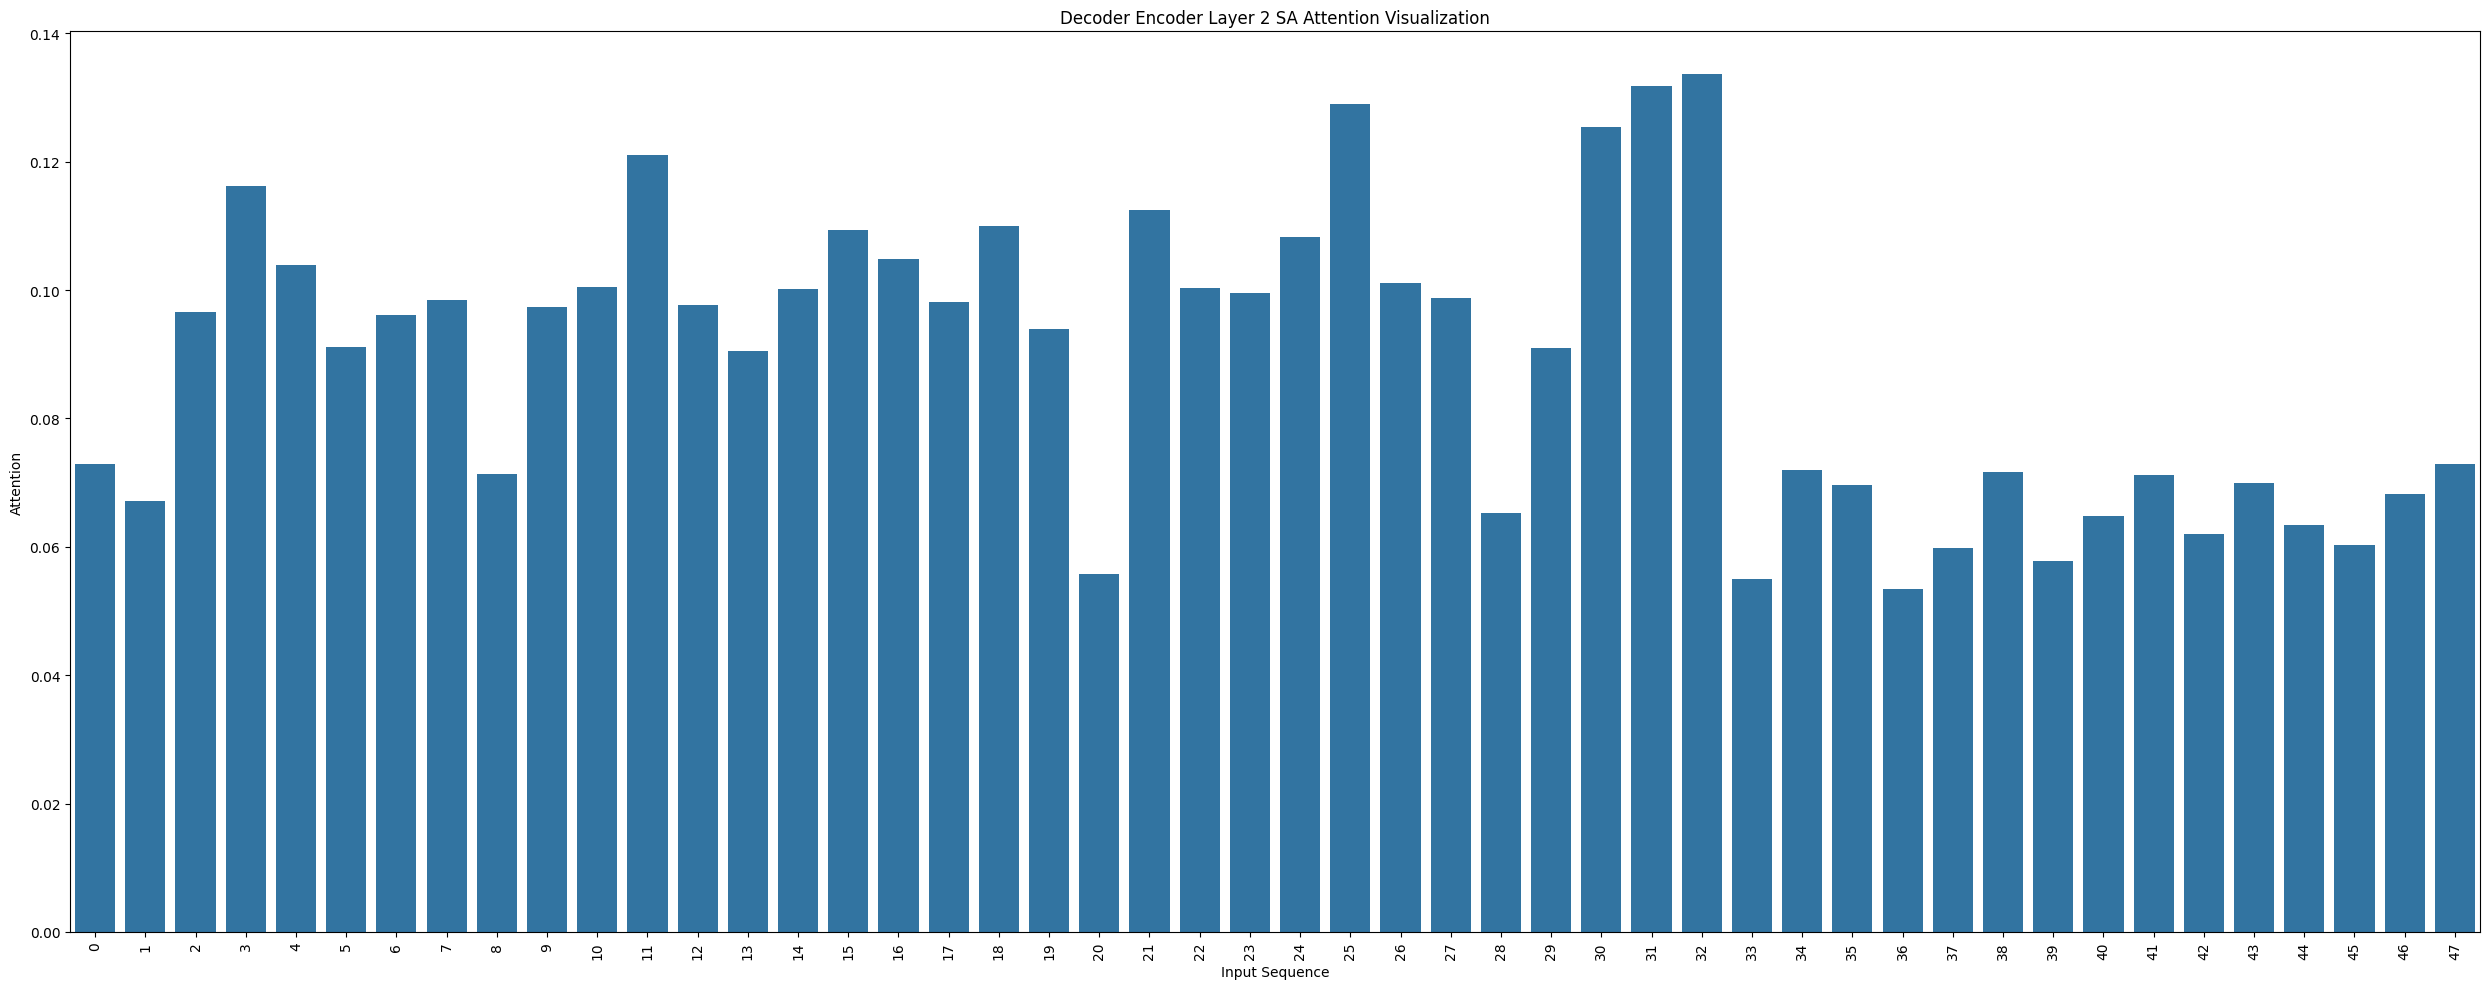

(142, 142)


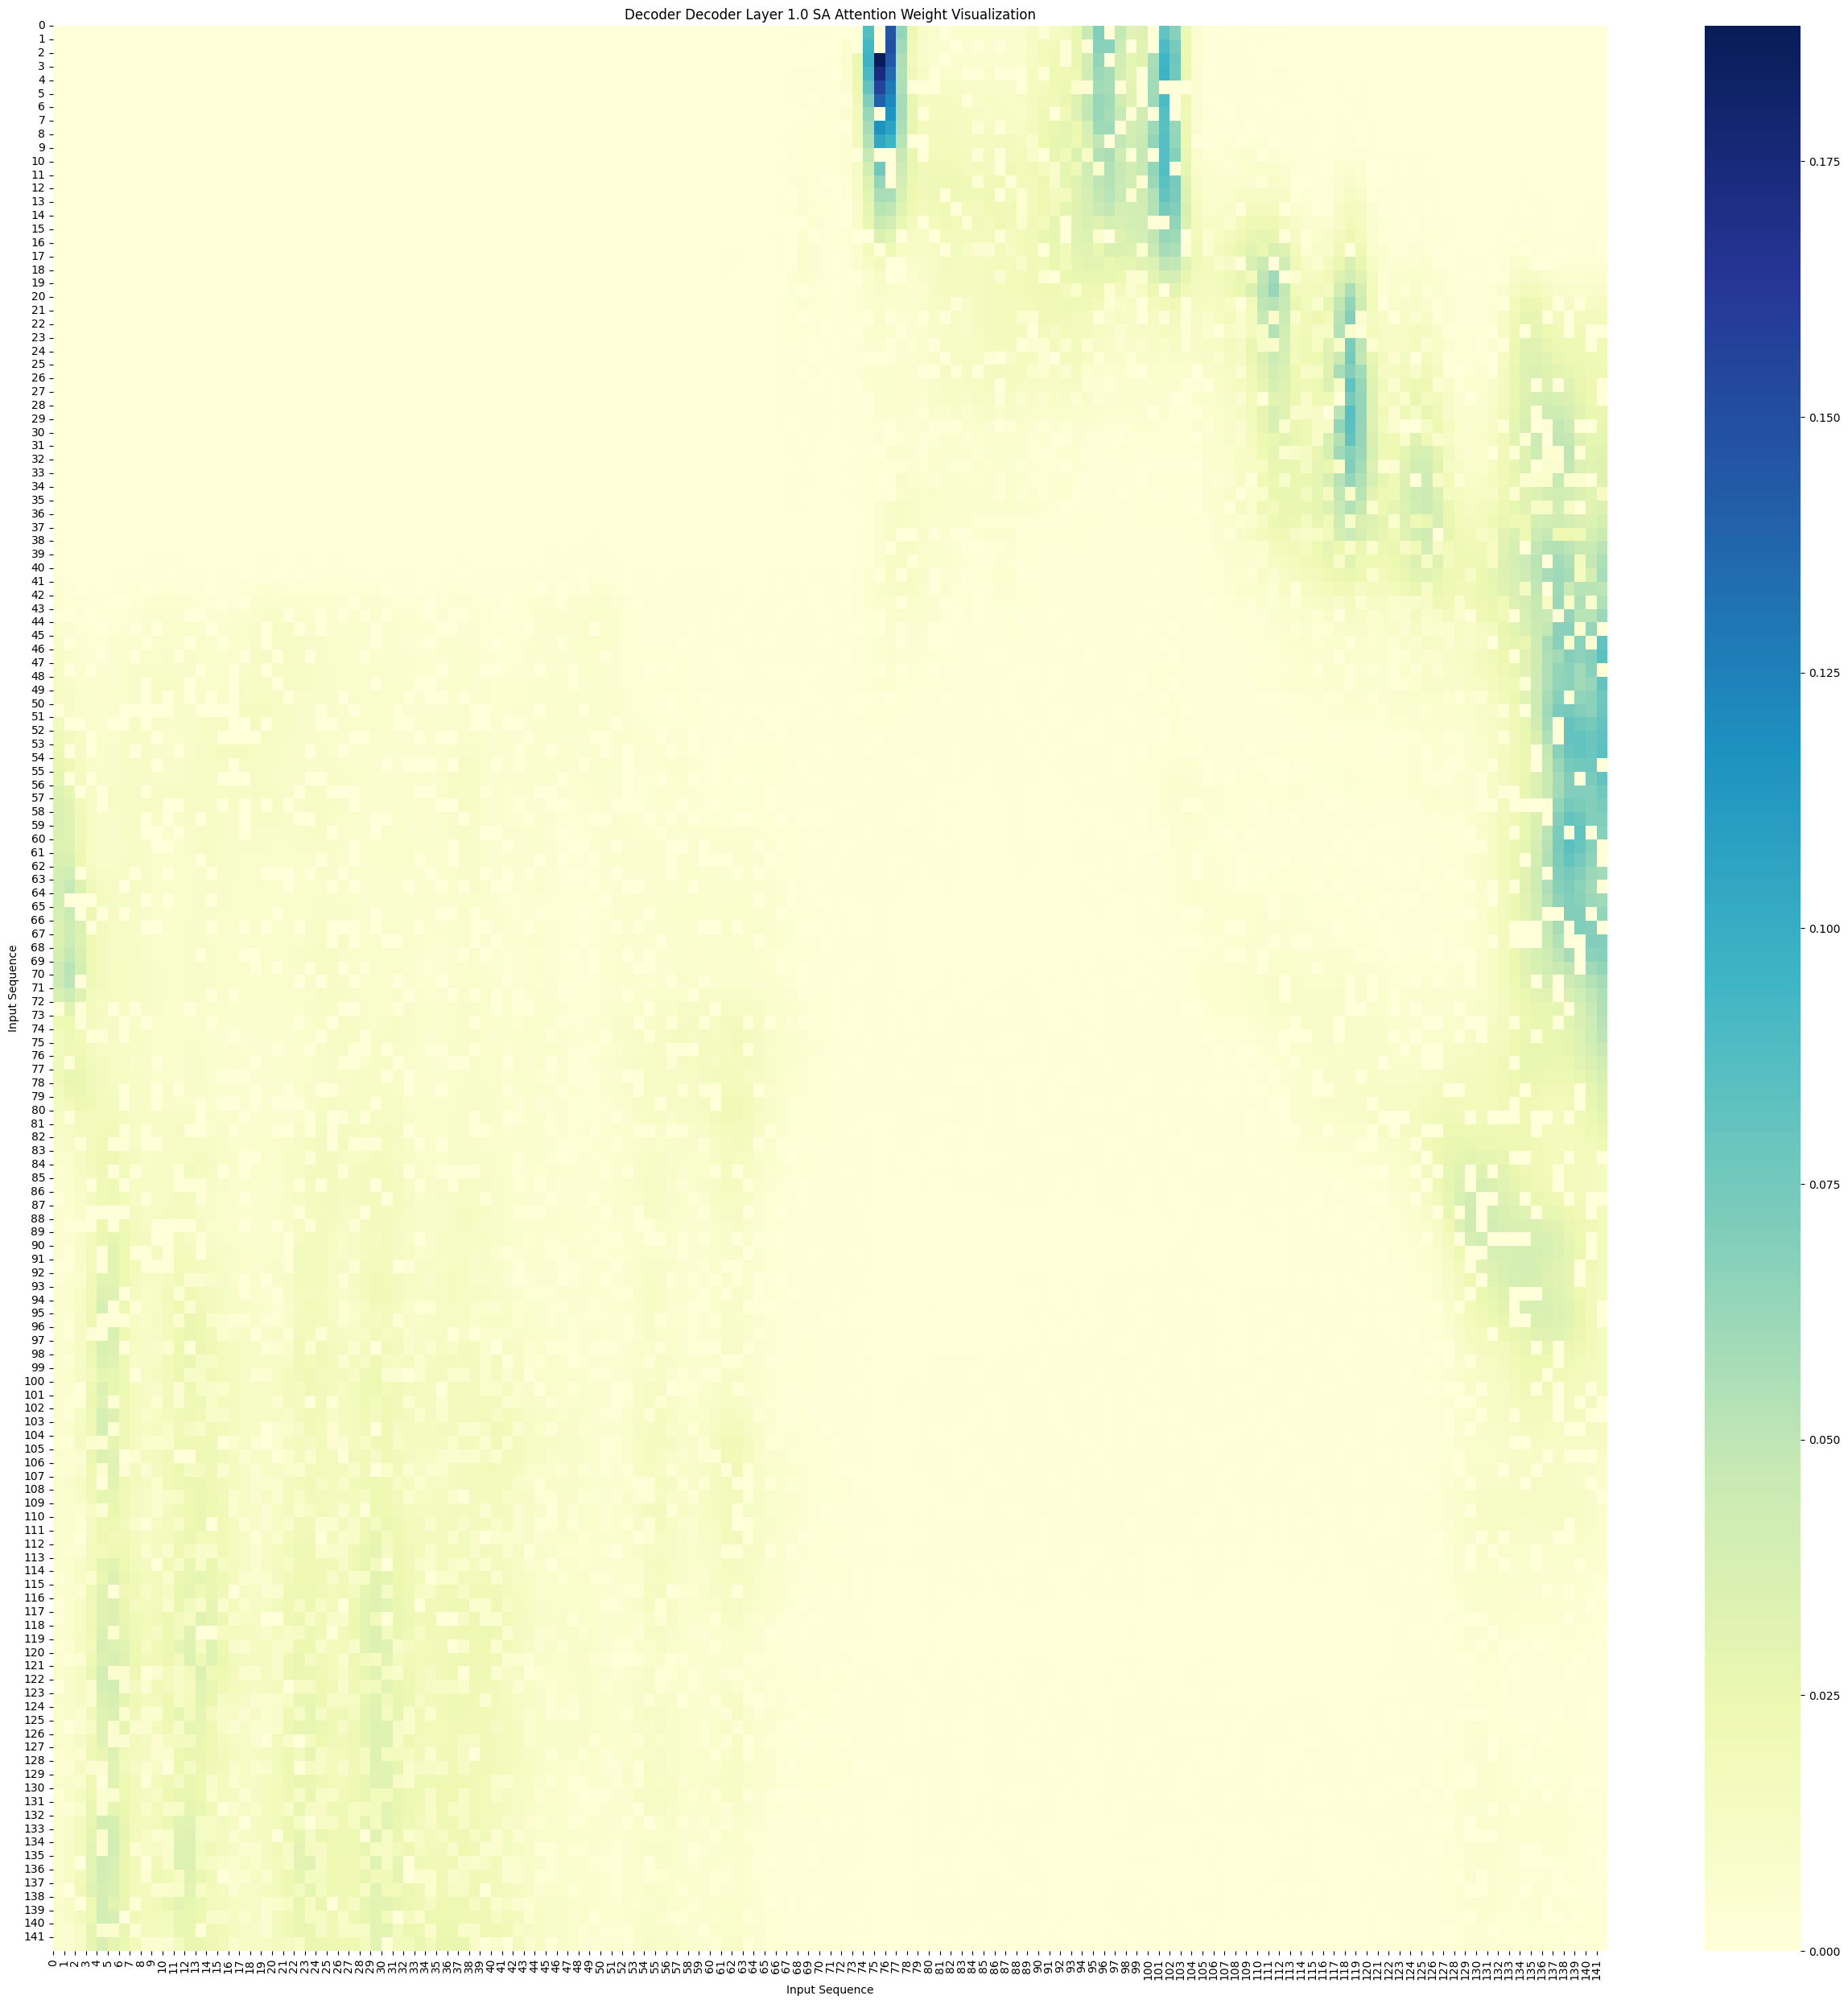

(142,)


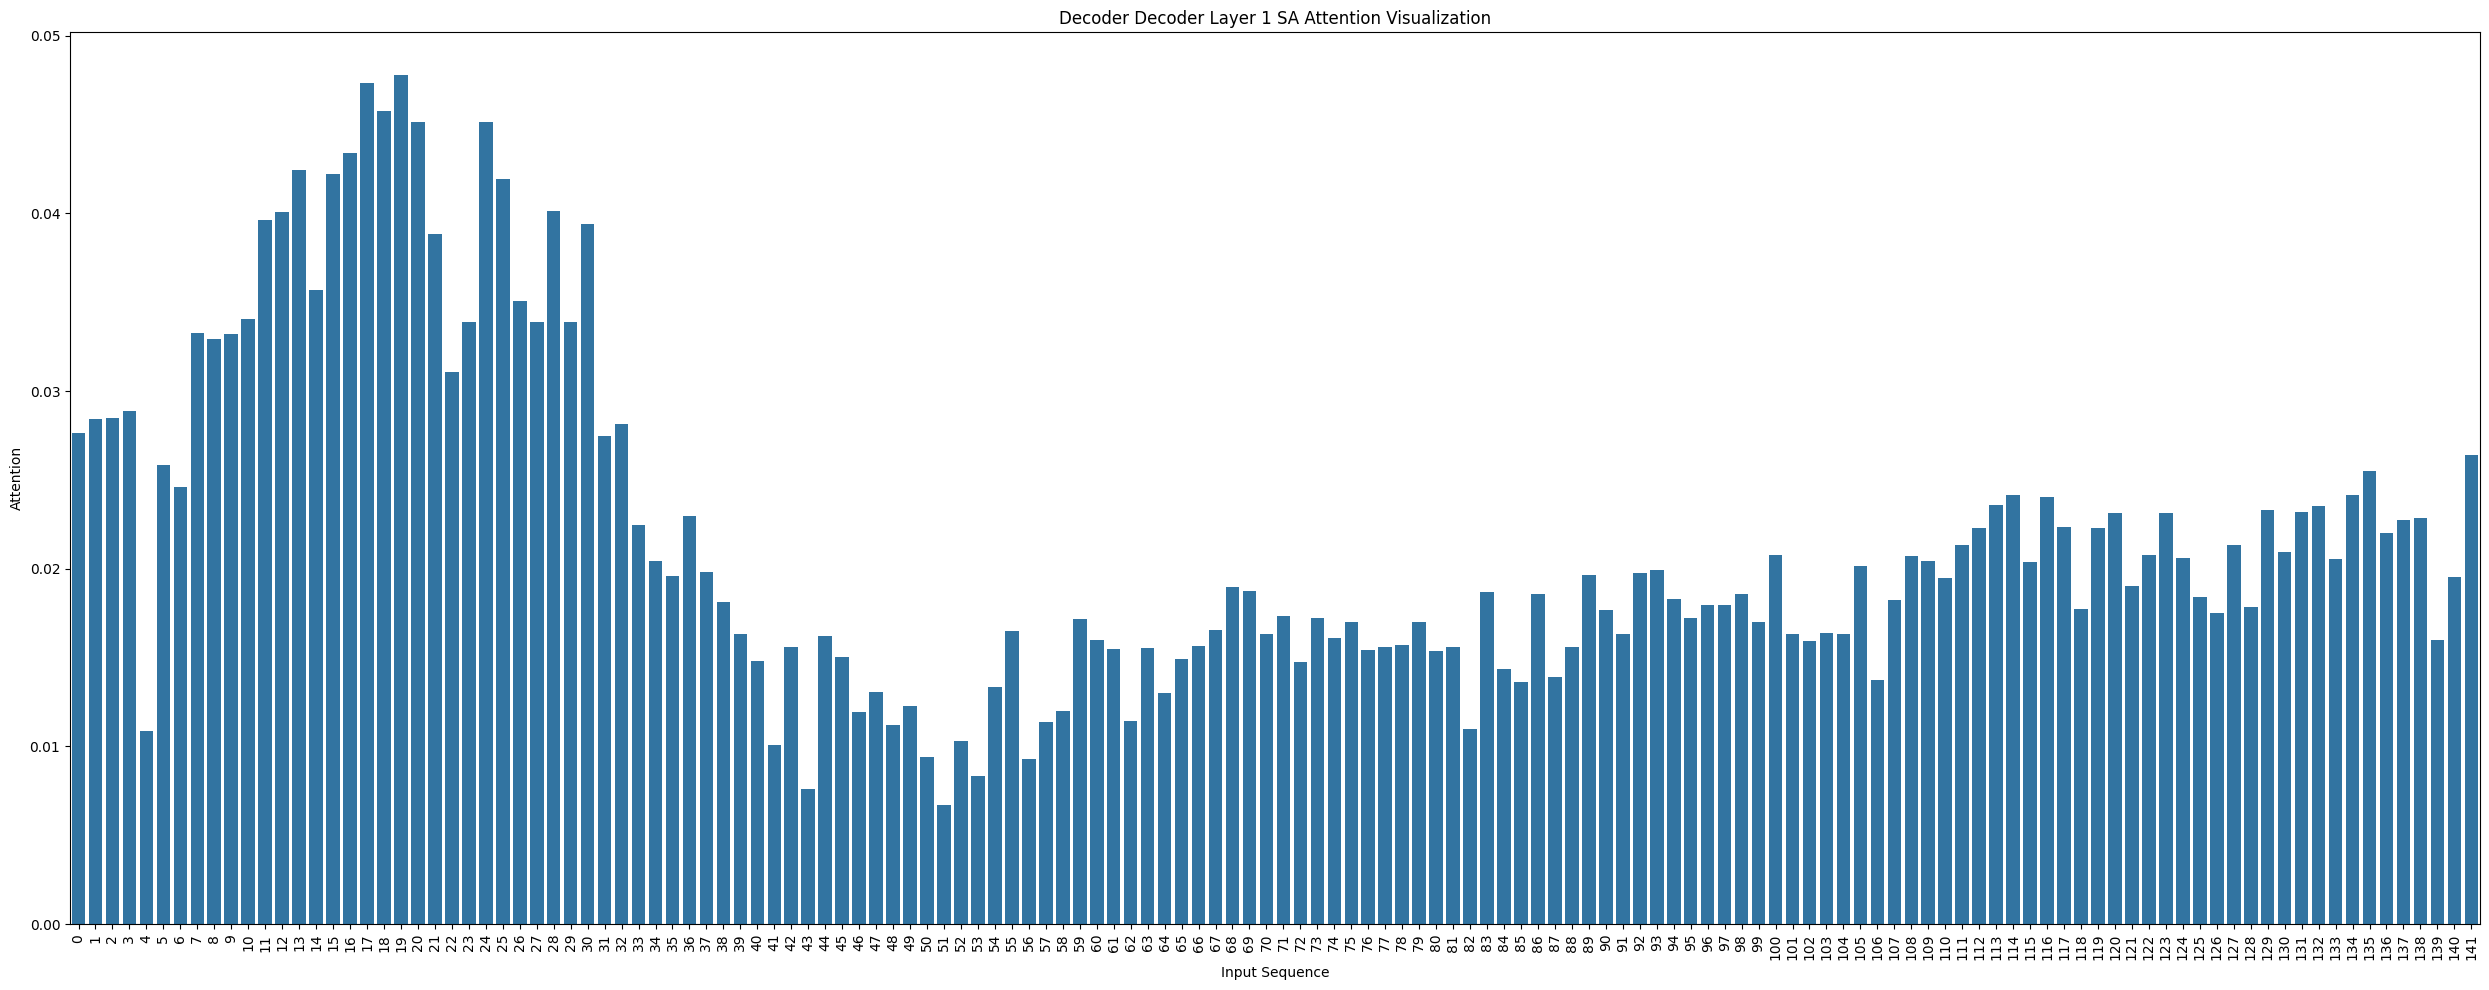

(142, 48)


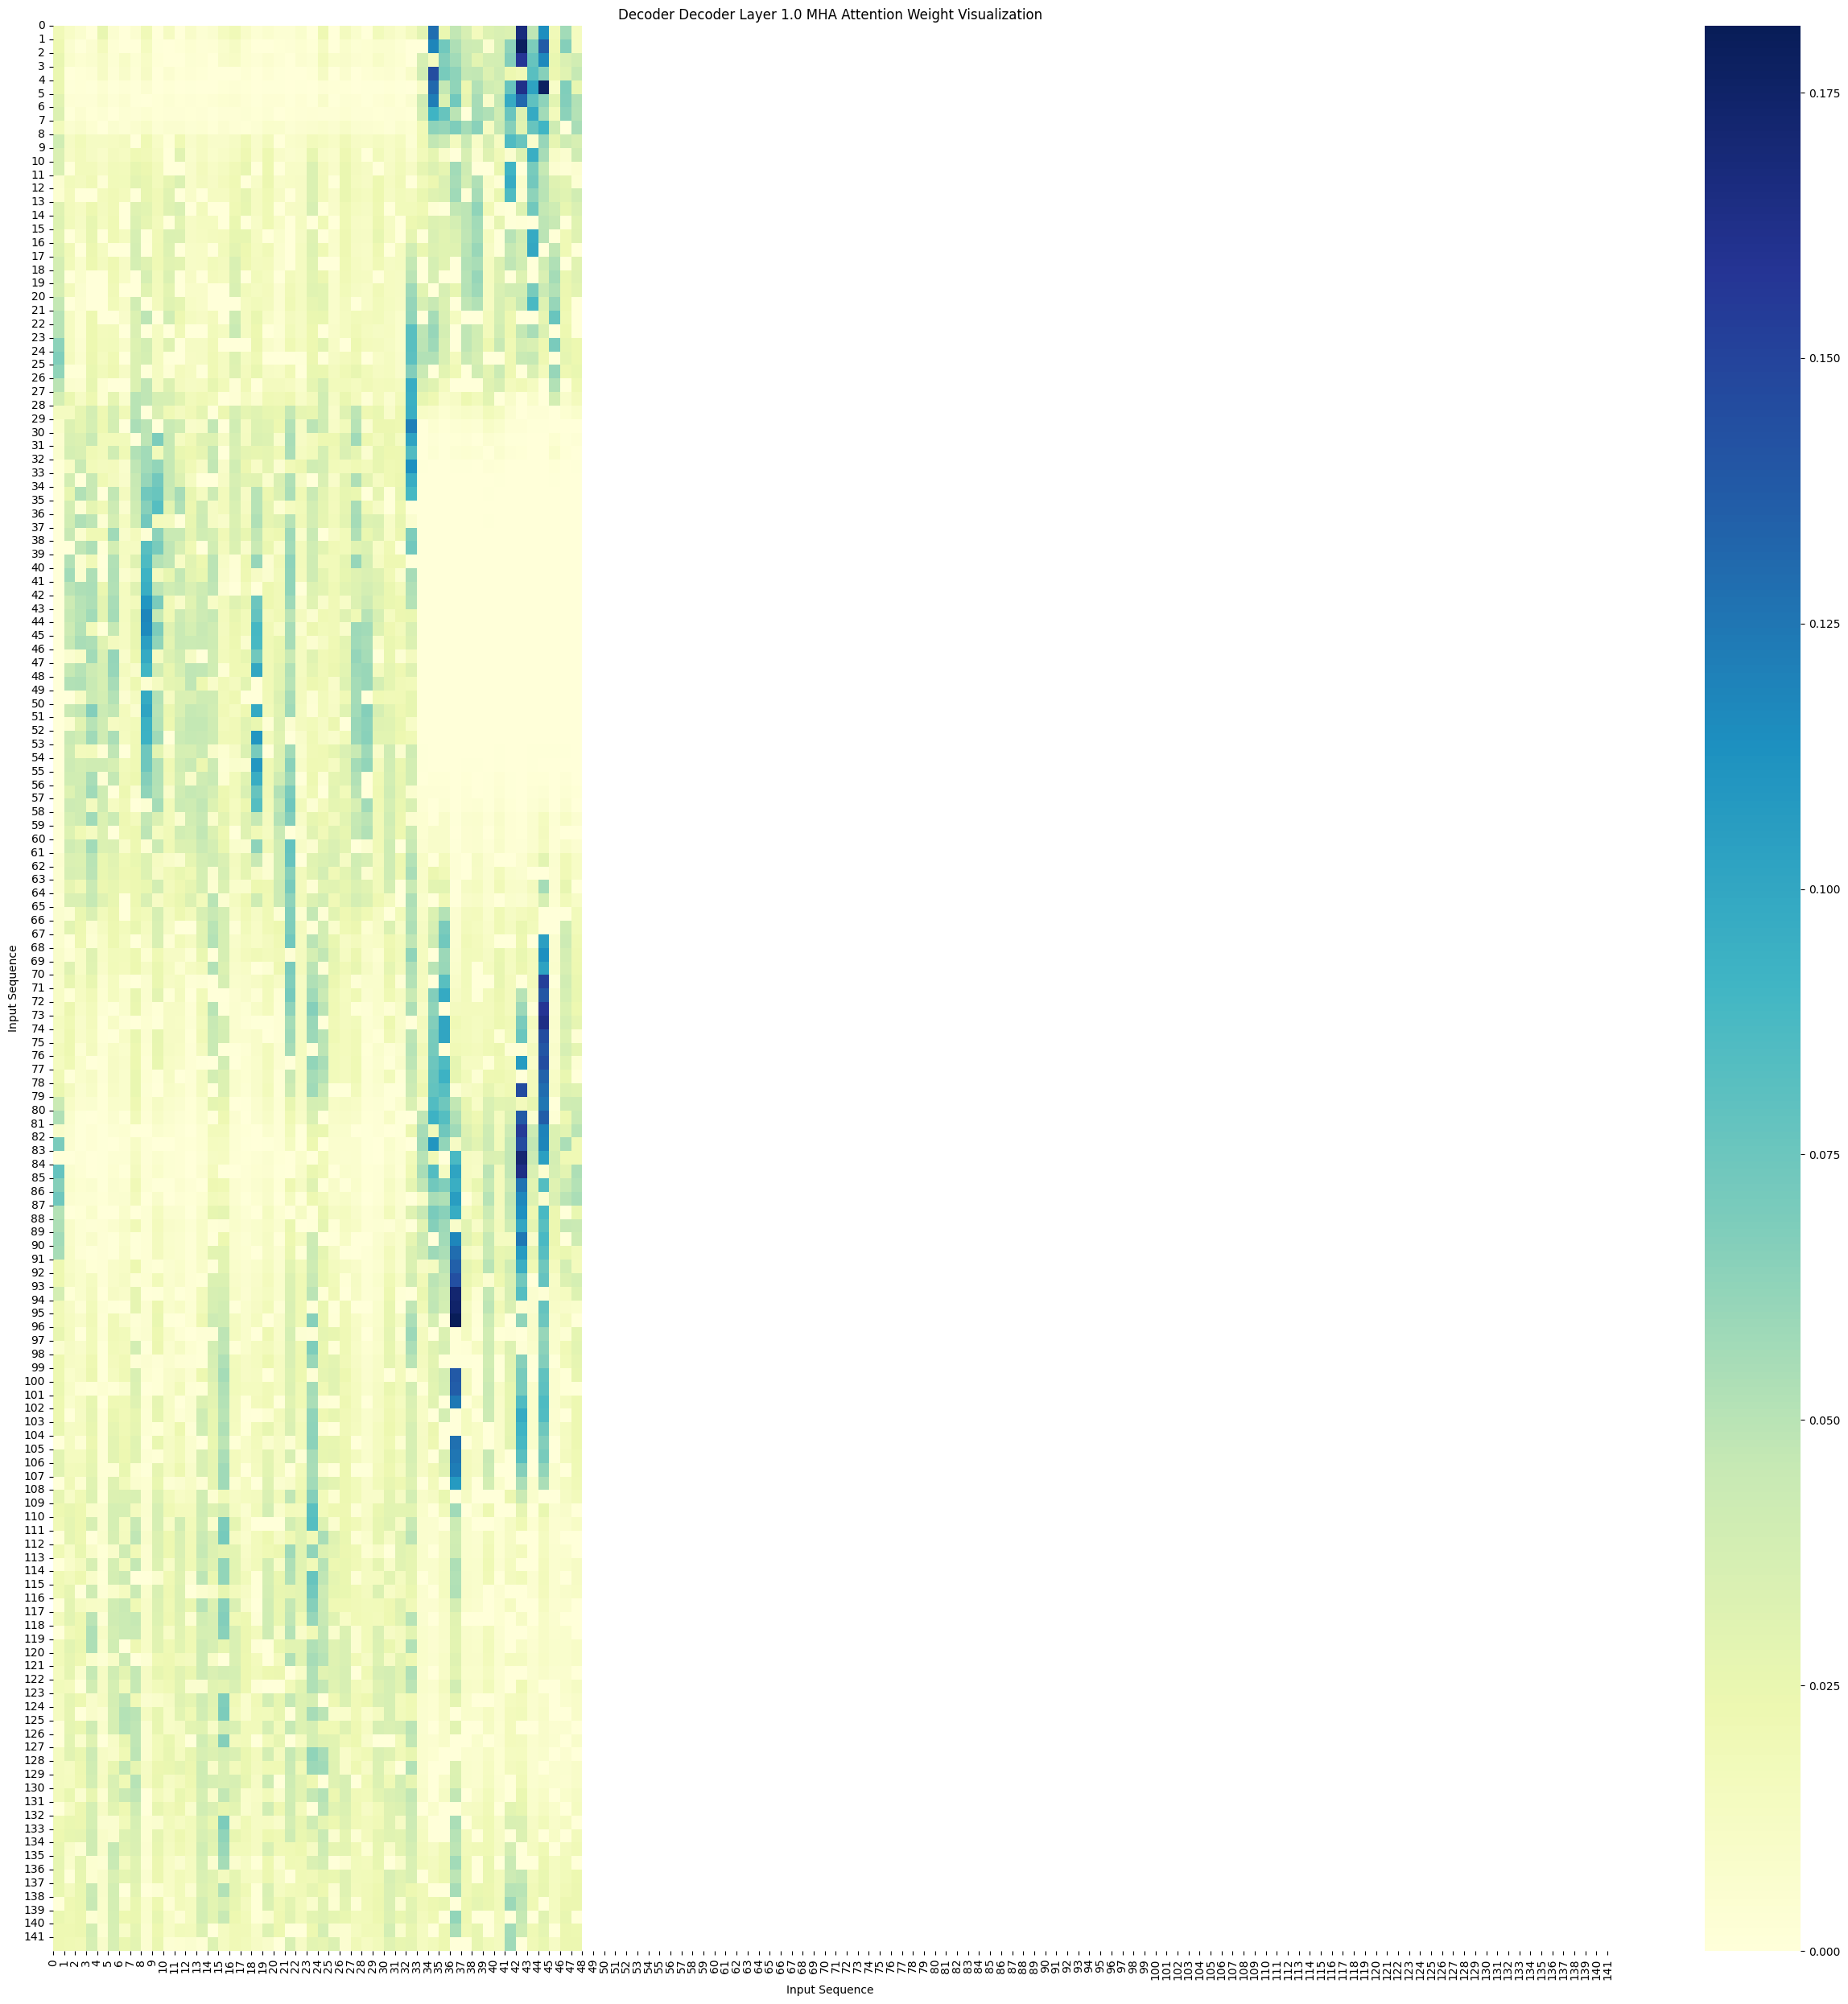

(142,)


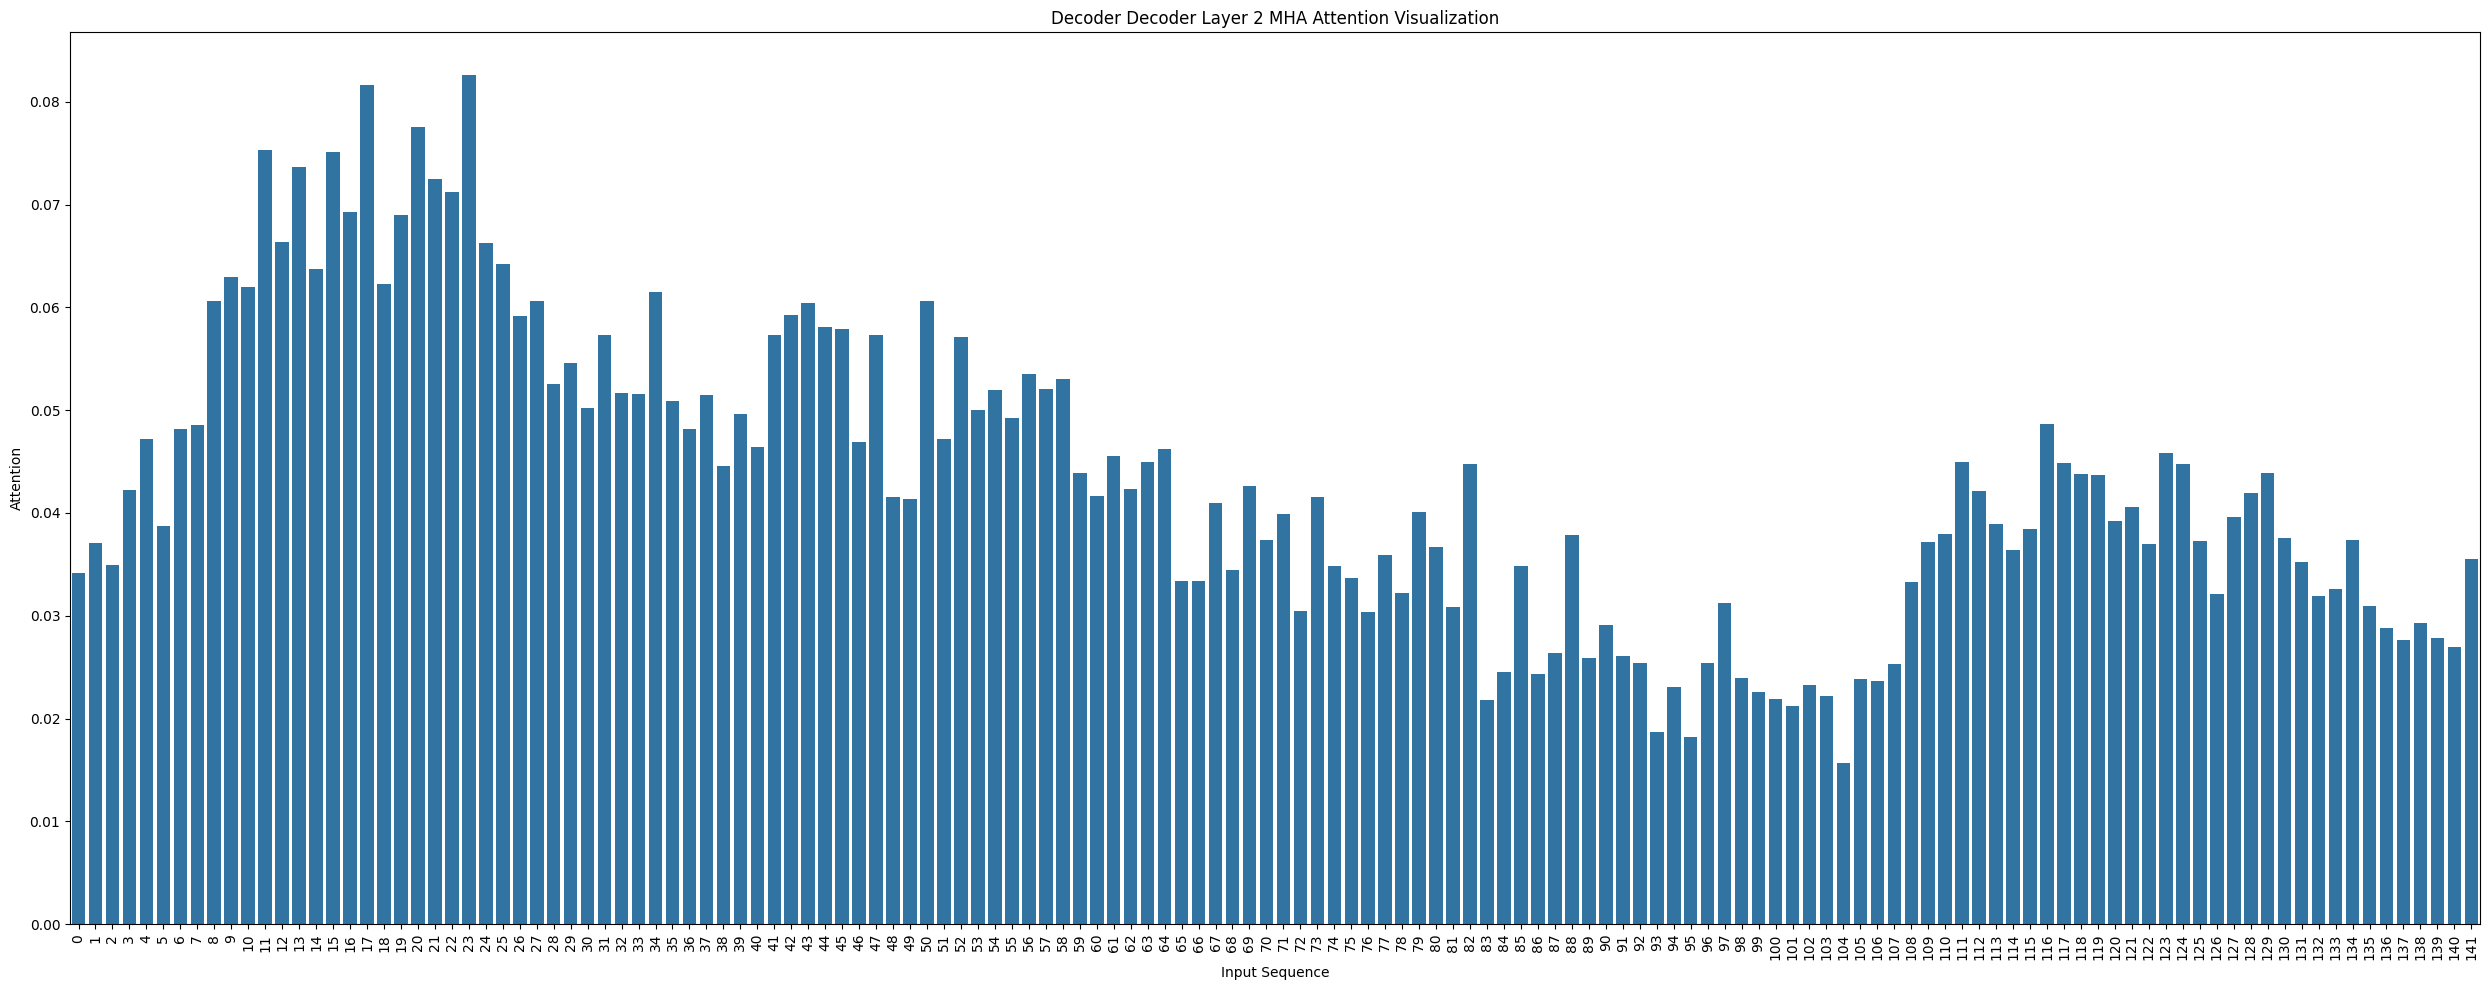

(142, 142)


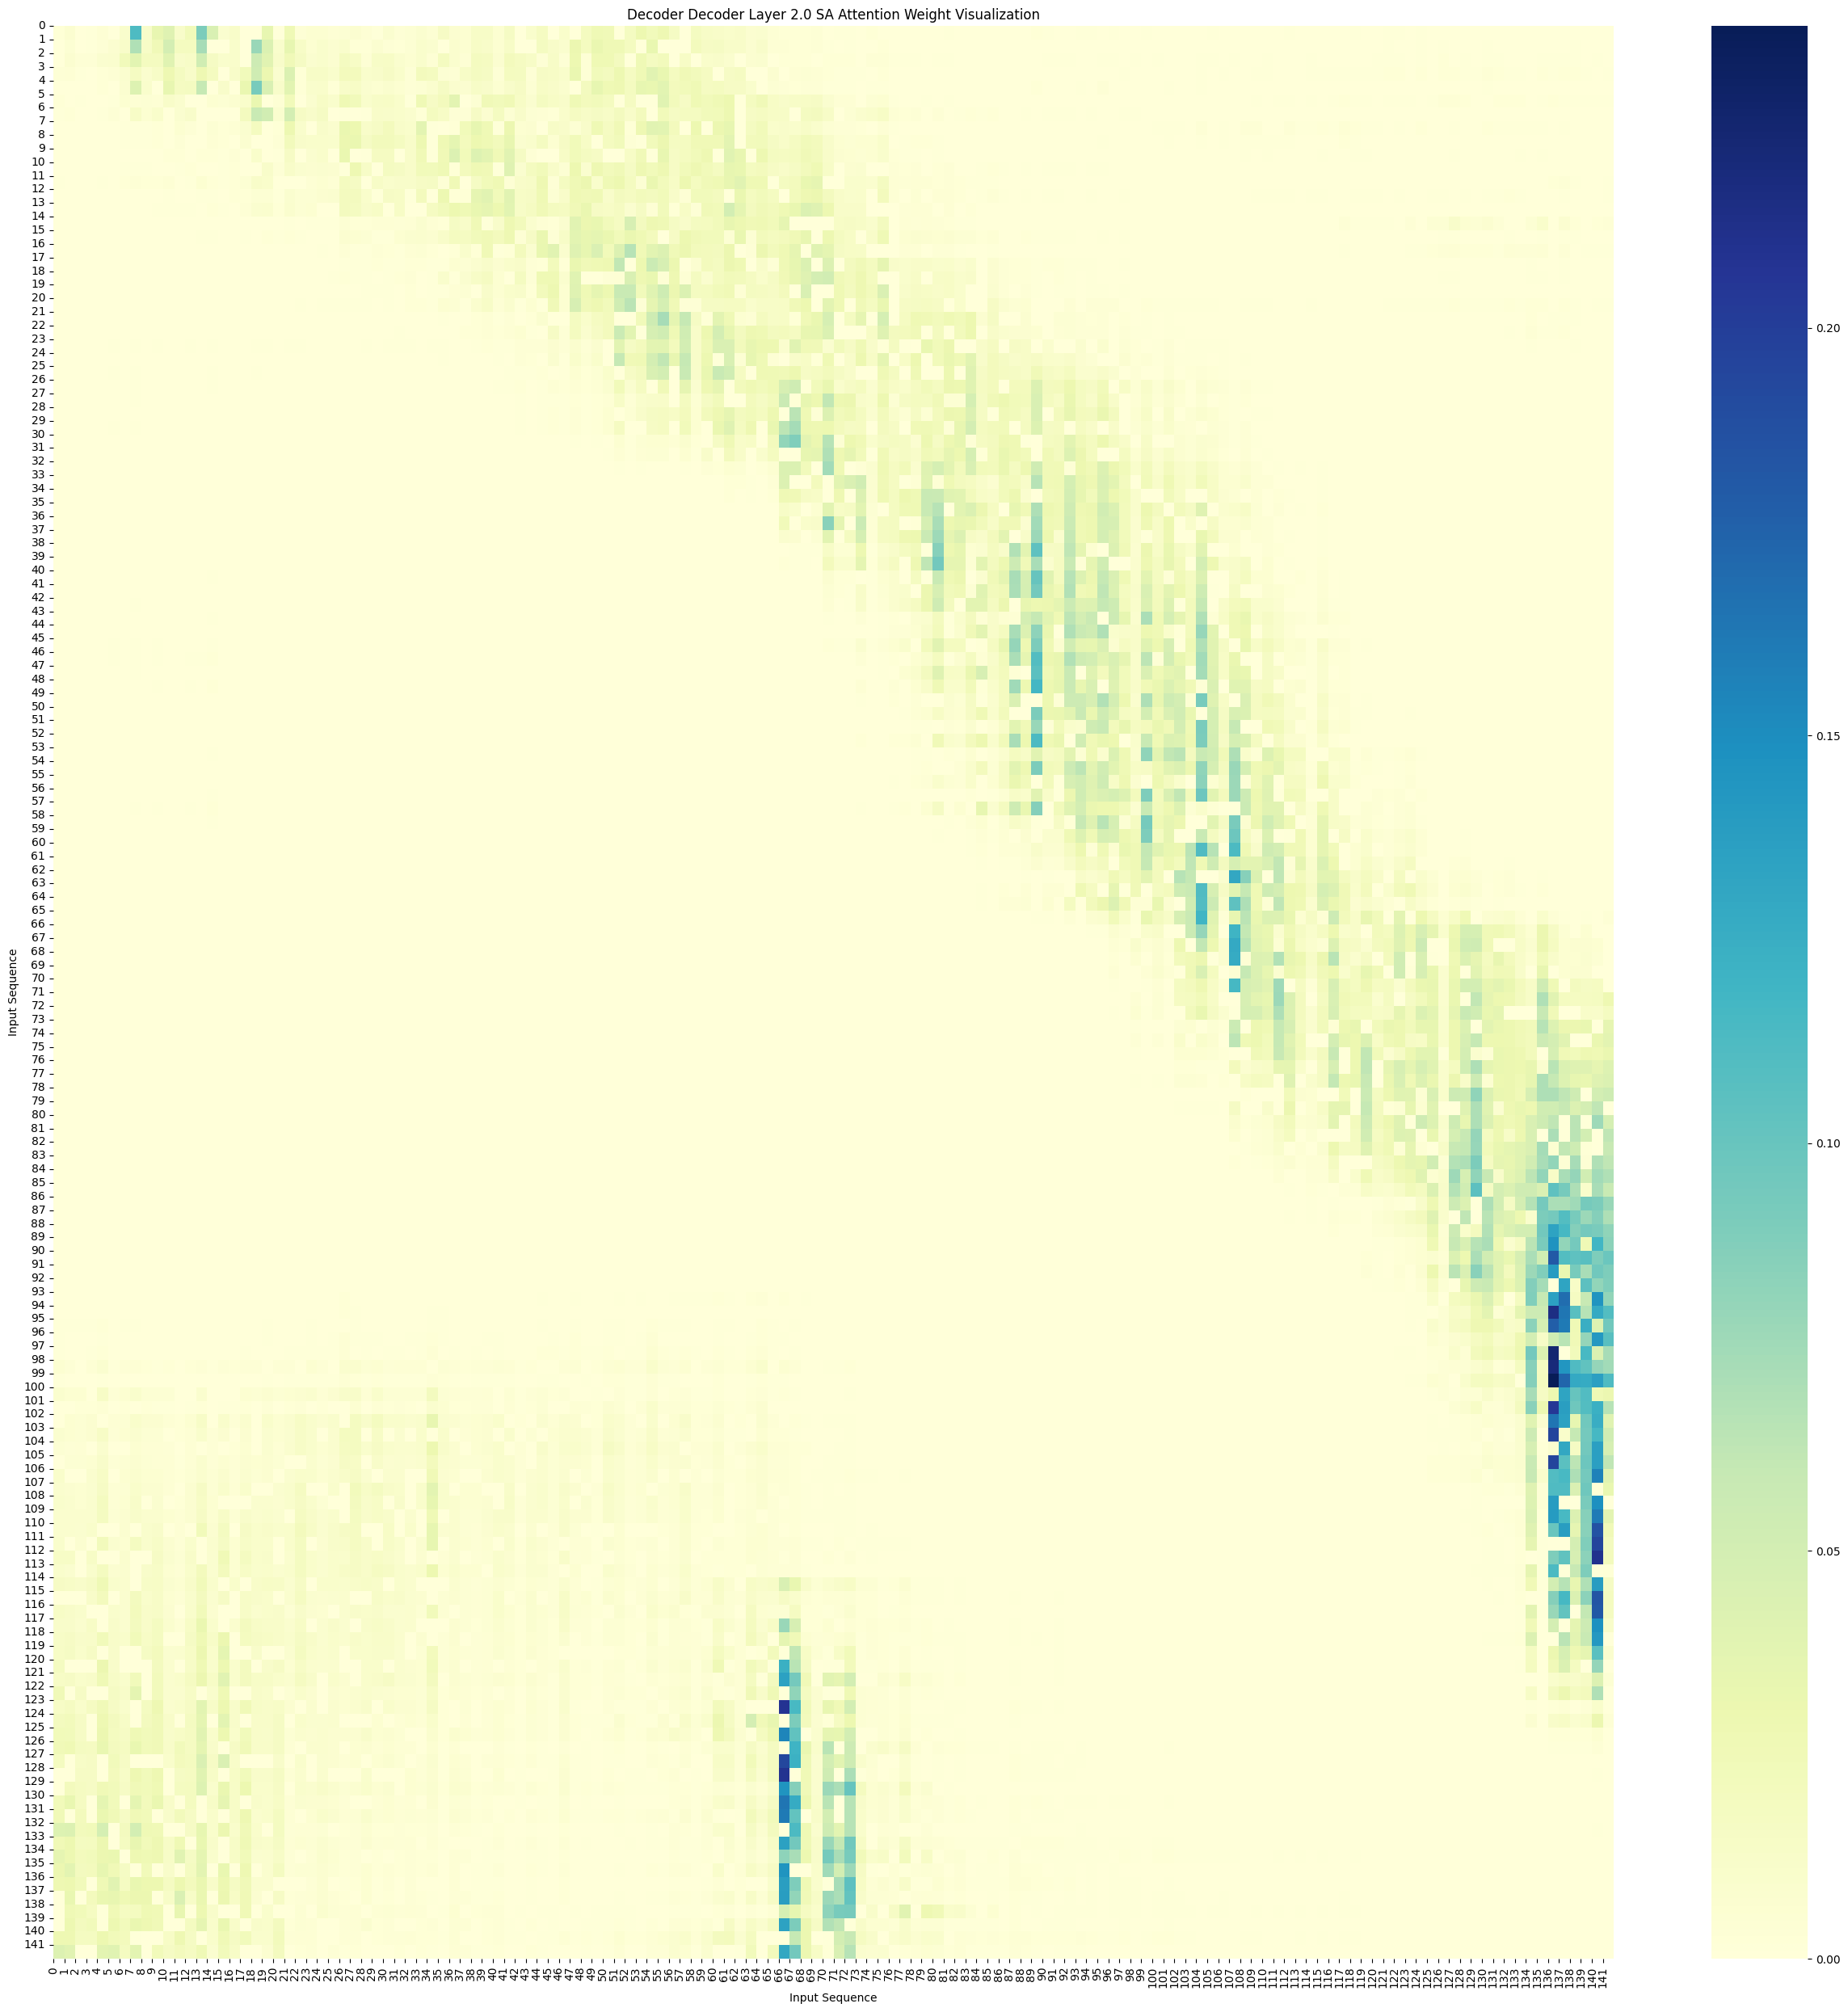

(142,)


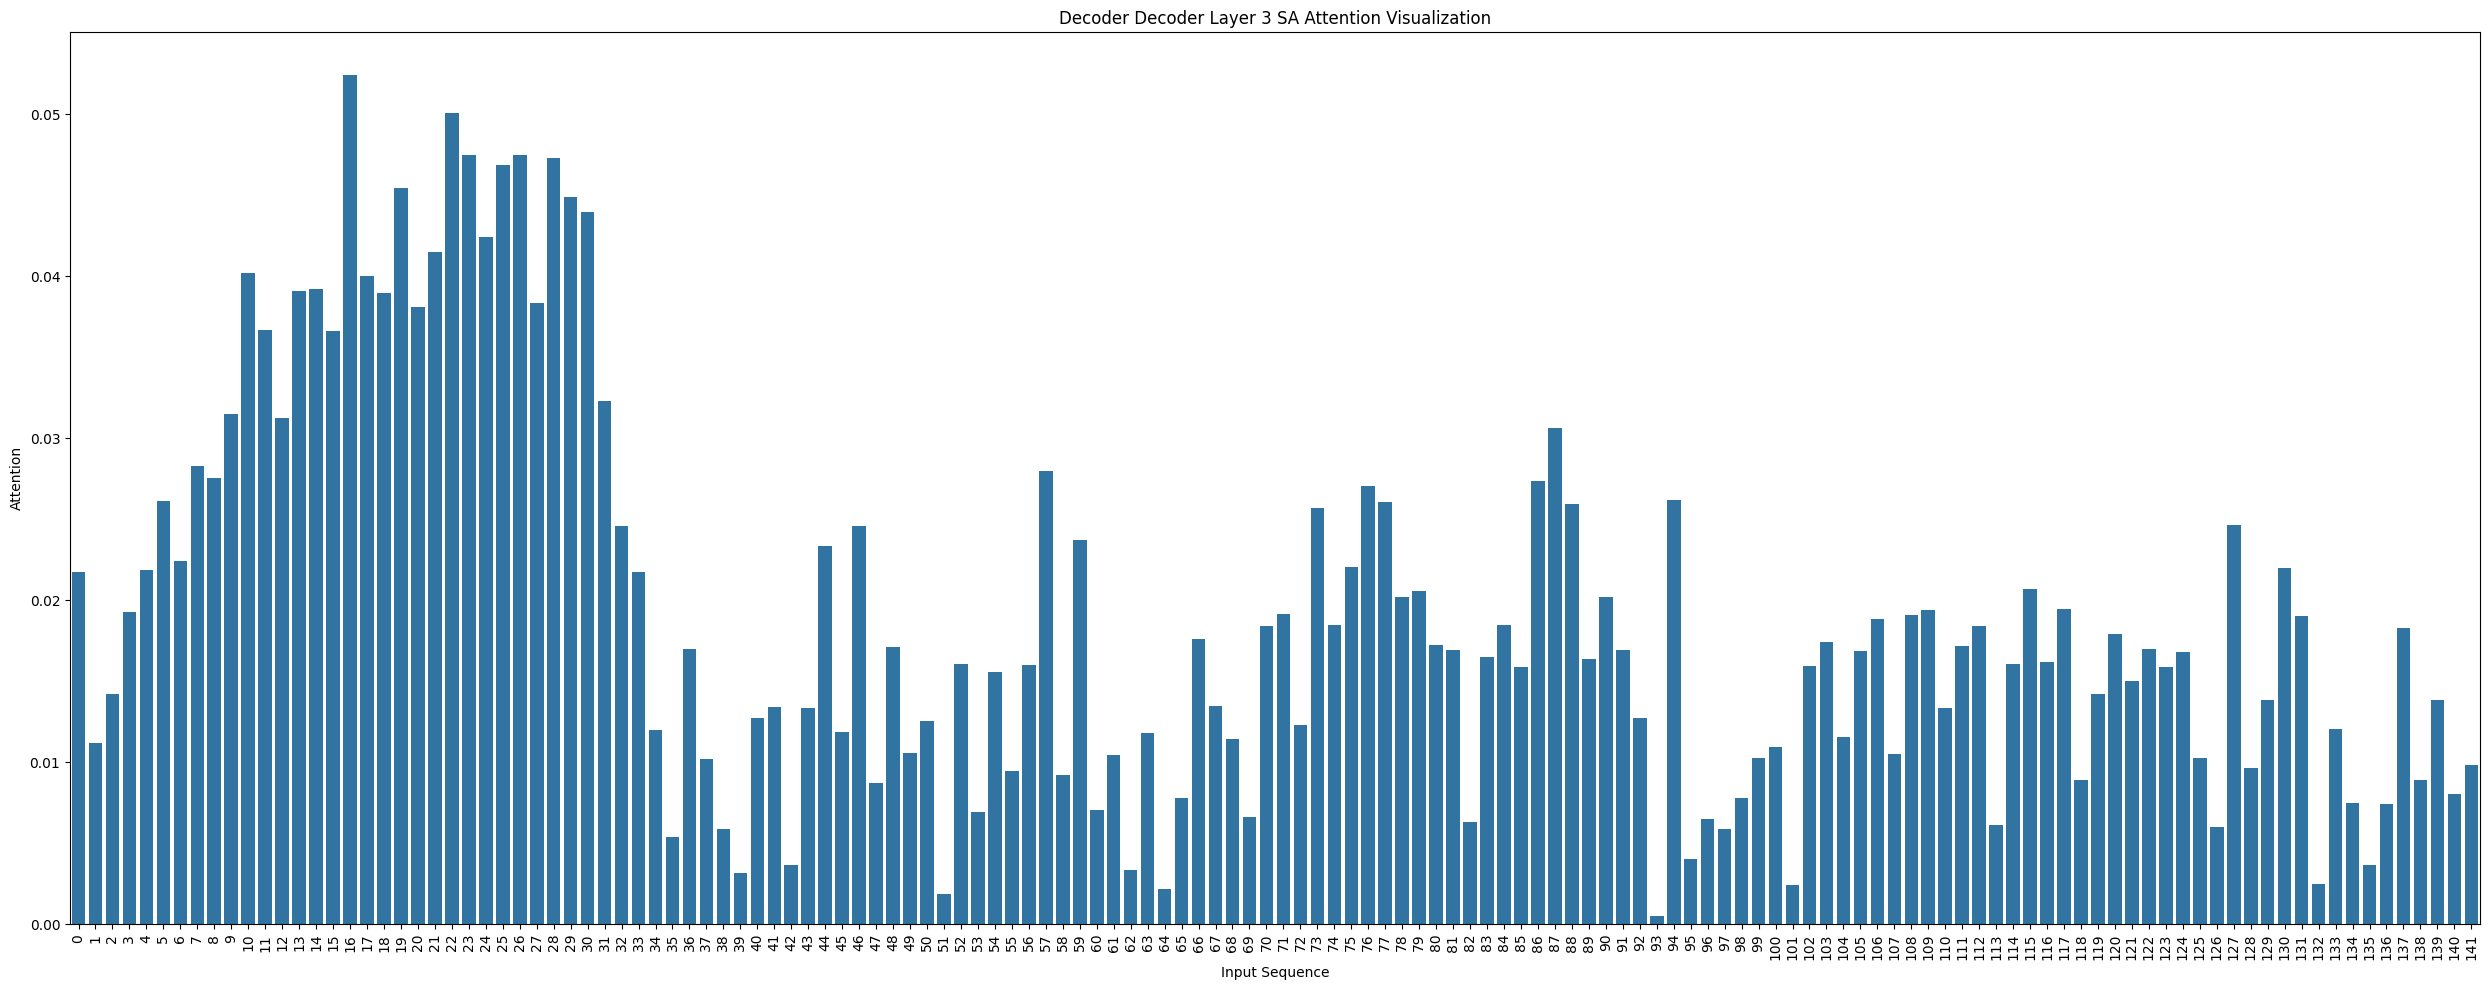

(142, 48)


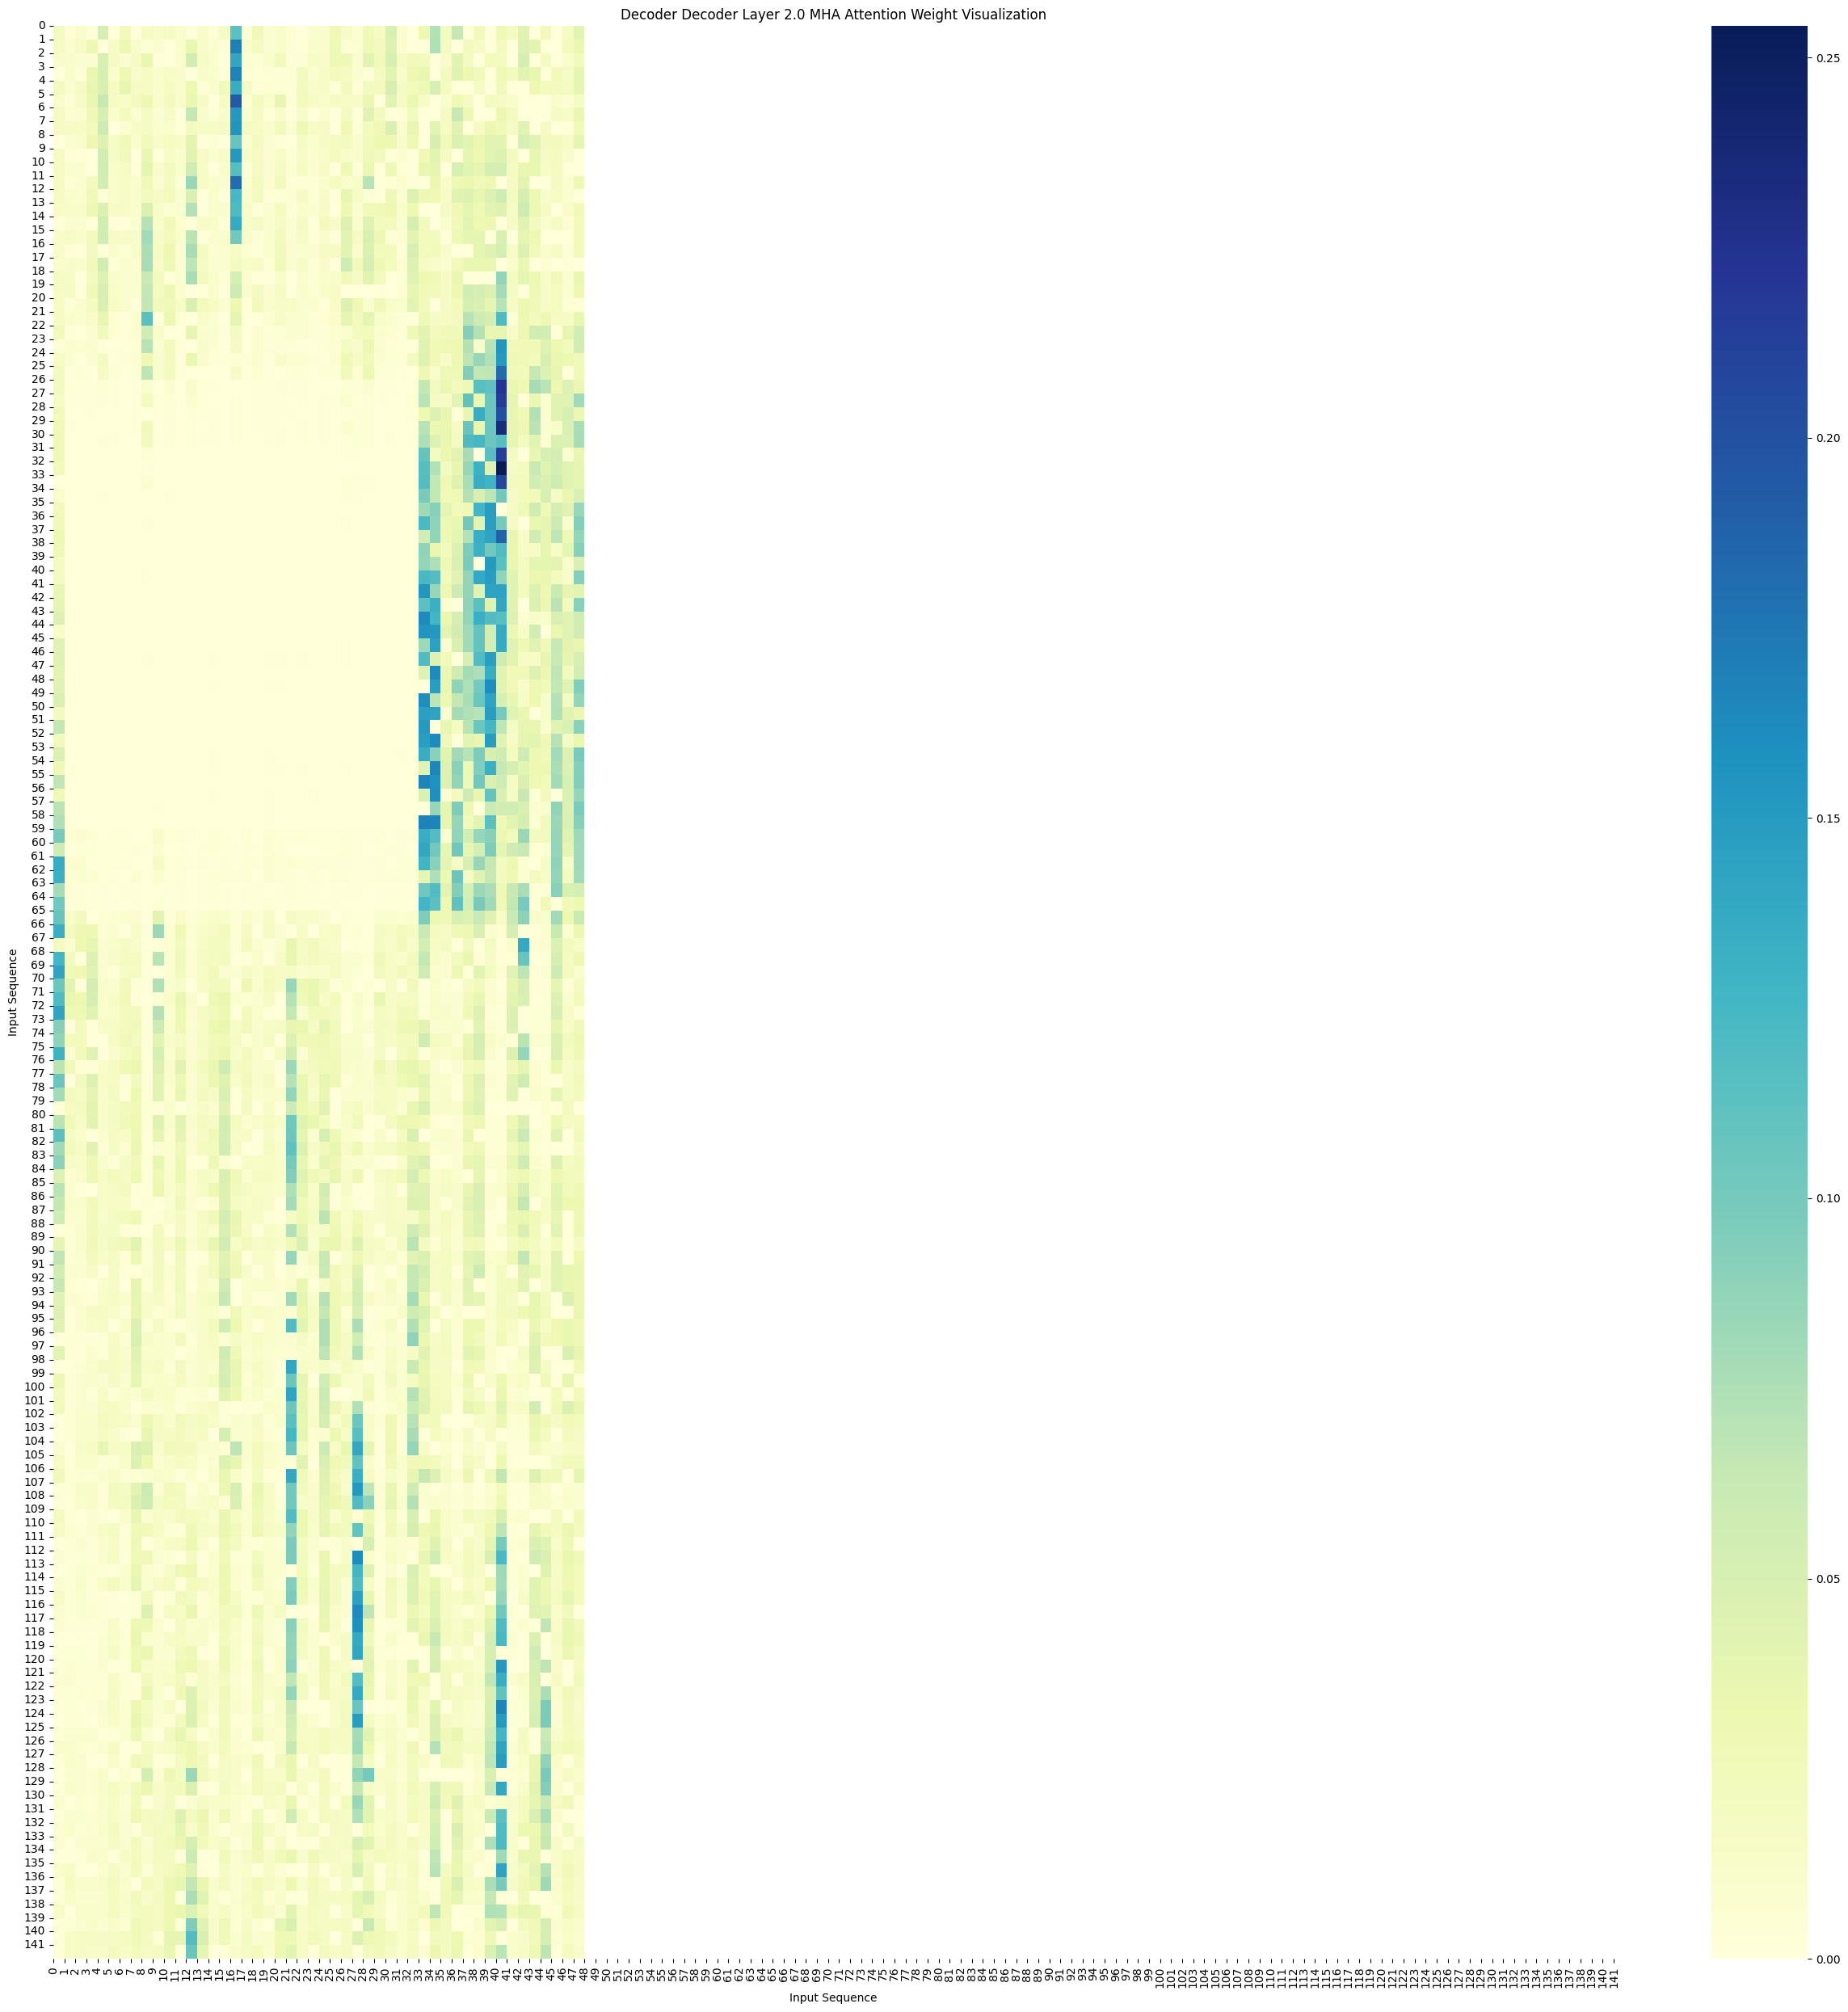

(142,)


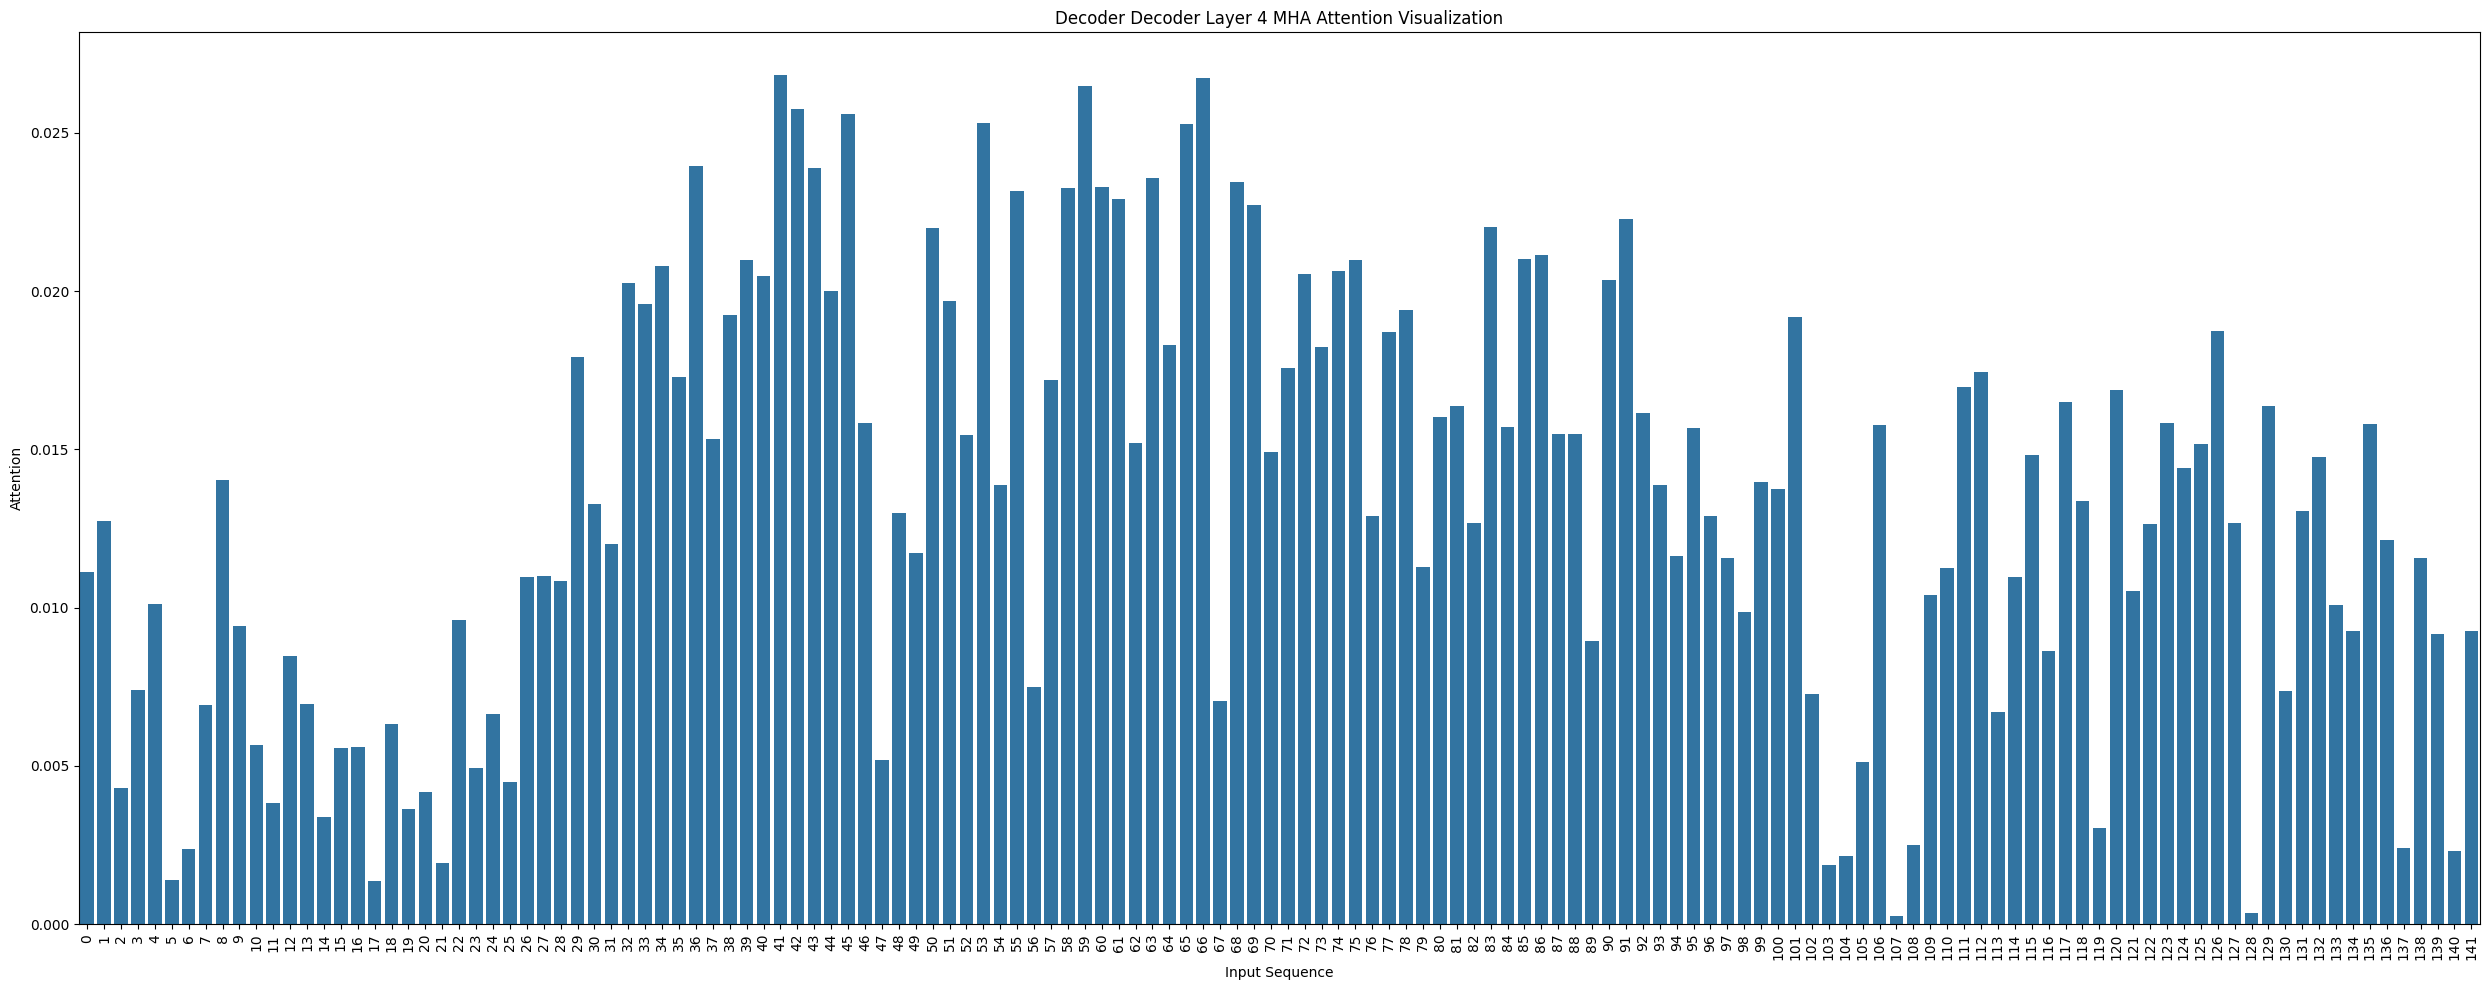

(142, 142)


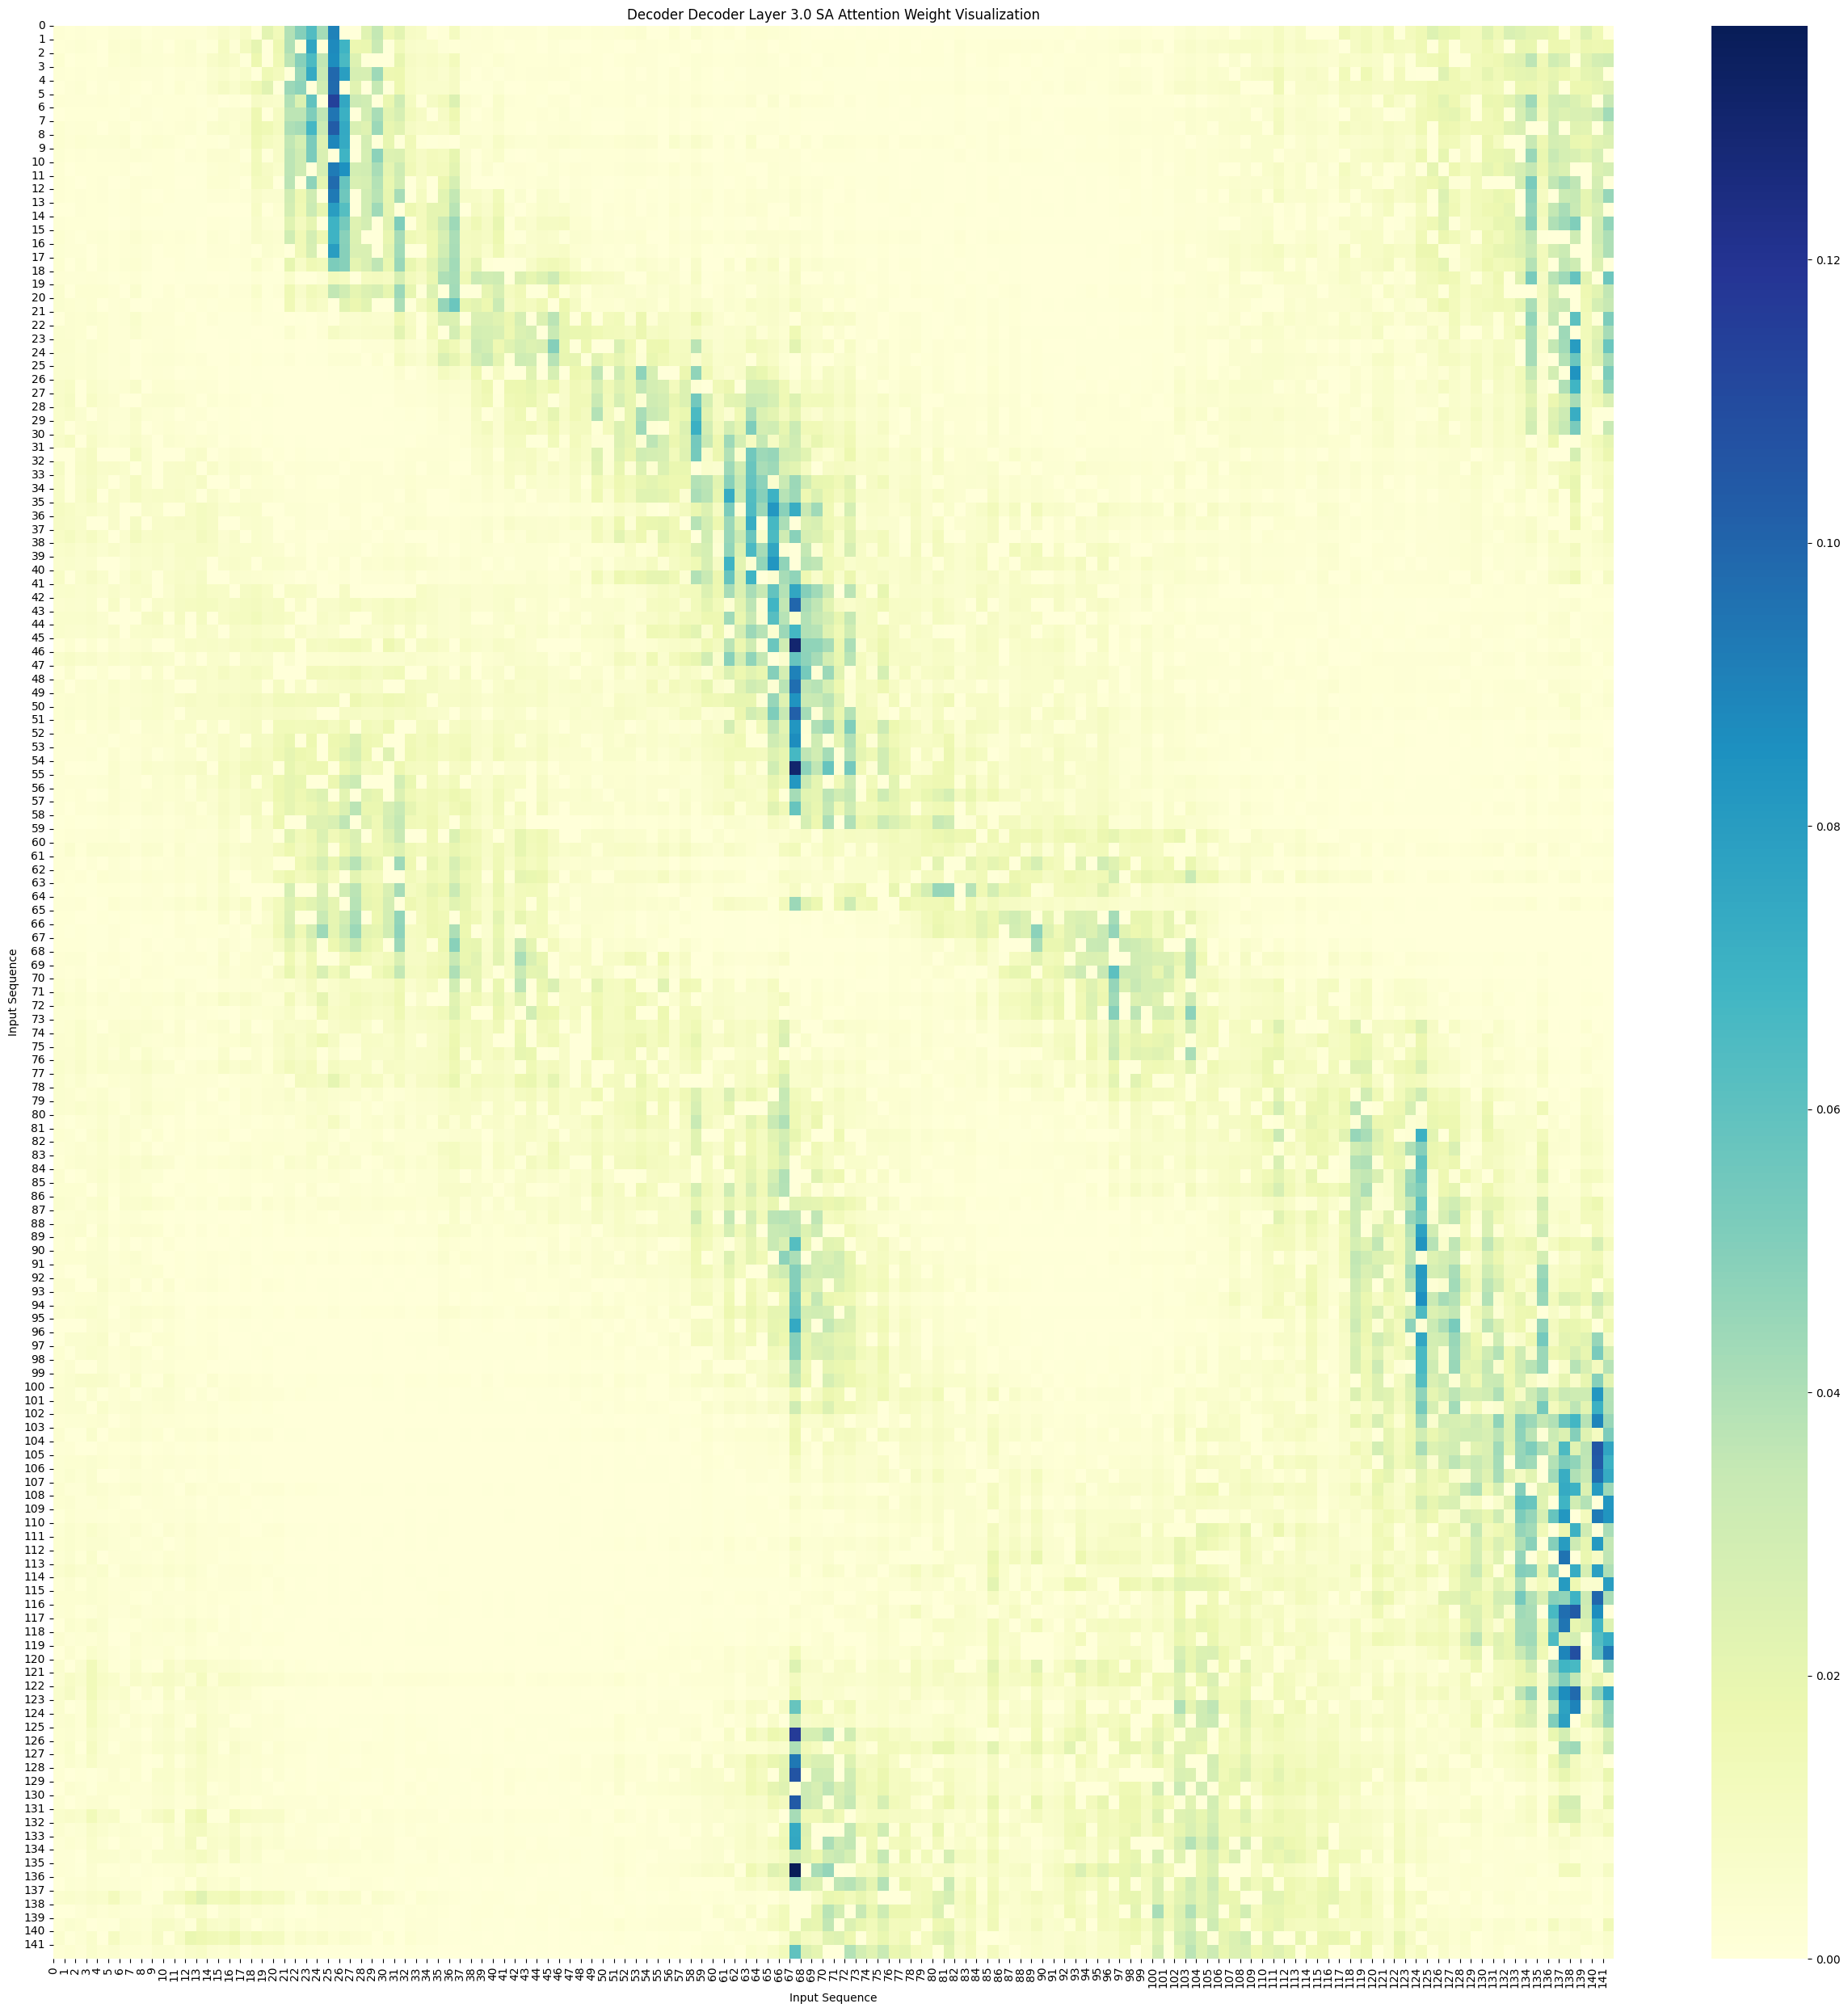

(142,)


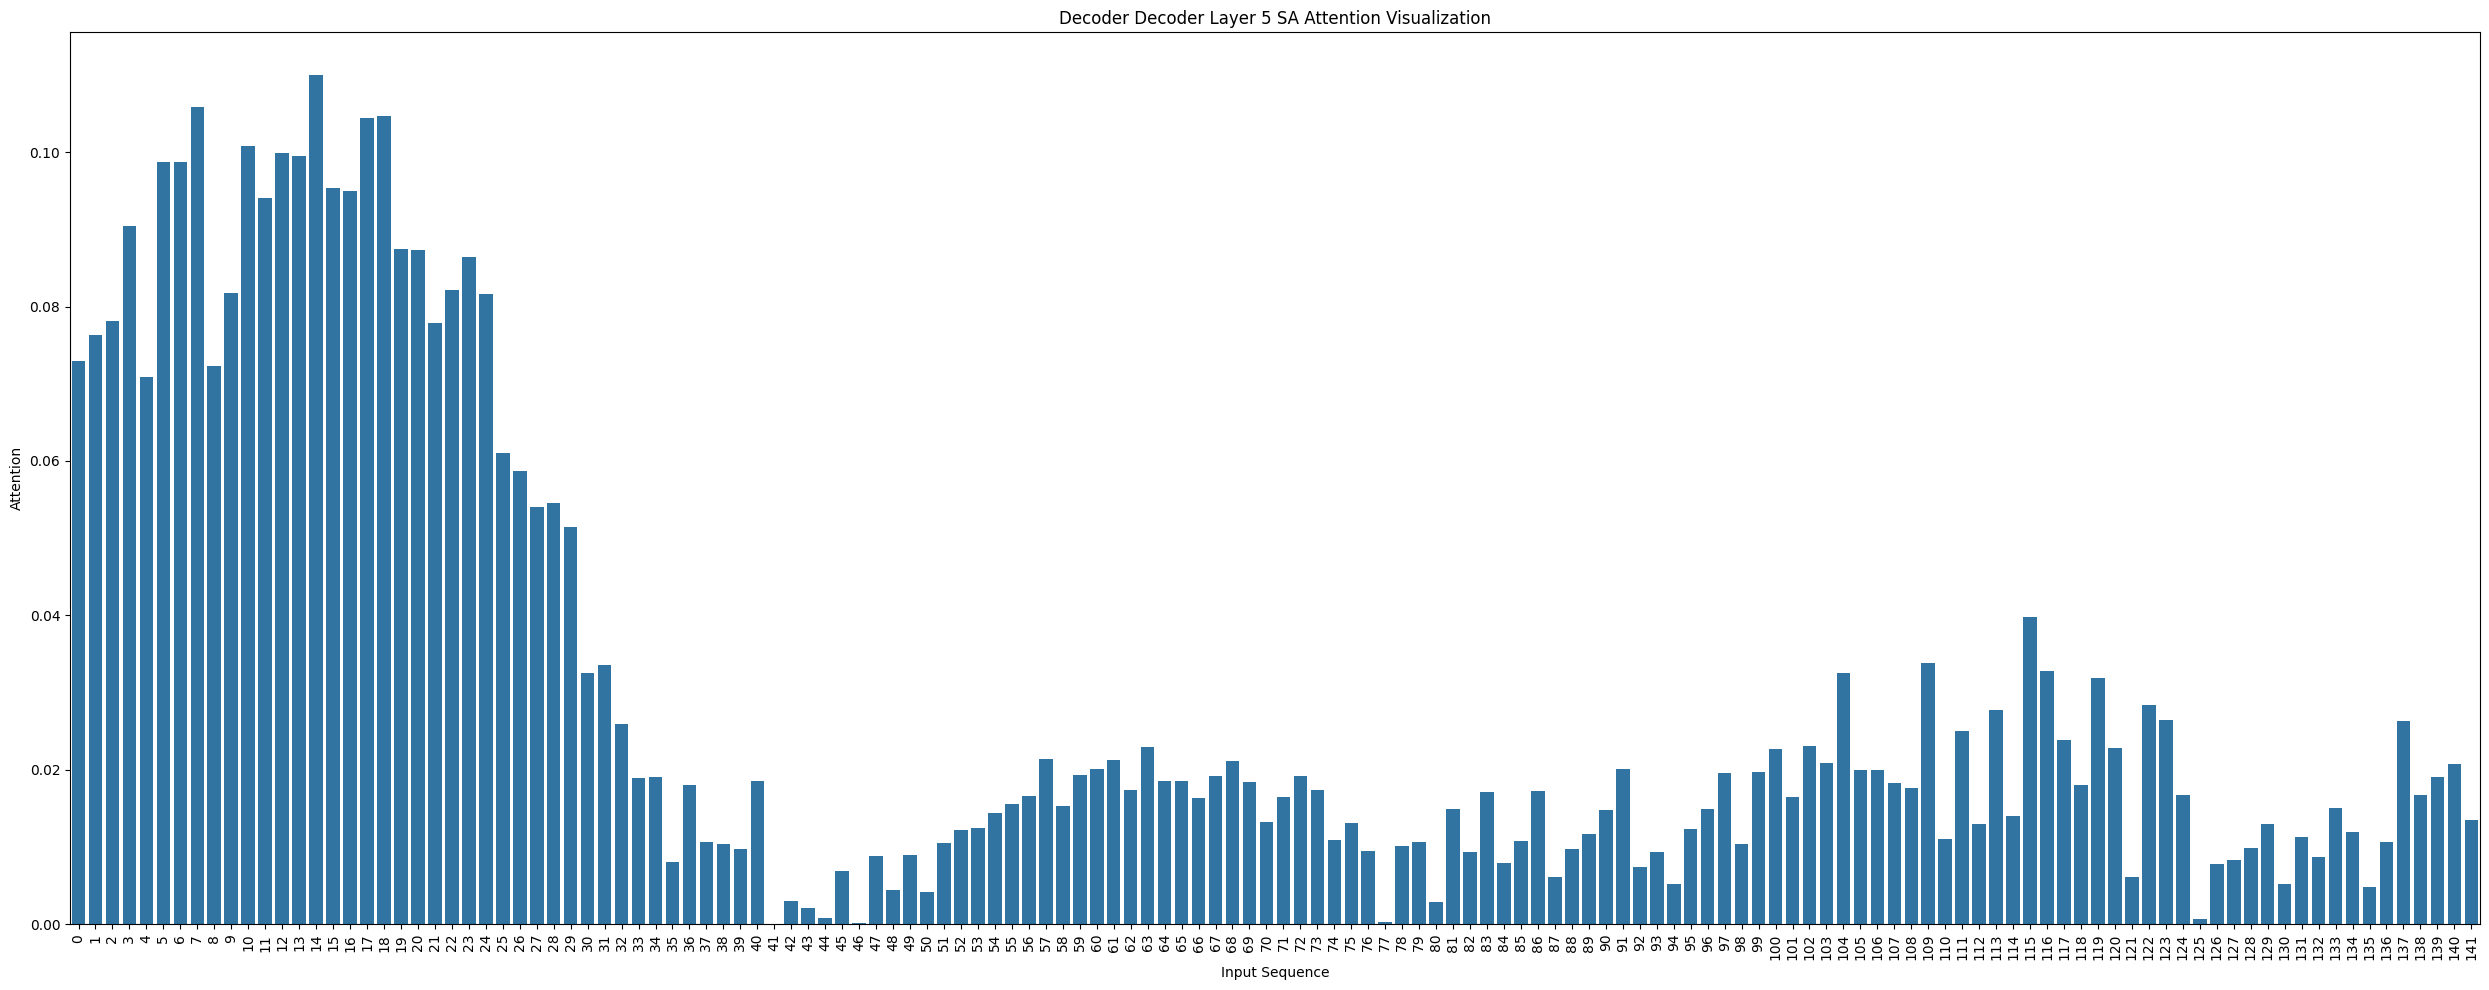

(142, 48)


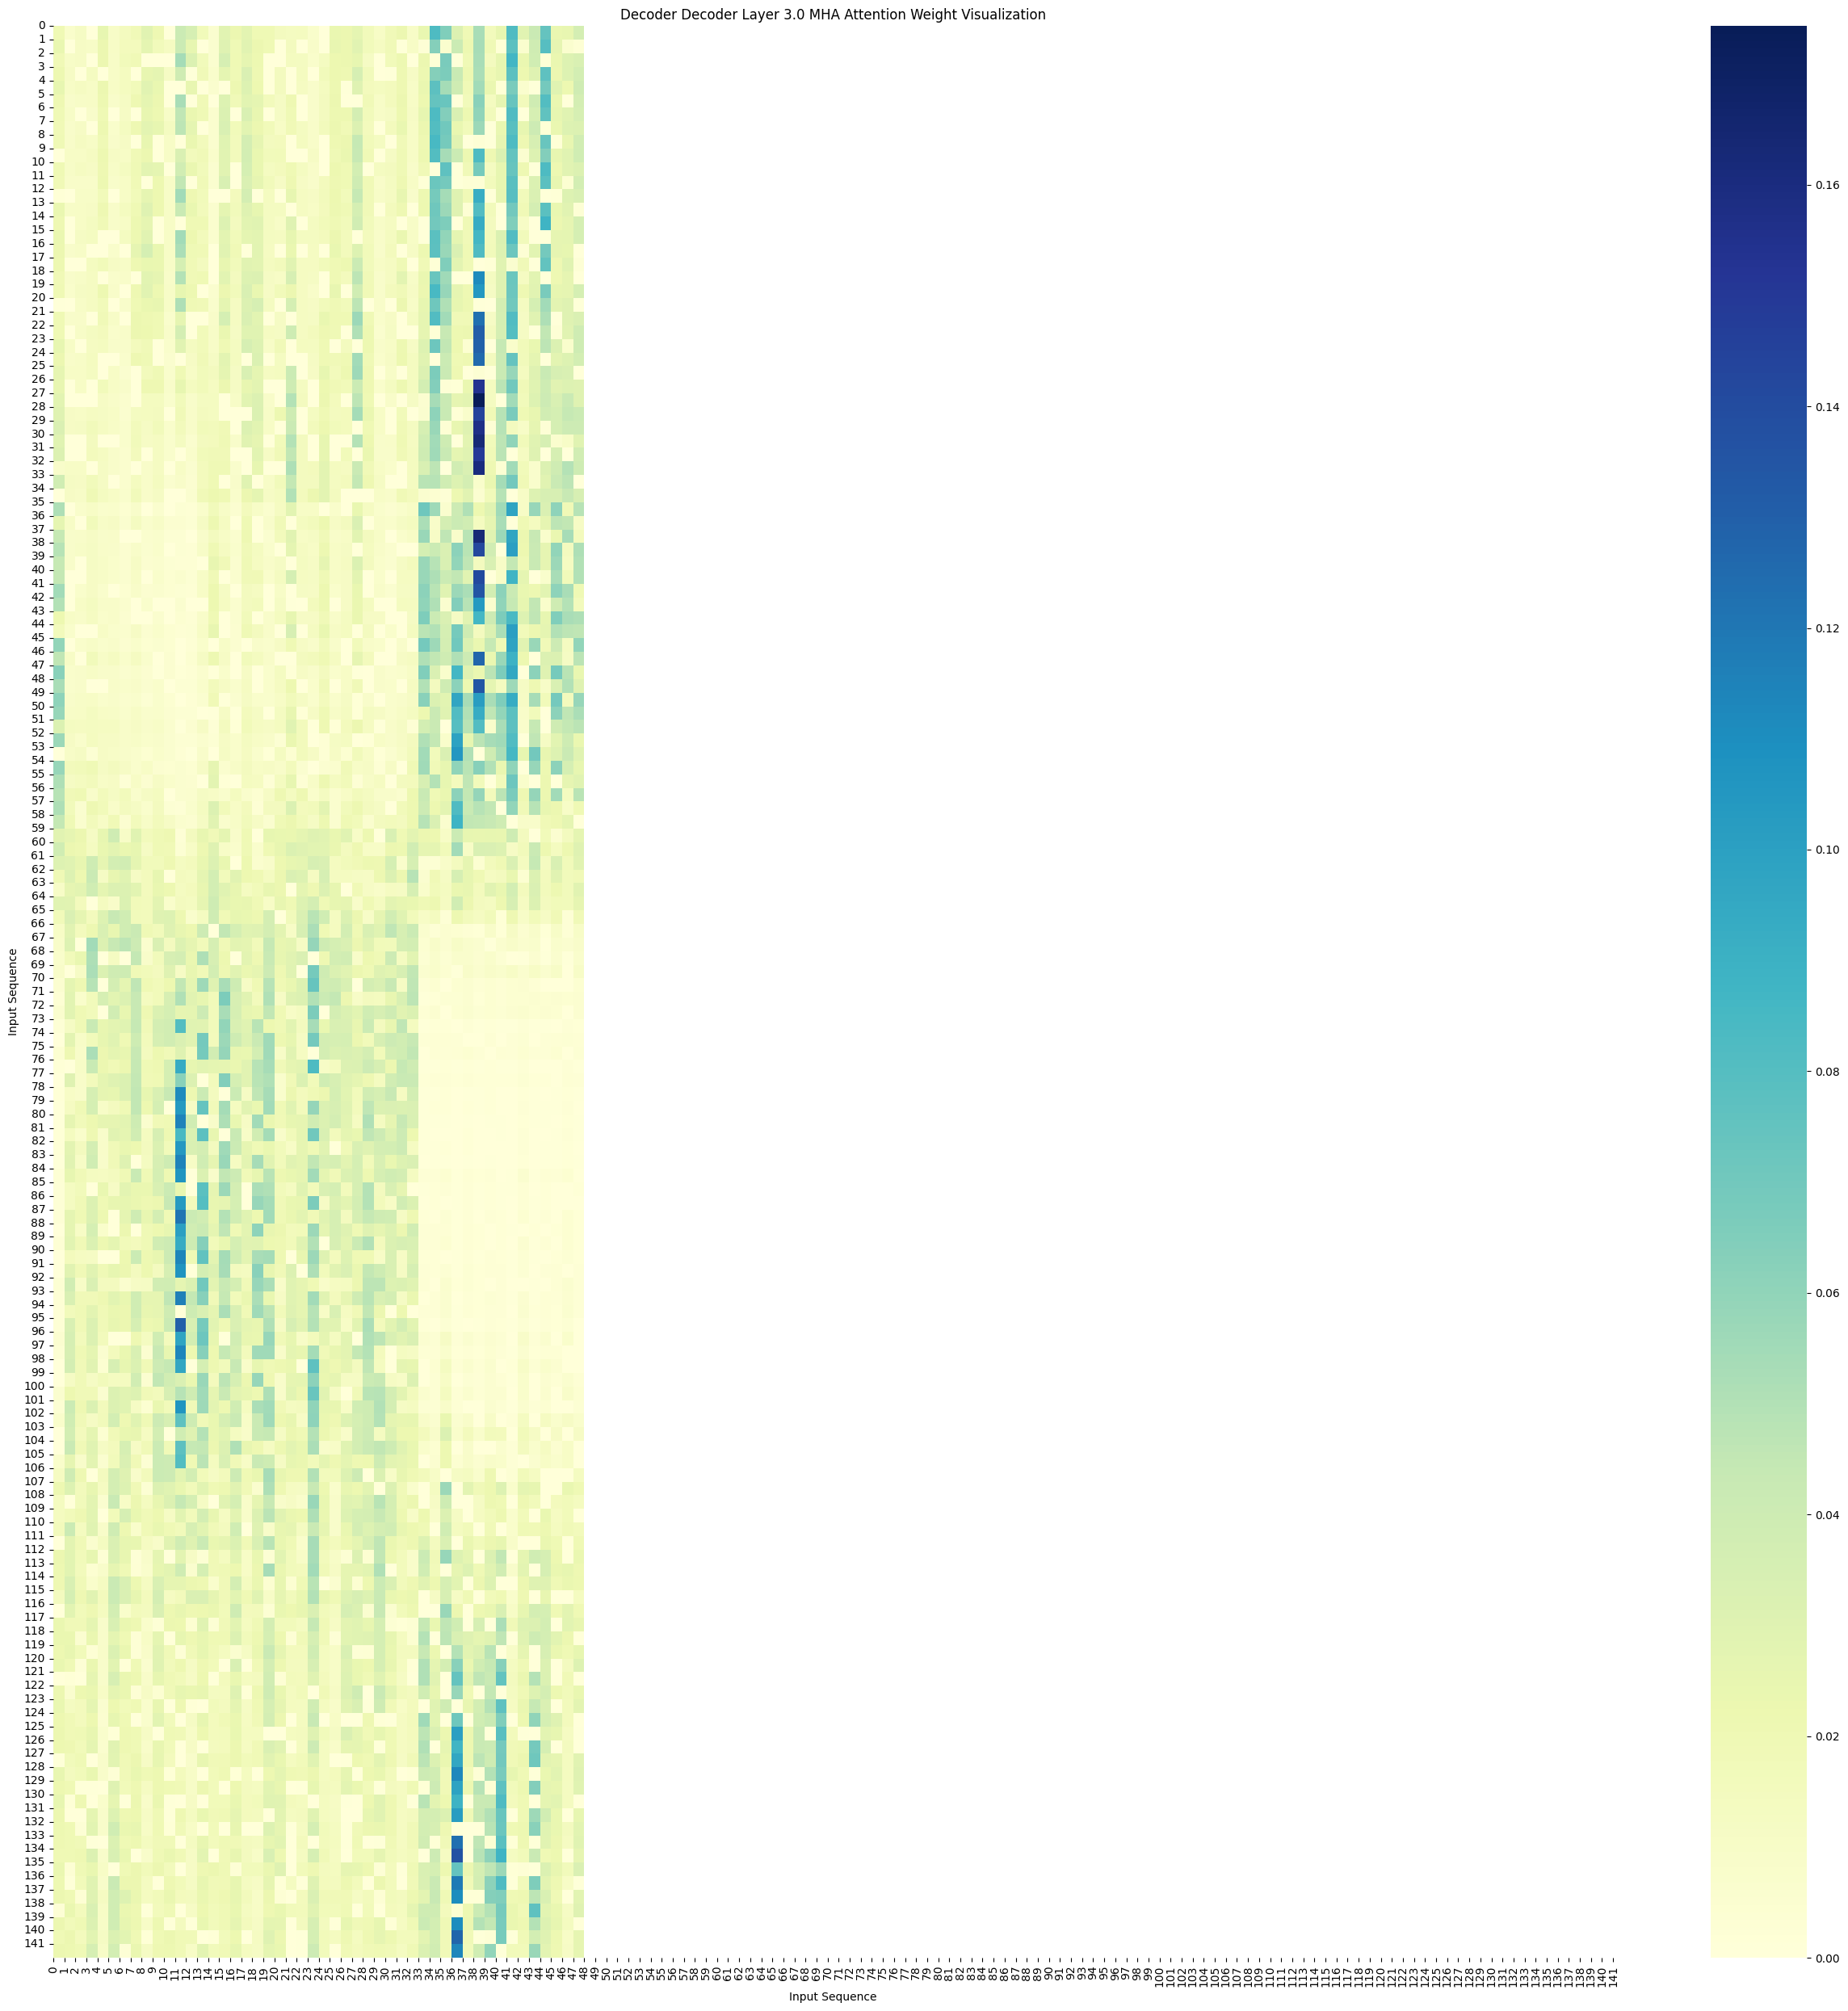

(142,)


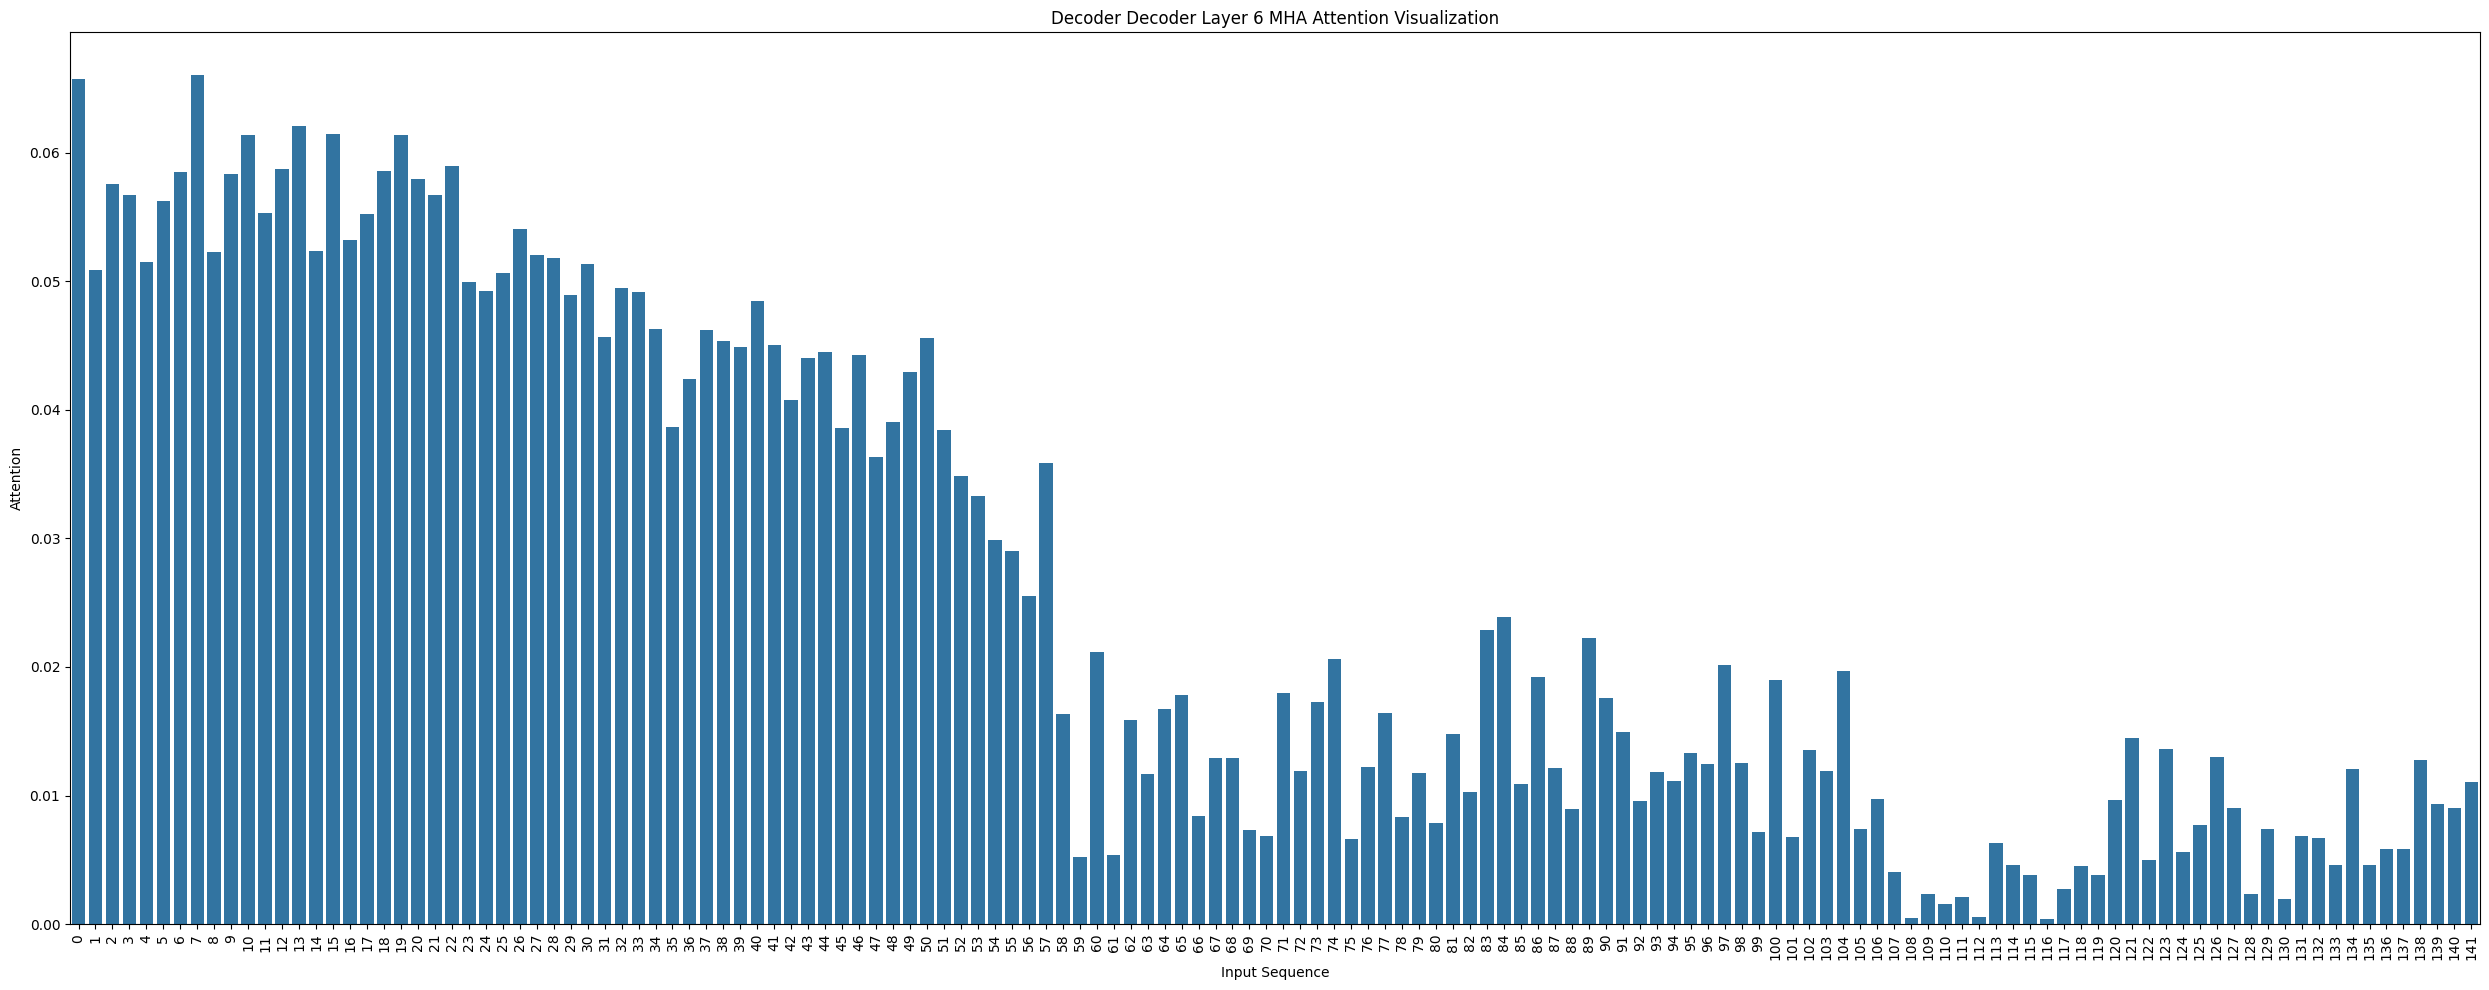

In [16]:
i = 5
data = dataset[i]
# with torch.no_grad():
out = model(data)

print(data["actions"].shape)

# Visualize attention for each layer
for i, hook in enumerate(enc_enc_hooks):
    visualize_attention_weights(hook.attention_weights, len(hook.inputs[0]), "Encoder Encoder", i+1, hook.name)
    visualize_attention(hook.attention, len(hook.inputs[0]), "Encoder Encoder", i+1, hook.name)
for i, hook in enumerate(enc_dec_hooks):
    visualize_attention_weights(hook.attention_weights, len(hook.inputs[0]), "Encoder Decoder", np.ceil((i+1)/2), hook.name)
    visualize_attention(hook.attention, len(hook.inputs[0]), "Encoder Decoder", i+1, hook.name)
for i, hook in enumerate(dec_enc_hooks):
    visualize_attention_weights(hook.attention_weights, len(hook.inputs[0]), "Decoder Encoder", i+1, hook.name)
    visualize_attention(hook.attention, len(hook.inputs[0]), "Decoder Encoder", i+1, hook.name)
for i, hook in enumerate(dec_dec_hooks):
    visualize_attention_weights(hook.attention_weights, len(hook.inputs[0]), "Decoder Decoder", np.ceil((i+1)/2), hook.name)
    visualize_attention(hook.attention, len(hook.inputs[0]), "Decoder Decoder", i+1, hook.name)    